## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


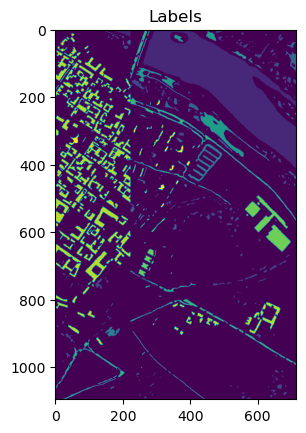

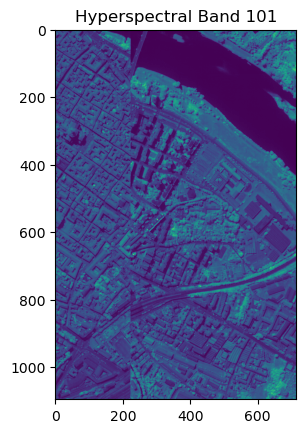

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 40 train


 -- Test set created with: 
	147747 samples
	shape (147747, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(360, 5, 5, 102)
(45, 5, 5, 102)
(147747, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1770, PSNR: 3.4888


	 Training Batch [200/1852], Loss: 0.0851, PSNR: 5.8134


	 Training Batch [400/1852], Loss: 0.0452, PSNR: 11.3173


	 Training Batch [600/1852], Loss: 0.0258, PSNR: 12.1642


	 Training Batch [800/1852], Loss: 0.0176, PSNR: 13.1223


	 Training Batch [1000/1852], Loss: 0.0124, PSNR: 15.1060


	 Training Batch [1200/1852], Loss: 0.0099, PSNR: 14.6529


	 Training Batch [1400/1852], Loss: 0.0073, PSNR: 16.4754


	 Training Batch [1600/1852], Loss: 0.0061, PSNR: 18.5595


	 Training Batch [1800/1852], Loss: 0.0072, PSNR: 18.2023


Epoch [1/50] Training Loss: 0.0333, PSNR: 13.5897
	[Val]   Batch [1/463] Loss: 0.0054, PSNR: 17.8759
	[Val]   Batch [10/463] Loss: 0.0050, PSNR: 19.0803
	[Val]   Batch [20/463] Loss: 0.0051, PSNR: 18.0687
	[Val]   Batch [30/463] Loss: 0.0061, PSNR: 18.6175
	[Val]   Batch [40/463] Loss: 0.0049, PSNR: 17.7273
	[Val]   Batch [50/463] Loss: 0.0051, PSNR: 17.9642
	[Val]   Batch [60/463] Loss: 0.0049, PSNR: 17.9907


	[Val]   Batch [70/463] Loss: 0.0068, PSNR: 18.3838
	[Val]   Batch [80/463] Loss: 0.0060, PSNR: 20.3040
	[Val]   Batch [90/463] Loss: 0.0059, PSNR: 19.3759
	[Val]   Batch [100/463] Loss: 0.0059, PSNR: 19.1002
	[Val]   Batch [110/463] Loss: 0.0069, PSNR: 18.5166
	[Val]   Batch [120/463] Loss: 0.0047, PSNR: 17.9978


	[Val]   Batch [130/463] Loss: 0.0056, PSNR: 19.3731
	[Val]   Batch [140/463] Loss: 0.0065, PSNR: 18.9407
	[Val]   Batch [150/463] Loss: 0.0073, PSNR: 19.0066
	[Val]   Batch [160/463] Loss: 0.0059, PSNR: 19.2334
	[Val]   Batch [170/463] Loss: 0.0076, PSNR: 18.1666
	[Val]   Batch [180/463] Loss: 0.0055, PSNR: 18.9865
	[Val]   Batch [190/463] Loss: 0.0060, PSNR: 19.3260


	[Val]   Batch [200/463] Loss: 0.0059, PSNR: 18.7174
	[Val]   Batch [210/463] Loss: 0.0058, PSNR: 18.2814
	[Val]   Batch [220/463] Loss: 0.0058, PSNR: 19.4857
	[Val]   Batch [230/463] Loss: 0.0068, PSNR: 19.3404
	[Val]   Batch [240/463] Loss: 0.0052, PSNR: 18.1127
	[Val]   Batch [250/463] Loss: 0.0066, PSNR: 17.3100
	[Val]   Batch [260/463] Loss: 0.0058, PSNR: 18.3296


	[Val]   Batch [270/463] Loss: 0.0044, PSNR: 17.4976
	[Val]   Batch [280/463] Loss: 0.0054, PSNR: 20.2144
	[Val]   Batch [290/463] Loss: 0.0060, PSNR: 17.2203
	[Val]   Batch [300/463] Loss: 0.0060, PSNR: 19.4888
	[Val]   Batch [310/463] Loss: 0.0055, PSNR: 19.3834
	[Val]   Batch [320/463] Loss: 0.0056, PSNR: 19.2377
	[Val]   Batch [330/463] Loss: 0.0065, PSNR: 18.6487
	[Val]   Batch [340/463] Loss: 0.0054, PSNR: 19.5731


	[Val]   Batch [350/463] Loss: 0.0070, PSNR: 19.5093
	[Val]   Batch [360/463] Loss: 0.0047, PSNR: 20.4197
	[Val]   Batch [370/463] Loss: 0.0069, PSNR: 18.5459
	[Val]   Batch [380/463] Loss: 0.0068, PSNR: 18.7267
	[Val]   Batch [390/463] Loss: 0.0062, PSNR: 18.5352
	[Val]   Batch [400/463] Loss: 0.0055, PSNR: 17.5771
	[Val]   Batch [410/463] Loss: 0.0053, PSNR: 19.9057
	[Val]   Batch [420/463] Loss: 0.0055, PSNR: 18.7013


	[Val]   Batch [430/463] Loss: 0.0055, PSNR: 18.0869
	[Val]   Batch [440/463] Loss: 0.0054, PSNR: 19.1005
	[Val]   Batch [450/463] Loss: 0.0042, PSNR: 16.4542
	[Val]   Batch [460/463] Loss: 0.0058, PSNR: 17.8438
Epoch [1/50] Validation Loss: 0.0058, PSNR: 18.6671

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0071, PSNR: 18.4680


	 Training Batch [200/1852], Loss: 0.0048, PSNR: 17.9833


	 Training Batch [400/1852], Loss: 0.0059, PSNR: 19.8603


	 Training Batch [600/1852], Loss: 0.0043, PSNR: 20.3710


	 Training Batch [800/1852], Loss: 0.0037, PSNR: 19.7267


	 Training Batch [1000/1852], Loss: 0.0041, PSNR: 20.5403


	 Training Batch [1200/1852], Loss: 0.0030, PSNR: 20.7826


	 Training Batch [1400/1852], Loss: 0.0034, PSNR: 22.5128


	 Training Batch [1600/1852], Loss: 0.0028, PSNR: 21.3327


	 Training Batch [1800/1852], Loss: 0.0023, PSNR: 21.6726


Epoch [2/50] Training Loss: 0.0043, PSNR: 20.1847
	[Val]   Batch [1/463] Loss: 0.0024, PSNR: 21.4903
	[Val]   Batch [10/463] Loss: 0.0021, PSNR: 22.7939
	[Val]   Batch [20/463] Loss: 0.0021, PSNR: 21.8473
	[Val]   Batch [30/463] Loss: 0.0026, PSNR: 22.2630
	[Val]   Batch [40/463] Loss: 0.0022, PSNR: 21.1908
	[Val]   Batch [50/463] Loss: 0.0022, PSNR: 21.5200
	[Val]   Batch [60/463] Loss: 0.0022, PSNR: 21.5140


	[Val]   Batch [70/463] Loss: 0.0030, PSNR: 21.9104
	[Val]   Batch [80/463] Loss: 0.0027, PSNR: 23.8633
	[Val]   Batch [90/463] Loss: 0.0025, PSNR: 23.0099
	[Val]   Batch [100/463] Loss: 0.0027, PSNR: 22.5036
	[Val]   Batch [110/463] Loss: 0.0030, PSNR: 22.0746
	[Val]   Batch [120/463] Loss: 0.0021, PSNR: 21.4504
	[Val]   Batch [130/463] Loss: 0.0023, PSNR: 23.1261


	[Val]   Batch [140/463] Loss: 0.0029, PSNR: 22.4252
	[Val]   Batch [150/463] Loss: 0.0030, PSNR: 22.8264
	[Val]   Batch [160/463] Loss: 0.0028, PSNR: 22.4851
	[Val]   Batch [170/463] Loss: 0.0034, PSNR: 21.6037
	[Val]   Batch [180/463] Loss: 0.0026, PSNR: 22.2290
	[Val]   Batch [190/463] Loss: 0.0025, PSNR: 23.0514
	[Val]   Batch [200/463] Loss: 0.0026, PSNR: 22.3519


	[Val]   Batch [210/463] Loss: 0.0028, PSNR: 21.4533
	[Val]   Batch [220/463] Loss: 0.0027, PSNR: 22.7854
	[Val]   Batch [230/463] Loss: 0.0028, PSNR: 23.2216
	[Val]   Batch [240/463] Loss: 0.0023, PSNR: 21.6849
	[Val]   Batch [250/463] Loss: 0.0030, PSNR: 20.7211
	[Val]   Batch [260/463] Loss: 0.0026, PSNR: 21.7498


	[Val]   Batch [270/463] Loss: 0.0019, PSNR: 21.1230
	[Val]   Batch [280/463] Loss: 0.0024, PSNR: 23.7390
	[Val]   Batch [290/463] Loss: 0.0026, PSNR: 20.8140
	[Val]   Batch [300/463] Loss: 0.0027, PSNR: 22.9586
	[Val]   Batch [310/463] Loss: 0.0027, PSNR: 22.5404
	[Val]   Batch [320/463] Loss: 0.0025, PSNR: 22.6837
	[Val]   Batch [330/463] Loss: 0.0027, PSNR: 22.4599
	[Val]   Batch [340/463] Loss: 0.0024, PSNR: 23.0583


	[Val]   Batch [350/463] Loss: 0.0033, PSNR: 22.7953
	[Val]   Batch [360/463] Loss: 0.0024, PSNR: 23.4006
	[Val]   Batch [370/463] Loss: 0.0030, PSNR: 22.2300
	[Val]   Batch [380/463] Loss: 0.0027, PSNR: 22.7181
	[Val]   Batch [390/463] Loss: 0.0026, PSNR: 22.3927
	[Val]   Batch [400/463] Loss: 0.0025, PSNR: 20.9449
	[Val]   Batch [410/463] Loss: 0.0023, PSNR: 23.5940


	[Val]   Batch [420/463] Loss: 0.0024, PSNR: 22.4276
	[Val]   Batch [430/463] Loss: 0.0026, PSNR: 21.3574
	[Val]   Batch [440/463] Loss: 0.0025, PSNR: 22.3699
	[Val]   Batch [450/463] Loss: 0.0020, PSNR: 19.6814
	[Val]   Batch [460/463] Loss: 0.0025, PSNR: 21.5048
Epoch [2/50] Validation Loss: 0.0025, PSNR: 22.2243

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0032, PSNR: 22.6988


	 Training Batch [200/1852], Loss: 0.0033, PSNR: 23.0259


	 Training Batch [400/1852], Loss: 0.0021, PSNR: 22.3830


	 Training Batch [600/1852], Loss: 0.0020, PSNR: 22.1228


	 Training Batch [800/1852], Loss: 0.0025, PSNR: 23.0649


	 Training Batch [1000/1852], Loss: 0.0020, PSNR: 23.1516


	 Training Batch [1200/1852], Loss: 0.0017, PSNR: 23.5969


	 Training Batch [1400/1852], Loss: 0.0019, PSNR: 21.8768


	 Training Batch [1600/1852], Loss: 0.0019, PSNR: 22.2190


	 Training Batch [1800/1852], Loss: 0.0020, PSNR: 23.9651


Epoch [3/50] Training Loss: 0.0022, PSNR: 22.9080
	[Val]   Batch [1/463] Loss: 0.0014, PSNR: 23.6690
	[Val]   Batch [10/463] Loss: 0.0013, PSNR: 25.0056
	[Val]   Batch [20/463] Loss: 0.0013, PSNR: 24.1316
	[Val]   Batch [30/463] Loss: 0.0015, PSNR: 24.6929
	[Val]   Batch [40/463] Loss: 0.0014, PSNR: 23.1874
	[Val]   Batch [50/463] Loss: 0.0014, PSNR: 23.5776
	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.5264


	[Val]   Batch [70/463] Loss: 0.0017, PSNR: 24.3476
	[Val]   Batch [80/463] Loss: 0.0015, PSNR: 26.4228
	[Val]   Batch [90/463] Loss: 0.0015, PSNR: 25.2951
	[Val]   Batch [100/463] Loss: 0.0016, PSNR: 24.8259
	[Val]   Batch [110/463] Loss: 0.0017, PSNR: 24.5862
	[Val]   Batch [120/463] Loss: 0.0013, PSNR: 23.4530
	[Val]   Batch [130/463] Loss: 0.0013, PSNR: 25.6230
	[Val]   Batch [140/463] Loss: 0.0017, PSNR: 24.7675


	[Val]   Batch [150/463] Loss: 0.0016, PSNR: 25.5815
	[Val]   Batch [160/463] Loss: 0.0018, PSNR: 24.4791
	[Val]   Batch [170/463] Loss: 0.0021, PSNR: 23.7690
	[Val]   Batch [180/463] Loss: 0.0016, PSNR: 24.3230
	[Val]   Batch [190/463] Loss: 0.0015, PSNR: 25.4064
	[Val]   Batch [200/463] Loss: 0.0014, PSNR: 24.9158
	[Val]   Batch [210/463] Loss: 0.0018, PSNR: 23.4380
	[Val]   Batch [220/463] Loss: 0.0017, PSNR: 24.8250


	[Val]   Batch [230/463] Loss: 0.0014, PSNR: 26.1122
	[Val]   Batch [240/463] Loss: 0.0014, PSNR: 23.9104
	[Val]   Batch [250/463] Loss: 0.0019, PSNR: 22.8012
	[Val]   Batch [260/463] Loss: 0.0016, PSNR: 23.7993
	[Val]   Batch [270/463] Loss: 0.0012, PSNR: 23.1511
	[Val]   Batch [280/463] Loss: 0.0015, PSNR: 25.9086
	[Val]   Batch [290/463] Loss: 0.0016, PSNR: 23.0855


	[Val]   Batch [300/463] Loss: 0.0017, PSNR: 25.0546
	[Val]   Batch [310/463] Loss: 0.0017, PSNR: 24.4659
	[Val]   Batch [320/463] Loss: 0.0015, PSNR: 24.9311
	[Val]   Batch [330/463] Loss: 0.0015, PSNR: 24.9942
	[Val]   Batch [340/463] Loss: 0.0014, PSNR: 25.2684
	[Val]   Batch [350/463] Loss: 0.0019, PSNR: 25.1147
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.8837
	[Val]   Batch [370/463] Loss: 0.0017, PSNR: 24.6981


	[Val]   Batch [380/463] Loss: 0.0014, PSNR: 25.5014
	[Val]   Batch [390/463] Loss: 0.0014, PSNR: 25.0265
	[Val]   Batch [400/463] Loss: 0.0016, PSNR: 22.8837
	[Val]   Batch [410/463] Loss: 0.0013, PSNR: 25.9277
	[Val]   Batch [420/463] Loss: 0.0014, PSNR: 24.7075
	[Val]   Batch [430/463] Loss: 0.0017, PSNR: 23.2444


	[Val]   Batch [440/463] Loss: 0.0016, PSNR: 24.3894
	[Val]   Batch [450/463] Loss: 0.0013, PSNR: 21.4168
	[Val]   Batch [460/463] Loss: 0.0015, PSNR: 23.7044
Epoch [3/50] Validation Loss: 0.0015, PSNR: 24.4935

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0017, PSNR: 24.4864


	 Training Batch [200/1852], Loss: 0.0019, PSNR: 24.1497


	 Training Batch [400/1852], Loss: 0.0016, PSNR: 23.0489


	 Training Batch [600/1852], Loss: 0.0014, PSNR: 24.9544


	 Training Batch [800/1852], Loss: 0.0014, PSNR: 22.9097


	 Training Batch [1000/1852], Loss: 0.0012, PSNR: 25.0662


	 Training Batch [1200/1852], Loss: 0.0013, PSNR: 23.2098


	 Training Batch [1400/1852], Loss: 0.0025, PSNR: 24.1753


	 Training Batch [1600/1852], Loss: 0.0015, PSNR: 25.7043


	 Training Batch [1800/1852], Loss: 0.0012, PSNR: 25.1821


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.4220
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.8080
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 26.1515
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 25.3138
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.8386
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.2482
	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.7140
	[Val]   Batch [60/463] Loss: 0.0011, PSNR: 24.6280


	[Val]   Batch [70/463] Loss: 0.0013, PSNR: 25.4981
	[Val]   Batch [80/463] Loss: 0.0011, PSNR: 27.7570
	[Val]   Batch [90/463] Loss: 0.0011, PSNR: 26.4670
	[Val]   Batch [100/463] Loss: 0.0012, PSNR: 26.0361
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.8298
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.5980
	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.7971


	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 25.9150
	[Val]   Batch [150/463] Loss: 0.0012, PSNR: 26.7790
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.5181
	[Val]   Batch [170/463] Loss: 0.0016, PSNR: 24.8202
	[Val]   Batch [180/463] Loss: 0.0013, PSNR: 25.4024
	[Val]   Batch [190/463] Loss: 0.0011, PSNR: 26.5459
	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 26.1559
	[Val]   Batch [210/463] Loss: 0.0014, PSNR: 24.4865


	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 25.9290
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.4130
	[Val]   Batch [240/463] Loss: 0.0010, PSNR: 25.1106
	[Val]   Batch [250/463] Loss: 0.0015, PSNR: 23.8540
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.8048
	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.3566
	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 27.0495


	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.2653
	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 26.0978
	[Val]   Batch [310/463] Loss: 0.0013, PSNR: 25.5555
	[Val]   Batch [320/463] Loss: 0.0011, PSNR: 26.1571
	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 26.1792
	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.4334
	[Val]   Batch [350/463] Loss: 0.0015, PSNR: 26.2219
	[Val]   Batch [360/463] Loss: 0.0014, PSNR: 25.7350


	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.9029
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.7697
	[Val]   Batch [390/463] Loss: 0.0010, PSNR: 26.2766
	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.9346
	[Val]   Batch [410/463] Loss: 0.0010, PSNR: 27.1128
	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.7969
	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.2434


	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.5378
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.5457
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.8125
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.6512

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0013, PSNR: 21.7809


	 Training Batch [200/1852], Loss: 0.0015, PSNR: 25.0298


	 Training Batch [400/1852], Loss: 0.0012, PSNR: 24.4220


	 Training Batch [600/1852], Loss: 0.0011, PSNR: 25.5391


	 Training Batch [800/1852], Loss: 0.0011, PSNR: 24.4769


	 Training Batch [1000/1852], Loss: 0.0012, PSNR: 25.8909


	 Training Batch [1200/1852], Loss: 0.0011, PSNR: 27.3518


	 Training Batch [1400/1852], Loss: 0.0014, PSNR: 24.3030


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 25.8309


	 Training Batch [1800/1852], Loss: 0.0011, PSNR: 25.0458


Epoch [5/50] Training Loss: 0.0013, PSNR: 25.4062
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.8276
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.2371
	[Val]   Batch [20/463] Loss: 0.0007, PSNR: 26.4397
	[Val]   Batch [30/463] Loss: 0.0009, PSNR: 26.8141
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 25.2330
	[Val]   Batch [50/463] Loss: 0.0008, PSNR: 25.8466


	[Val]   Batch [60/463] Loss: 0.0008, PSNR: 25.6647
	[Val]   Batch [70/463] Loss: 0.0010, PSNR: 26.5331
	[Val]   Batch [80/463] Loss: 0.0008, PSNR: 28.9872
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.5702
	[Val]   Batch [100/463] Loss: 0.0009, PSNR: 27.0947
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.9651
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.6669


	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.8679
	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 26.9971
	[Val]   Batch [150/463] Loss: 0.0009, PSNR: 27.9636
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.4686
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.7838
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.4119
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.5901


	[Val]   Batch [200/463] Loss: 0.0008, PSNR: 27.3711
	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.4758
	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 26.8811
	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.5961
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.2057
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.8592
	[Val]   Batch [260/463] Loss: 0.0010, PSNR: 25.7598


	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.5255
	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 28.1254
	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.3539
	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 26.9913
	[Val]   Batch [310/463] Loss: 0.0011, PSNR: 26.5858
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.3231
	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.3192
	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.5385


	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.1821
	[Val]   Batch [360/463] Loss: 0.0012, PSNR: 26.5219
	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 26.9943
	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 27.9924
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.4204
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 24.9188
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 28.2085


	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.8410
	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 25.1747
	[Val]   Batch [440/463] Loss: 0.0010, PSNR: 26.5061
	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.5855
	[Val]   Batch [460/463] Loss: 0.0009, PSNR: 25.8395
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.7311

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0011, PSNR: 24.5831


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 26.7901


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 25.1672


	 Training Batch [600/1852], Loss: 0.0013, PSNR: 25.4028


	 Training Batch [800/1852], Loss: 0.0011, PSNR: 26.1430


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 26.8530


	 Training Batch [1200/1852], Loss: 0.0012, PSNR: 24.9752


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 27.1948


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 26.3737


	 Training Batch [1800/1852], Loss: 0.0010, PSNR: 25.9746


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.1698
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.6292
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.0796
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.3060
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.6458
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 26.0364
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.7137
	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.4736


	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.3453
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.9512
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.4340
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.9180
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.8347
	[Val]   Batch [120/463] Loss: 0.0007, PSNR: 26.5614
	[Val]   Batch [130/463] Loss: 0.0007, PSNR: 28.6689


	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 27.8812
	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.8020
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.2529
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.5549
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.2167
	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.4111


	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.2808
	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.3208
	[Val]   Batch [220/463] Loss: 0.0009, PSNR: 27.6959
	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.4720
	[Val]   Batch [240/463] Loss: 0.0007, PSNR: 27.0848
	[Val]   Batch [250/463] Loss: 0.0010, PSNR: 25.6288
	[Val]   Batch [260/463] Loss: 0.0009, PSNR: 26.5270


	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 26.5486
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 29.0119
	[Val]   Batch [290/463] Loss: 0.0008, PSNR: 26.2104
	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.7793
	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.4711
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.2475
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.1698
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.4185


	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 27.9541
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.1565
	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 27.8491
	[Val]   Batch [380/463] Loss: 0.0007, PSNR: 28.8989
	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.2970
	[Val]   Batch [400/463] Loss: 0.0008, PSNR: 25.7088
	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 29.0118


	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.6551
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 25.9513
	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.3654
	[Val]   Batch [450/463] Loss: 0.0007, PSNR: 24.5056
	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.6824
Epoch [6/50] Validation Loss: 0.0007, PSNR: 27.5806

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0010, PSNR: 26.4291


	 Training Batch [200/1852], Loss: 0.0011, PSNR: 26.1302


	 Training Batch [400/1852], Loss: 0.0014, PSNR: 25.0614


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 26.4718


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 27.2981


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 27.9974


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 27.0893


	 Training Batch [1400/1852], Loss: 0.0011, PSNR: 27.5793


	 Training Batch [1600/1852], Loss: 0.0009, PSNR: 26.7532


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 26.8395


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.8237
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.2317
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 28.7387
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 27.9058
	[Val]   Batch [30/463] Loss: 0.0007, PSNR: 28.2981
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.6570
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.4299
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.0461


	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 27.9730
	[Val]   Batch [80/463] Loss: 0.0006, PSNR: 30.6912
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.0991
	[Val]   Batch [100/463] Loss: 0.0007, PSNR: 28.6198
	[Val]   Batch [110/463] Loss: 0.0007, PSNR: 28.5306
	[Val]   Batch [120/463] Loss: 0.0006, PSNR: 27.2242
	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 29.2998
	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.5099


	[Val]   Batch [150/463] Loss: 0.0007, PSNR: 29.5018
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 27.9049
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.2456
	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 27.9508
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.0391
	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 28.9139
	[Val]   Batch [210/463] Loss: 0.0008, PSNR: 27.0120


	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.3708
	[Val]   Batch [230/463] Loss: 0.0006, PSNR: 30.1245
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.7538
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.2751
	[Val]   Batch [260/463] Loss: 0.0008, PSNR: 27.1722
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 27.2633
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.6769
	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 26.8761


	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.3135
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.1597
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 28.9867
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 28.8224
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.0890
	[Val]   Batch [350/463] Loss: 0.0009, PSNR: 28.6062


	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.6144
	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.5346
	[Val]   Batch [380/463] Loss: 0.0006, PSNR: 29.5401
	[Val]   Batch [390/463] Loss: 0.0006, PSNR: 28.9605
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.3254
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.5959
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.2694


	[Val]   Batch [430/463] Loss: 0.0008, PSNR: 26.6121
	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 28.0112
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 25.2201
	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 27.3532
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.2378

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0009, PSNR: 26.3660


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 27.9417


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 28.8964


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 26.1852


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 26.5459


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 27.3193


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 27.0228


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 28.0806


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 27.7525


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 26.5429


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.4169
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 27.8833
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 29.4688
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.6919
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.9551
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.3706
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.2159
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.7517


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.6794
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 31.4605
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 29.8551
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 29.3628
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 29.2722
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.9175
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.9975


	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.1993
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.3194
	[Val]   Batch [160/463] Loss: 0.0007, PSNR: 28.6473
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 27.9337
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.6450
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 29.6835
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.6521


	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.7609
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.0358
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.8147
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.4765
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.0464
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 27.9551
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.0292
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.3659


	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.6777
	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 28.9375
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 28.8614
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.7772
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.5864
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 29.8377
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.3170


	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.0878
	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 29.2755
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 30.3461
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.7103
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 26.9938
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.3097
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.0021
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.3525


	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.6387
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.9306
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 28.0692
Epoch [8/50] Validation Loss: 0.0005, PSNR: 28.9721

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 27.8521


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 25.3779


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 28.9324


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 29.8981


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 27.8700


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 27.8346


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 27.2628


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 27.0791


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 29.3179


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 27.2719


Epoch [9/50] Training Loss: 0.0007, PSNR: 27.9245
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.4639
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.1265
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.3467
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.6157
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.9666
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 28.9055
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.3487


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.3568
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.1461
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.5209
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 30.0643
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.9975
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.5226
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.6392
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 29.8492


	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 31.0803
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.3485
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.6443
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.3513
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.3127
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.3150
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.4716


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.6999
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.4895
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.1514
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.7068
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.6798
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.7634


	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.0148
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 28.3996
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.6018
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.5770
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.4514
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.2724
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.5402


	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.0484
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.5004
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.9814
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.0443
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.3845
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.6025
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 30.8867
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.6160


	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.9760
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.3240
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.6474
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.8003
Epoch [9/50] Validation Loss: 0.0005, PSNR: 29.6525

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 25.3634


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 26.7340


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 26.7169


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 29.1274


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 28.7733


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 29.3176


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 28.4202


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 28.5238


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 28.4811


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 27.5477


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.3324
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.0304
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.7371
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 29.9480
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.2648
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.4784
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.5731
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.9282


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 30.0622
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.8899
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.1149
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.7014
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.6652
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.0416
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.2687


	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.4553
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.8389
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.0001
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.2506
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 29.9803
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.8847
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.9238
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.1287


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.2192
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 32.1729
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.7828
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.3769
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.3567
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.3145
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.6035
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.0465


	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.1989
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 30.1352
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.0852
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.9189
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.1188
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.7106
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.8402


	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.6530
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.8031
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.0586
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.1388
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.4317
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.2659
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.5917
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.8138


	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 27.2082
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.4396
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.2762

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.3196


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.3187


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 28.0345


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 28.3560


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.3261


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.8958


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.9936


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 29.0021


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 28.5619


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 30.6593


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.7297
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.1490
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.9677
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.1531
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.3984
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.6394
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.7940
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.1854


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 30.1741
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.9868
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.2335
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.8229
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.7620
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.2062
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.4175
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.6168


	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.9825
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.3513
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.4806
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.2092
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.0060
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 31.0080
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.4371


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.3527
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.2194
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.0080
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.6442
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.6990
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.5040
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.7437


	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.2161
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.4436
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.3781
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.2262
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.0790
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.3131
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.8438
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.9979
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.8147


	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.8814
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.1101
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.3522
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.5598
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.4097
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.8436
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 29.9573


	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.3845
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.6644
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.4481

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 26.4712


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 30.0804


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 27.7744


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.0050


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 29.7186


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 29.8819


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 30.1731


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 27.2258


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 31.2225


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.4963


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.0855
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.7004
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.5379
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.7016
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.9960
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.1703
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.4166


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.7408
	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.9192
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.7083
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.8665
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.4833
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.5096
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.7397
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.0286


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.2103
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.7526
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.9928
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.0620
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.7730
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.5619
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.6926
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.0646


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.9162
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.9184
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.5758
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.2478
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.3514
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.0694
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.3152


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.8785
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.0050
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.9778
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.9040
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.7132
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.9308
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.5141


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.3066
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.4449
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.6306
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.7605
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.8372
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.1069
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.9585


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.3711
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.5265
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.9083
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.2881
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.0656

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 27.0742


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 29.7664


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 27.3590


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 29.1114


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 30.9532


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 29.7828


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 28.8783


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 28.9482


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 29.8790


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 29.8877


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.3428
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.0577
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.9347
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 31.0865
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.4451
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.5015
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.8395
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.1625


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.3742
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 34.1253
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.2998
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.8962
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.8968
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.0635
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.4510


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.6159
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.2349
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.4584
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.5003
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.1906
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.9014
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.0817


	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.5340
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.2812
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.3887
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.9736
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.6189
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.8188
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.4263


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.7088
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.3127
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.4163
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.3595
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.3025
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.1497
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.2978
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.9221


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.5239
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.9061
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.0858
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.1886
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.1908
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.4217
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.3908
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.7476


	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.9024
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.3703
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.6796
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.4749

LOG: Epoch [14/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 30.2671


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 30.1164


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 29.4532


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 31.0320


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 29.0011


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.3160


	 Training Batch [1200/1852], Loss: 0.0003, PSNR: 30.1484


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 29.5300


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 29.1658


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.5393


Epoch [14/50] Training Loss: 0.0005, PSNR: 29.5939
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.1902
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 32.0671
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.2554
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.5209
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.6688
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.9909
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.3547


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.5110
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.1586
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.3855
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.0030
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.9910
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.1908
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.5565


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.7206
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.4180
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 31.6646
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.6073
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.3115
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.9688
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.1787


	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.6772
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.3389
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.4709
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 31.1561
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.7924
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.0188
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.5324


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.7688
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.4229
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.6317
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.4711
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.3704
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.2091
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.4200
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.0523


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.6307
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.0064
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.2310
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.2742
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.3399
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.5446
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.4827


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.9467
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.9343
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.4080
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.8460
Epoch [14/50] Validation Loss: 0.0003, PSNR: 31.5925

LOG: Epoch [15/50]
	 Training Batch [1/1852], Loss: 0.0003, PSNR: 31.9341


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 31.4486


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 29.4723


	 Training Batch [600/1852], Loss: 0.0004, PSNR: 30.9302


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 29.6213


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 30.9339


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.9686


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 30.6486


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 28.0216


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 29.4326


Epoch [15/50] Training Loss: 0.0005, PSNR: 29.8392
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.5569
	[Val]   Batch [10/463] Loss: 0.0002, PSNR: 32.4509
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.6279
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.9327
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 30.0101
	[Val]   Batch [50/463] Loss: 0.0002, PSNR: 31.3990
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.7653


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 32.0406
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.6847
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.8350
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 32.4316
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.4983
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.5332
	[Val]   Batch [130/463] Loss: 0.0002, PSNR: 33.0070


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 32.1704
	[Val]   Batch [150/463] Loss: 0.0002, PSNR: 33.8677
	[Val]   Batch [160/463] Loss: 0.0003, PSNR: 32.1075
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 31.0224
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.7005
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 32.3920
	[Val]   Batch [200/463] Loss: 0.0002, PSNR: 32.6177
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 31.1432


	[Val]   Batch [220/463] Loss: 0.0003, PSNR: 31.7211
	[Val]   Batch [230/463] Loss: 0.0002, PSNR: 33.9276
	[Val]   Batch [240/463] Loss: 0.0002, PSNR: 31.5087
	[Val]   Batch [250/463] Loss: 0.0003, PSNR: 30.2386
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 31.4811
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 31.0044
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 33.2111


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.8619
	[Val]   Batch [300/463] Loss: 0.0003, PSNR: 32.0668
	[Val]   Batch [310/463] Loss: 0.0003, PSNR: 31.8978
	[Val]   Batch [320/463] Loss: 0.0002, PSNR: 32.8476
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.6842
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.8570
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.4493


	[Val]   Batch [360/463] Loss: 0.0005, PSNR: 29.8280
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 32.4027
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.7425
	[Val]   Batch [390/463] Loss: 0.0002, PSNR: 32.6715
	[Val]   Batch [400/463] Loss: 0.0003, PSNR: 29.7025
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.8846
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.9194
	[Val]   Batch [430/463] Loss: 0.0003, PSNR: 30.2864


	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 31.3548
	[Val]   Batch [450/463] Loss: 0.0002, PSNR: 28.9499
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 31.2087
Epoch [15/50] Validation Loss: 0.0003, PSNR: 32.0270
Early stopping triggered at epoch 15. No improvement for 3 epochs.


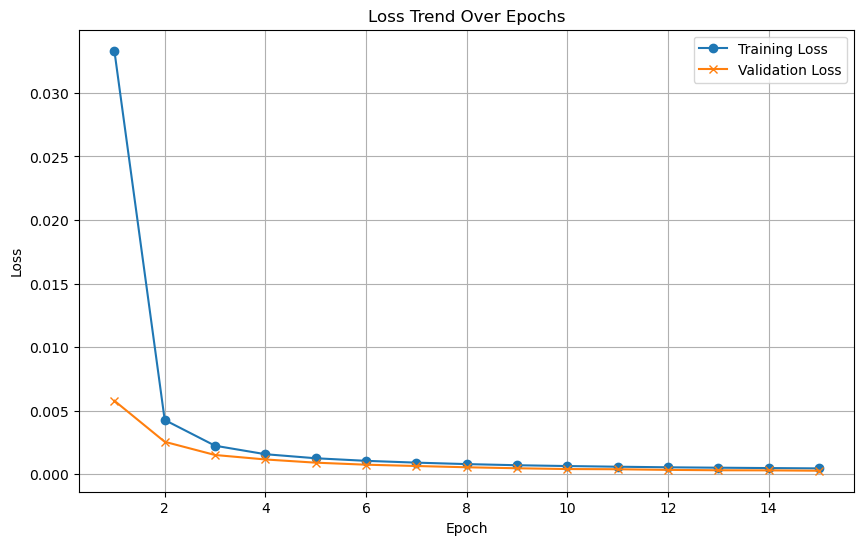

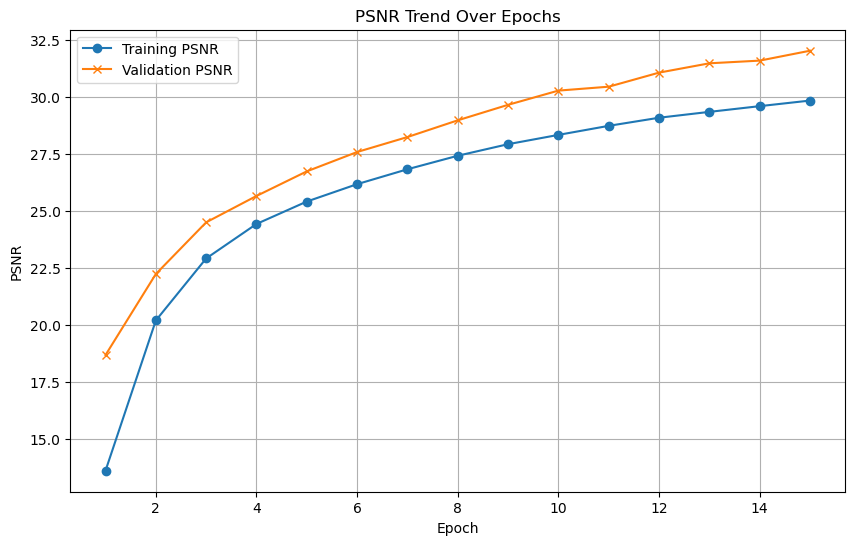

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/578 for test dataset.


    Processed batch 101/578 for test dataset.


    Processed batch 201/578 for test dataset.


    Processed batch 301/578 for test dataset.


    Processed batch 401/578 for test dataset.


    Processed batch 501/578 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2029
    Validation Batch [1/1], Loss: 2.2028
Validation Loss: 2.2028, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2028. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1228
    Validation Batch [1/1], Loss: 2.2028
Validation Loss: 2.2028, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.0804
    Validation Batch [1/1], Loss: 2.2028
Validation Loss: 2.2028, Validation Accuracy: 11.11%
Validation loss improved from 2.2028 to 2.2028. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0454
    Validation Batch [1/1], Loss: 2.2027
Validation Loss: 2.2027, Validation Accuracy: 11.11%
Validation loss improved from 2.2028 to 2.2027. Saving model...

LOG: Epoch [5/1000] - Training


Epoch [5/1000] completed, Average Training Loss: 2.0190
    Validation Batch [1/1], Loss: 2.2027
Validation Loss: 2.2027, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [6/1000] - Training
Epoch [6/1000] completed, Average Training Loss: 1.9931
    Validation Batch [1/1], Loss: 2.2025
Validation Loss: 2.2025, Validation Accuracy: 11.11%
Validation loss improved from 2.2027 to 2.2025. Saving model...

LOG: Epoch [7/1000] - Training
Epoch [7/1000] completed, Average Training Loss: 1.9645
    Validation Batch [1/1], Loss: 2.2020
Validation Loss: 2.2020, Validation Accuracy: 11.11%
Validation loss improved from 2.2025 to 2.2020. Saving model...

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 1.9277
    Validation Batch [1/1], Loss: 2.2015
Validation Loss: 2.2015, Validation Accuracy: 11.11%
Validation loss improved from 2.2020 to 2.2015. Saving model...

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Avera

Epoch [22/1000] completed, Average Training Loss: 1.5998
    Validation Batch [1/1], Loss: 1.9154
Validation Loss: 1.9154, Validation Accuracy: 42.22%
Validation loss improved from 1.9665 to 1.9154. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.5797
    Validation Batch [1/1], Loss: 1.8626
Validation Loss: 1.8626, Validation Accuracy: 42.22%
Validation loss improved from 1.9154 to 1.8626. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 1.5717
    Validation Batch [1/1], Loss: 1.8168
Validation Loss: 1.8168, Validation Accuracy: 48.89%
Validation loss improved from 1.8626 to 1.8168. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 1.5521
    Validation Batch [1/1], Loss: 1.7740
Validation Loss: 1.7740, Validation Accuracy: 53.33%
Validation loss improved from 1.8168 to 1.7740. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [2

Epoch [40/1000] completed, Average Training Loss: 1.3168
    Validation Batch [1/1], Loss: 1.2581
Validation Loss: 1.2581, Validation Accuracy: 91.11%
Validation loss improved from 1.2920 to 1.2581. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.2872
    Validation Batch [1/1], Loss: 1.2452
Validation Loss: 1.2452, Validation Accuracy: 91.11%
Validation loss improved from 1.2581 to 1.2452. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 1.2639
    Validation Batch [1/1], Loss: 1.2447
Validation Loss: 1.2447, Validation Accuracy: 88.89%
Validation loss improved from 1.2452 to 1.2447. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 1.2514
    Validation Batch [1/1], Loss: 1.2037
Validation Loss: 1.2037, Validation Accuracy: 91.11%
Validation loss improved from 1.2447 to 1.2037. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [4

Epoch [58/1000] completed, Average Training Loss: 1.0209
    Validation Batch [1/1], Loss: 0.9878
Validation Loss: 0.9878, Validation Accuracy: 93.33%
Validation loss improved from 0.9944 to 0.9878. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 1.0067
    Validation Batch [1/1], Loss: 0.9638
Validation Loss: 0.9638, Validation Accuracy: 95.56%
Validation loss improved from 0.9878 to 0.9638. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [60/1000] completed, Average Training Loss: 0.9994
    Validation Batch [1/1], Loss: 0.9807
Validation Loss: 0.9807, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 0.9813
    Validation Batch [1/1], Loss: 0.9327
Validation Loss: 0.9327, Validation Accuracy: 97.78%
Validation loss improved from 0.9638 to 0.9327. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] complet

Epoch [73/1000] completed, Average Training Loss: 0.8091
    Validation Batch [1/1], Loss: 0.8002
Validation Loss: 0.8002, Validation Accuracy: 93.33%
Validation loss improved from 0.8118 to 0.8002. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 0.7882
    Validation Batch [1/1], Loss: 0.7555
Validation Loss: 0.7555, Validation Accuracy: 97.78%
Validation loss improved from 0.8002 to 0.7555. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 0.8021
    Validation Batch [1/1], Loss: 0.7768
Validation Loss: 0.7768, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 0.7664
    Validation Batch [1/1], Loss: 0.7765
Validation Loss: 0.7765, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Tra

Epoch [89/1000] completed, Average Training Loss: 0.6249
    Validation Batch [1/1], Loss: 0.6011
Validation Loss: 0.6011, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 0.5985
    Validation Batch [1/1], Loss: 0.5554
Validation Loss: 0.5554, Validation Accuracy: 97.78%
Validation loss improved from 0.5915 to 0.5554. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 0.5777
    Validation Batch [1/1], Loss: 0.5631
Validation Loss: 0.5631, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Training Loss: 0.5668
    Validation Batch [1/1], Loss: 0.5492
Validation Loss: 0.5492, Validation Accuracy: 97.78%
Validation loss improved from 0.5554 to 0.5492. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [93/1000] completed, Average Tra

Epoch [105/1000] completed, Average Training Loss: 0.4171
    Validation Batch [1/1], Loss: 0.4400
Validation Loss: 0.4400, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 0.4196
    Validation Batch [1/1], Loss: 0.4234
Validation Loss: 0.4234, Validation Accuracy: 95.56%
Validation loss improved from 0.4237 to 0.4234. Saving model...

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 0.4004
    Validation Batch [1/1], Loss: 0.3914
Validation Loss: 0.3914, Validation Accuracy: 97.78%
Validation loss improved from 0.4234 to 0.3914. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 0.3988
    Validation Batch [1/1], Loss: 0.3724
Validation Loss: 0.3724, Validation Accuracy: 97.78%
Validation loss improved from 0.3914 to 0.3724. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000

Epoch [120/1000] completed, Average Training Loss: 0.3102
    Validation Batch [1/1], Loss: 0.2938
Validation Loss: 0.2938, Validation Accuracy: 95.56%
Validation loss improved from 0.3120 to 0.2938. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 0.2939
    Validation Batch [1/1], Loss: 0.3179
Validation Loss: 0.3179, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 0.2854
    Validation Batch [1/1], Loss: 0.3097
Validation Loss: 0.3097, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 0.2925
    Validation Batch [1/1], Loss: 0.2647
Validation Loss: 0.2647, Validation Accuracy: 97.78%
Validation loss improved from 0.2938 to 0.2647. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Av

Epoch [135/1000] completed, Average Training Loss: 0.2228
    Validation Batch [1/1], Loss: 0.2090
Validation Loss: 0.2090, Validation Accuracy: 97.78%
Validation loss improved from 0.2141 to 0.2090. Saving model...

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 0.2270
    Validation Batch [1/1], Loss: 0.2731
Validation Loss: 0.2731, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 0.2355
    Validation Batch [1/1], Loss: 0.2061
Validation Loss: 0.2061, Validation Accuracy: 97.78%
Validation loss improved from 0.2090 to 0.2061. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 0.2031
    Validation Batch [1/1], Loss: 0.2037
Validation Loss: 0.2037, Validation Accuracy: 97.78%
Validation loss improved from 0.2061 to 0.2037. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000

Epoch [151/1000] completed, Average Training Loss: 0.1661
    Validation Batch [1/1], Loss: 0.1770
Validation Loss: 0.1770, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 0.1710
    Validation Batch [1/1], Loss: 0.1919
Validation Loss: 0.1919, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.1625
    Validation Batch [1/1], Loss: 0.1873
Validation Loss: 0.1873, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.1656
    Validation Batch [1/1], Loss: 0.1713
Validation Loss: 0.1713, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 0.1617
  

Epoch [166/1000] completed, Average Training Loss: 0.1348
    Validation Batch [1/1], Loss: 0.1475
Validation Loss: 0.1475, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 0.1442
    Validation Batch [1/1], Loss: 0.1262
Validation Loss: 0.1262, Validation Accuracy: 97.78%
Validation loss improved from 0.1460 to 0.1262. Saving model...

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 0.1321
    Validation Batch [1/1], Loss: 0.1336
Validation Loss: 0.1336, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 0.1210
    Validation Batch [1/1], Loss: 0.1519
Validation Loss: 0.1519, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training

    Validation Batch [1/1], Loss: 0.1332
Validation Loss: 0.1332, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 0.0987
    Validation Batch [1/1], Loss: 0.1456
Validation Loss: 0.1456, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 0.1179
    Validation Batch [1/1], Loss: 0.1640
Validation Loss: 0.1640, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 0.1074
    Validation Batch [1/1], Loss: 0.1250
Validation Loss: 0.1250, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 0.1098
    Validation Batch [1/1], Loss: 0.1233
Validation Loss: 0.

Epoch [197/1000] completed, Average Training Loss: 0.0808
    Validation Batch [1/1], Loss: 0.1376
Validation Loss: 0.1376, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.0880
    Validation Batch [1/1], Loss: 0.1161
Validation Loss: 0.1161, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.0847
    Validation Batch [1/1], Loss: 0.0892
Validation Loss: 0.0892, Validation Accuracy: 97.78%
Validation loss improved from 0.1045 to 0.0892. Saving model...

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.0793
    Validation Batch [1/1], Loss: 0.1051
Validation Loss: 0.1051, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training 

Epoch [214/1000] completed, Average Training Loss: 0.0727
    Validation Batch [1/1], Loss: 0.0988
Validation Loss: 0.0988, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.0701
    Validation Batch [1/1], Loss: 0.0887
Validation Loss: 0.0887, Validation Accuracy: 97.78%
Validation loss improved from 0.0892 to 0.0887. Saving model...

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.0645
    Validation Batch [1/1], Loss: 0.0867
Validation Loss: 0.0867, Validation Accuracy: 97.78%
Validation loss improved from 0.0887 to 0.0867. Saving model...

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.0628
    Validation Batch [1/1], Loss: 0.0932
Validation Loss: 0.0932, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, A

Epoch [231/1000] completed, Average Training Loss: 0.0547
    Validation Batch [1/1], Loss: 0.1042
Validation Loss: 0.1042, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.0582
    Validation Batch [1/1], Loss: 0.0797
Validation Loss: 0.0797, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.0603
    Validation Batch [1/1], Loss: 0.0802
Validation Loss: 0.0802, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.0561
    Validation Batch [1/1], Loss: 0.0970
Validation Loss: 0.0970, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.0550
  

Epoch [247/1000] completed, Average Training Loss: 0.0474
    Validation Batch [1/1], Loss: 0.0578
Validation Loss: 0.0578, Validation Accuracy: 100.00%
Validation loss improved from 0.0777 to 0.0578. Saving model...

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.0447
    Validation Batch [1/1], Loss: 0.0653
Validation Loss: 0.0653, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.0499
    Validation Batch [1/1], Loss: 0.0928
Validation Loss: 0.0928, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.0527
    Validation Batch [1/1], Loss: 0.1454
Validation Loss: 0.1454, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training

    Validation Batch [1/1], Loss: 0.0966
Validation Loss: 0.0966, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.0445
    Validation Batch [1/1], Loss: 0.0755
Validation Loss: 0.0755, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Training Loss: 0.0433
    Validation Batch [1/1], Loss: 0.0585
Validation Loss: 0.0585, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training Loss: 0.0414
    Validation Batch [1/1], Loss: 0.0726
Validation Loss: 0.0726, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.1019
Validation Loss

Epoch [279/1000] completed, Average Training Loss: 0.0379
    Validation Batch [1/1], Loss: 0.0616
Validation Loss: 0.0616, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.0697
Validation Loss: 0.0697, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.0407
    Validation Batch [1/1], Loss: 0.1134
Validation Loss: 0.1134, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.0410
    Validation Batch [1/1], Loss: 0.0813
Validation Loss: 0.0813, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.035

Epoch [298/1000] completed, Average Training Loss: 0.0274
    Validation Batch [1/1], Loss: 0.0641
Validation Loss: 0.0641, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.0278
    Validation Batch [1/1], Loss: 0.0616
Validation Loss: 0.0616, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.0309
    Validation Batch [1/1], Loss: 0.0651
Validation Loss: 0.0651, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.0312
    Validation Batch [1/1], Loss: 0.0642
Validation Loss: 0.0642, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.0274
  

    Validation Batch [1/1], Loss: 0.0477
Validation Loss: 0.0477, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.0234
    Validation Batch [1/1], Loss: 0.0420
Validation Loss: 0.0420, Validation Accuracy: 97.78%
Validation loss improved from 0.0474 to 0.0420. Saving model...

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.0273
    Validation Batch [1/1], Loss: 0.0432
Validation Loss: 0.0432, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.0248
    Validation Batch [1/1], Loss: 0.0762
Validation Loss: 0.0762, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.0258
    Validation Batch [1/1], Loss: 0.0798
Val

Epoch [333/1000] completed, Average Training Loss: 0.0229
    Validation Batch [1/1], Loss: 0.1140
Validation Loss: 0.1140, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.0258
    Validation Batch [1/1], Loss: 0.1483
Validation Loss: 0.1483, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.0248
    Validation Batch [1/1], Loss: 0.1342
Validation Loss: 0.1342, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.0220
    Validation Batch [1/1], Loss: 0.0791
Validation Loss: 0.0791, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.024

Epoch [351/1000] completed, Average Training Loss: 0.0208
    Validation Batch [1/1], Loss: 0.0620
Validation Loss: 0.0620, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training Loss: 0.0201
    Validation Batch [1/1], Loss: 0.0679
Validation Loss: 0.0679, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.0276
    Validation Batch [1/1], Loss: 0.0596
Validation Loss: 0.0596, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.0228
    Validation Batch [1/1], Loss: 0.0534
Validation Loss: 0.0534, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.0211
  

Epoch [367/1000] completed, Average Training Loss: 0.0242
    Validation Batch [1/1], Loss: 0.0923
Validation Loss: 0.0923, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.0172
    Validation Batch [1/1], Loss: 0.0978
Validation Loss: 0.0978, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.0268
    Validation Batch [1/1], Loss: 0.0944
Validation Loss: 0.0944, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.0175
    Validation Batch [1/1], Loss: 0.0826
Validation Loss: 0.0826, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.019

Epoch [384/1000] completed, Average Training Loss: 0.0161
    Validation Batch [1/1], Loss: 0.0773
Validation Loss: 0.0773, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.0216
    Validation Batch [1/1], Loss: 0.0641
Validation Loss: 0.0641, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.0207
    Validation Batch [1/1], Loss: 0.0571
Validation Loss: 0.0571, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.0165
    Validation Batch [1/1], Loss: 0.0596
Validation Loss: 0.0596, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.0206
  

Epoch [402/1000] completed, Average Training Loss: 0.0120
    Validation Batch [1/1], Loss: 0.1648
Validation Loss: 0.1648, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.0170
    Validation Batch [1/1], Loss: 0.1284
Validation Loss: 0.1284, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.0180
    Validation Batch [1/1], Loss: 0.0834
Validation Loss: 0.0834, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.0135
    Validation Batch [1/1], Loss: 0.0833
Validation Loss: 0.0833, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.015

Epoch [420/1000] completed, Average Training Loss: 0.0192
    Validation Batch [1/1], Loss: 0.0744
Validation Loss: 0.0744, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.0125
    Validation Batch [1/1], Loss: 0.1776
Validation Loss: 0.1776, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.0134
    Validation Batch [1/1], Loss: 0.1455
Validation Loss: 0.1455, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.0129
    Validation Batch [1/1], Loss: 0.0658
Validation Loss: 0.0658, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.0124
  

Epoch [438/1000] completed, Average Training Loss: 0.0152
    Validation Batch [1/1], Loss: 0.0510
Validation Loss: 0.0510, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.0099
    Validation Batch [1/1], Loss: 0.0568
Validation Loss: 0.0568, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.0117
    Validation Batch [1/1], Loss: 0.0589
Validation Loss: 0.0589, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.0155
    Validation Batch [1/1], Loss: 0.0587
Validation Loss: 0.0587, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.013

Epoch [456/1000] completed, Average Training Loss: 0.0104
    Validation Batch [1/1], Loss: 0.0688
Validation Loss: 0.0688, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.0087
    Validation Batch [1/1], Loss: 0.0644
Validation Loss: 0.0644, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.0124
    Validation Batch [1/1], Loss: 0.0562
Validation Loss: 0.0562, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.0138
    Validation Batch [1/1], Loss: 0.0520
Validation Loss: 0.0520, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.011

    Validation Batch [1/1], Loss: 0.0391
Validation Loss: 0.0391, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.0125
    Validation Batch [1/1], Loss: 0.0411
Validation Loss: 0.0411, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.0106
    Validation Batch [1/1], Loss: 0.0439
Validation Loss: 0.0439, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [475/1000] - Training
Epoch [475/1000] completed, Average Training Loss: 0.0099
    Validation Batch [1/1], Loss: 0.0544
Validation Loss: 0.0544, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.0103
    Validation Batch [1/1], Loss: 0.0862
Validation Loss

Epoch [490/1000] completed, Average Training Loss: 0.0137
    Validation Batch [1/1], Loss: 0.0815
Validation Loss: 0.0815, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.0129
    Validation Batch [1/1], Loss: 0.1013
Validation Loss: 0.1013, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.0103
    Validation Batch [1/1], Loss: 0.0592
Validation Loss: 0.0592, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0096
    Validation Batch [1/1], Loss: 0.0497
Validation Loss: 0.0497, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.009

Epoch [507/1000] completed, Average Training Loss: 0.0096
    Validation Batch [1/1], Loss: 0.0638
Validation Loss: 0.0638, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [508/1000] - Training
Epoch [508/1000] completed, Average Training Loss: 0.0090
    Validation Batch [1/1], Loss: 0.0556
Validation Loss: 0.0556, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.0095
    Validation Batch [1/1], Loss: 0.0596
Validation Loss: 0.0596, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.0080
    Validation Batch [1/1], Loss: 0.0801
Validation Loss: 0.0801, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.008

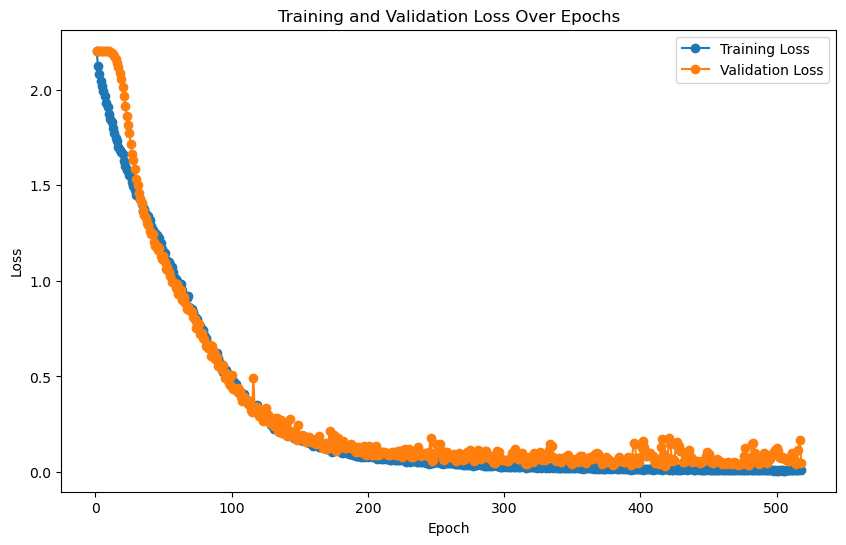

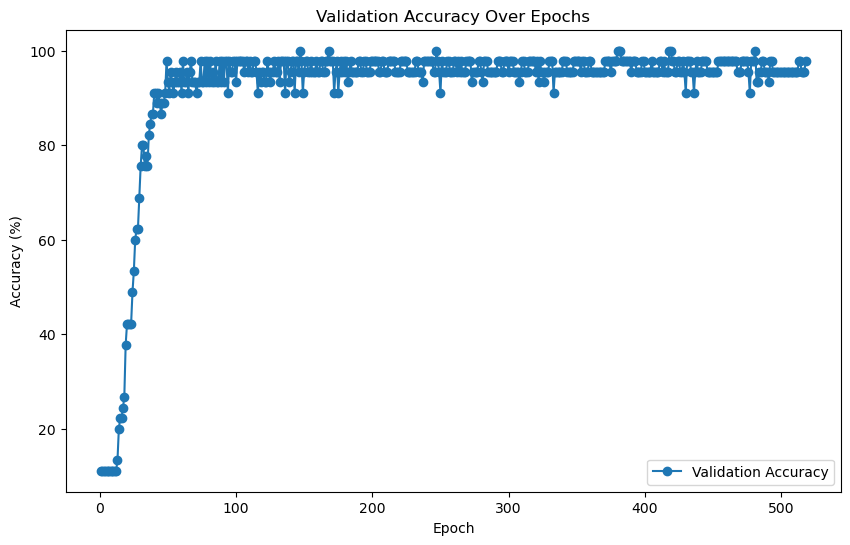


Evaluating on the test set...
    Test Batch [1/578], Loss: 0.0973



Final Test Loss: 0.0527, Test Accuracy: 98.84%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.


  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.
  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.


  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.
  Processed batch 130/578 for test dataset.


  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.


  Processed batch 190/578 for test dataset.
  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.


  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.


  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.


  Processed batch 340/578 for test dataset.
  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.


  Processed batch 390/578 for test dataset.
  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.


  Processed batch 440/578 for test dataset.
  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.


  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.


  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)

LOG: Training features shape: (360, 64), Training labels shape: (360,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (147747, 64), Test labels shape: (147747,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 93.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.80      0.80      0.80         5
           4       0.83      1.00      0.91         5
           5       0.80      0.80      0.80         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       1.00    


Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65926
           1       0.93      0.81      0.87      7553
           2       0.63      0.86      0.73      3045
           3       0.74      0.66      0.70      2640
           4       0.79      0.94      0.86      6539
           5       0.90      0.93      0.91      9203
           6       0.91      0.90      0.91      7242
           7       0.99      0.97      0.98     42781
           8       0.94      0.99      0.96      2818

    accuracy                           0.96    147747
   macro avg       0.87      0.89      0.88    147747
weighted avg       0.96      0.96      0.96    147747

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)
Train reps shape: (360, 64)
Train labels shape: (360,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (147747, 64)
Test labels shape: (147747,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2977  |  Val Loss: 1.9715
Validation loss improved from inf to 1.9715.


[Epoch 2/1000] Train Loss: 1.8322  |  Val Loss: 1.6546
Validation loss improved from 1.9715 to 1.6546.
[Epoch 3/1000] Train Loss: 1.5621  |  Val Loss: 1.4291
Validation loss improved from 1.6546 to 1.4291.
[Epoch 4/1000] Train Loss: 1.3388  |  Val Loss: 1.2339
Validation loss improved from 1.4291 to 1.2339.
[Epoch 5/1000] Train Loss: 1.1428  |  Val Loss: 1.0460
Validation loss improved from 1.2339 to 1.0460.
[Epoch 6/1000] Train Loss: 0.9588  |  Val Loss: 0.8797
Validation loss improved from 1.0460 to 0.8797.
[Epoch 7/1000] Train Loss: 0.7907  |  Val Loss: 0.7414
Validation loss improved from 0.8797 to 0.7414.
[Epoch 8/1000] Train Loss: 0.6476  |  Val Loss: 0.6122
Validation loss improved from 0.7414 to 0.6122.
[Epoch 9/1000] Train Loss: 0.5347  |  Val Loss: 0.5303
Validation loss improved from 0.6122 to 0.5303.
[Epoch 10/1000] Train Loss: 0.4536  |  Val Loss: 0.4703
Validation loss improved from 0.5303 to 0.4703.
[Epoch 11/1000] Train Loss: 0.3877  |  Val Loss: 0.4313
Validation loss 

[Epoch 19/1000] Train Loss: 0.2096  |  Val Loss: 0.3088
Validation loss improved from 0.3299 to 0.3088.
[Epoch 20/1000] Train Loss: 0.1992  |  Val Loss: 0.3109
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 21/1000] Train Loss: 0.1993  |  Val Loss: 0.3087
Validation loss improved from 0.3088 to 0.3087.
[Epoch 22/1000] Train Loss: 0.1812  |  Val Loss: 0.2933
Validation loss improved from 0.3087 to 0.2933.
[Epoch 23/1000] Train Loss: 0.1733  |  Val Loss: 0.3023
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 24/1000] Train Loss: 0.1619  |  Val Loss: 0.2932
Validation loss improved from 0.2933 to 0.2932.
[Epoch 25/1000] Train Loss: 0.1570  |  Val Loss: 0.2830
Validation loss improved from 0.2932 to 0.2830.
[Epoch 26/1000] Train Loss: 0.1560  |  Val Loss: 0.2909
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 0.1520  |  Val Loss: 0.2846
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 28/1000] Train Loss: 0.1387  |  V

[Epoch 36/1000] Train Loss: 0.1169  |  Val Loss: 0.2468
Validation loss improved from 0.2541 to 0.2468.
[Epoch 37/1000] Train Loss: 0.1044  |  Val Loss: 0.2787
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 38/1000] Train Loss: 0.1081  |  Val Loss: 0.2389
Validation loss improved from 0.2468 to 0.2389.
[Epoch 39/1000] Train Loss: 0.1016  |  Val Loss: 0.2475
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 0.0953  |  Val Loss: 0.2470
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 41/1000] Train Loss: 0.0934  |  Val Loss: 0.2500
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 42/1000] Train Loss: 0.0956  |  Val Loss: 0.2248
Validation loss improved from 0.2389 to 0.2248.
[Epoch 43/1000] Train Loss: 0.0898  |  Val Loss: 0.2691
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 0.0943  |  Val Loss: 0.2365
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 45/1000] Train Loss: 

[Epoch 52/1000] Train Loss: 0.0727  |  Val Loss: 0.2150
Validation loss improved from 0.2163 to 0.2150.
[Epoch 53/1000] Train Loss: 0.0724  |  Val Loss: 0.2188
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 54/1000] Train Loss: 0.0726  |  Val Loss: 0.2239
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 55/1000] Train Loss: 0.0648  |  Val Loss: 0.2088
Validation loss improved from 0.2150 to 0.2088.
[Epoch 56/1000] Train Loss: 0.0646  |  Val Loss: 0.2224
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 0.0613  |  Val Loss: 0.2342
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 58/1000] Train Loss: 0.0581  |  Val Loss: 0.2019
Validation loss improved from 0.2088 to 0.2019.
[Epoch 59/1000] Train Loss: 0.0606  |  Val Loss: 0.2261
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 0.0530  |  Val Loss: 0.2087
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 61/1000] Train Loss: 

[Epoch 67/1000] Train Loss: 0.0480  |  Val Loss: 0.2143
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 68/1000] Train Loss: 0.0492  |  Val Loss: 0.2160
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 69/1000] Train Loss: 0.0454  |  Val Loss: 0.2130
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 70/1000] Train Loss: 0.0484  |  Val Loss: 0.2059
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 71/1000] Train Loss: 0.0501  |  Val Loss: 0.2095
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 72/1000] Train Loss: 0.0426  |  Val Loss: 0.2107
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 73/1000] Train Loss: 0.0397  |  Val Loss: 0.2213
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 74/1000] Train Loss: 0.0438  |  Val Loss: 0.2122
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 75/1000] Train Loss: 0.0474  |  Val Loss: 0.2021
!! Validation loss did NOT improve !! Patience: 17/100
[E

[Epoch 85/1000] Train Loss: 0.0346  |  Val Loss: 0.2055
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 86/1000] Train Loss: 0.0540  |  Val Loss: 0.2882
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 87/1000] Train Loss: 0.0655  |  Val Loss: 0.2042
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 88/1000] Train Loss: 0.0584  |  Val Loss: 0.2604
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 89/1000] Train Loss: 0.0352  |  Val Loss: 0.2255
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 90/1000] Train Loss: 0.0265  |  Val Loss: 0.1946
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 91/1000] Train Loss: 0.0248  |  Val Loss: 0.2031
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 92/1000] Train Loss: 0.0235  |  Val Loss: 0.1997
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 93/1000] Train Loss: 0.0226  |  Val Loss: 0.2109
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 9

[Epoch 103/1000] Train Loss: 0.0162  |  Val Loss: 0.2169
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 104/1000] Train Loss: 0.0156  |  Val Loss: 0.2068
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 105/1000] Train Loss: 0.0153  |  Val Loss: 0.2083
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 106/1000] Train Loss: 0.0150  |  Val Loss: 0.1953
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 107/1000] Train Loss: 0.0144  |  Val Loss: 0.2099
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 108/1000] Train Loss: 0.0134  |  Val Loss: 0.2268
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 109/1000] Train Loss: 0.0134  |  Val Loss: 0.2037
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 110/1000] Train Loss: 0.0162  |  Val Loss: 0.2155
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 111/1000] Train Loss: 0.0144  |  Val Loss: 0.2299
!! Validation loss did NOT improve !! Patience:

[Epoch 119/1000] Train Loss: 0.0110  |  Val Loss: 0.2045
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 120/1000] Train Loss: 0.0104  |  Val Loss: 0.2071
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 121/1000] Train Loss: 0.0099  |  Val Loss: 0.2144
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 122/1000] Train Loss: 0.0105  |  Val Loss: 0.2151
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 123/1000] Train Loss: 0.0102  |  Val Loss: 0.2357
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 124/1000] Train Loss: 0.0099  |  Val Loss: 0.2020
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 125/1000] Train Loss: 0.0088  |  Val Loss: 0.2340
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 126/1000] Train Loss: 0.0093  |  Val Loss: 0.2103
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 127/1000] Train Loss: 0.0085  |  Val Loss: 0.2201
!! Validation loss did NOT improve !! Patience:

[Epoch 137/1000] Train Loss: 0.0080  |  Val Loss: 0.2120
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 138/1000] Train Loss: 0.0069  |  Val Loss: 0.2116
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 139/1000] Train Loss: 0.0067  |  Val Loss: 0.2227
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 140/1000] Train Loss: 0.0065  |  Val Loss: 0.2145
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 141/1000] Train Loss: 0.0064  |  Val Loss: 0.2199
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 142/1000] Train Loss: 0.0060  |  Val Loss: 0.2234
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 143/1000] Train Loss: 0.0060  |  Val Loss: 0.2251
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 144/1000] Train Loss: 0.0058  |  Val Loss: 0.2165
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 145/1000] Train Loss: 0.0061  |  Val Loss: 0.2215
!! Validation loss did NOT improve !! Patience:

[Epoch 152/1000] Train Loss: 0.0052  |  Val Loss: 0.2354
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 153/1000] Train Loss: 0.0050  |  Val Loss: 0.2190
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 154/1000] Train Loss: 0.0048  |  Val Loss: 0.2279
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 155/1000] Train Loss: 0.0050  |  Val Loss: 0.2179
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 156/1000] Train Loss: 0.0050  |  Val Loss: 0.2295
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 157/1000] Train Loss: 0.0048  |  Val Loss: 0.2228
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 158/1000] Train Loss: 0.0046  |  Val Loss: 0.2374
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 159/1000] Train Loss: 0.0048  |  Val Loss: 0.2094
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 160/1000] Train Loss: 0.0052  |  Val Loss: 0.2281
!! Validation loss did NOT improve !! Patience:

[Epoch 169/1000] Train Loss: 0.0039  |  Val Loss: 0.2292
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 170/1000] Train Loss: 0.0036  |  Val Loss: 0.2408
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 171/1000] Train Loss: 0.0037  |  Val Loss: 0.2236
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 172/1000] Train Loss: 0.0034  |  Val Loss: 0.2330
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 173/1000] Train Loss: 0.0034  |  Val Loss: 0.2274
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 174/1000] Train Loss: 0.0034  |  Val Loss: 0.2232
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 175/1000] Train Loss: 0.0033  |  Val Loss: 0.2325
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 176/1000] Train Loss: 0.0033  |  Val Loss: 0.2323
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 177/1000] Train Loss: 0.0033  |  Val Loss: 0.2225
!! Validation loss did NOT improve !! Patience:

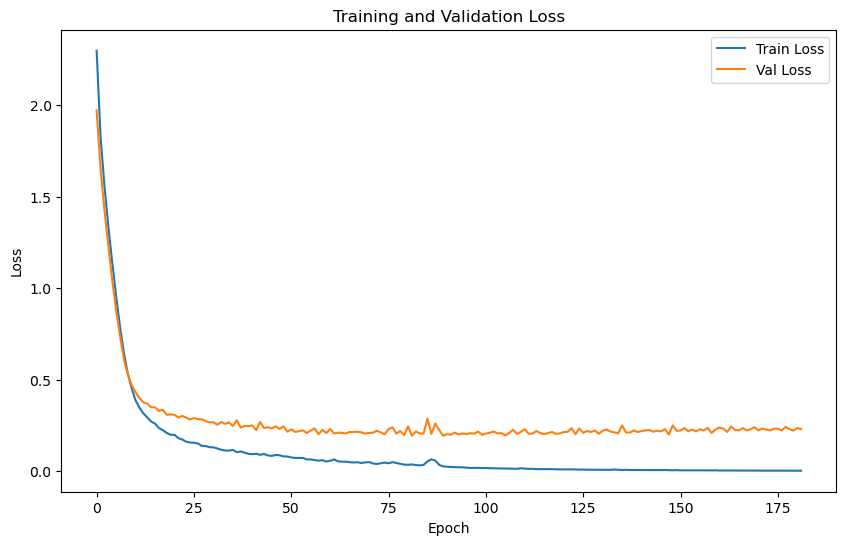

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.2050 | Test Accuracy: 96.07%


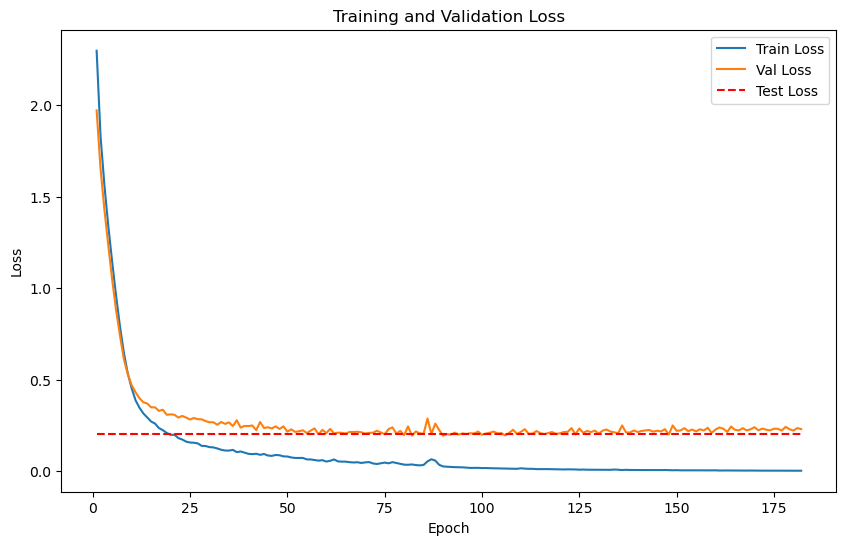

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147747, 64), 
Test labels shape: (147747,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 8.4080


    Batch [2/2], Train Loss: 8.3210
Epoch [1/2000], Avg Train Loss: 8.3645
Epoch [1/2000], Avg Val Loss: 3.6331
Validation loss improved from inf to 3.6331. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 7.9766
    Batch [2/2], Train Loss: 8.0617
Epoch [2/2000], Avg Train Loss: 8.0191
Epoch [2/2000], Avg Val Loss: 3.5504
Validation loss improved from 3.6331 to 3.5504. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 7.9894
    Batch [2/2], Train Loss: 7.8547
Epoch [3/2000], Avg Train Loss: 7.9220
Epoch [3/2000], Avg Val Loss: 3.4723
Validation loss improved from 3.5504 to 3.4723. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 7.9157
    Batch [2/2], Train Loss: 7.7224
Epoch [4/2000], Avg Train Loss: 7.8191
Epoch [4/2000], Avg Val Loss: 3.3995
Validation loss improved from 3.4723 to 3.3995. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 7.8523
    Batch [2/2], Train Loss

Epoch [9/2000], Avg Val Loss: 3.0983
Validation loss improved from 3.1501 to 3.0983. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 7.2204
    Batch [2/2], Train Loss: 6.9818
Epoch [10/2000], Avg Train Loss: 7.1011
Epoch [10/2000], Avg Val Loss: 3.0500
Validation loss improved from 3.0983 to 3.0500. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 6.7453
    Batch [2/2], Train Loss: 6.8004
Epoch [11/2000], Avg Train Loss: 6.7729
Epoch [11/2000], Avg Val Loss: 3.0056
Validation loss improved from 3.0500 to 3.0056. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 6.7813
    Batch [2/2], Train Loss: 6.6442
Epoch [12/2000], Avg Train Loss: 6.7128
Epoch [12/2000], Avg Val Loss: 2.9645
Validation loss improved from 3.0056 to 2.9645. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 6.6779
    Batch [2/2], Train Loss: 6.6491
Epoch [13/2000], Avg Train Loss: 6.6635
Epoch [13/200

    Batch [2/2], Train Loss: 5.3415
Epoch [28/2000], Avg Train Loss: 5.3784
Epoch [28/2000], Avg Val Loss: 2.6257
Validation loss improved from 2.6354 to 2.6257. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 5.3596
    Batch [2/2], Train Loss: 5.2966
Epoch [29/2000], Avg Train Loss: 5.3281
Epoch [29/2000], Avg Val Loss: 2.6168
Validation loss improved from 2.6257 to 2.6168. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 5.3995
    Batch [2/2], Train Loss: 5.3357
Epoch [30/2000], Avg Train Loss: 5.3676
Epoch [30/2000], Avg Val Loss: 2.6086
Validation loss improved from 2.6168 to 2.6086. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 5.3173
    Batch [2/2], Train Loss: 5.3086
Epoch [31/2000], Avg Train Loss: 5.3130
Epoch [31/2000], Avg Val Loss: 2.6011
Validation loss improved from 2.6086 to 2.6011. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 5.3769
    Batch [2

    Batch [1/2], Train Loss: 5.1692
    Batch [2/2], Train Loss: 5.0806
Epoch [35/2000], Avg Train Loss: 5.1249
Epoch [35/2000], Avg Val Loss: 2.5771
Validation loss improved from 2.5824 to 2.5771. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.1437
    Batch [2/2], Train Loss: 5.0384
Epoch [36/2000], Avg Train Loss: 5.0910
Epoch [36/2000], Avg Val Loss: 2.5723
Validation loss improved from 2.5771 to 2.5723. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 5.1105
    Batch [2/2], Train Loss: 4.9806
Epoch [37/2000], Avg Train Loss: 5.0456
Epoch [37/2000], Avg Val Loss: 2.5678
Validation loss improved from 2.5723 to 2.5678. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 5.0619
    Batch [2/2], Train Loss: 5.1294
Epoch [38/2000], Avg Train Loss: 5.0957
Epoch [38/2000], Avg Val Loss: 2.5636
Validation loss improved from 2.5678 to 2.5636. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.5955
    Batch [2/2], Train Loss: 4.6463
Epoch [54/2000], Avg Train Loss: 4.6209
Epoch [54/2000], Avg Val Loss: 2.5228
Validation loss improved from 2.5248 to 2.5228. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 4.6733
    Batch [2/2], Train Loss: 4.6385
Epoch [55/2000], Avg Train Loss: 4.6559
Epoch [55/2000], Avg Val Loss: 2.5209
Validation loss improved from 2.5228 to 2.5209. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 4.6184
    Batch [2/2], Train Loss: 4.6939
Epoch [56/2000], Avg Train Loss: 4.6561
Epoch [56/2000], Avg Val Loss: 2.5191
Validation loss improved from 2.5209 to 2.5191. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 4.5935
    Batch [2/2], Train Loss: 4.6790
Epoch [57/2000], Avg Train Loss: 4.6362
Epoch [57/2000], Avg Val Loss: 2.5173
Validation loss improved from 2.5191 to 2.5173. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.6273
Epoch [61/2000], Avg Train Loss: 4.6235
Epoch [61/2000], Avg Val Loss: 2.5104
Validation loss improved from 2.5121 to 2.5104. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 4.5317
    Batch [2/2], Train Loss: 4.5426
Epoch [62/2000], Avg Train Loss: 4.5371
Epoch [62/2000], Avg Val Loss: 2.5088
Validation loss improved from 2.5104 to 2.5088. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 4.5560
    Batch [2/2], Train Loss: 4.5206
Epoch [63/2000], Avg Train Loss: 4.5383
Epoch [63/2000], Avg Val Loss: 2.5071
Validation loss improved from 2.5088 to 2.5071. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 4.5551
    Batch [2/2], Train Loss: 4.5345
Epoch [64/2000], Avg Train Loss: 4.5448
Epoch [64/2000], Avg Val Loss: 2.5055
Validation loss improved from 2.5071 to 2.5055. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 4.5343
    Batch [2

    Batch [1/2], Train Loss: 4.5125
    Batch [2/2], Train Loss: 4.4082
Epoch [80/2000], Avg Train Loss: 4.4604
Epoch [80/2000], Avg Val Loss: 2.4798
Validation loss improved from 2.4815 to 2.4798. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 4.3767
    Batch [2/2], Train Loss: 4.4560
Epoch [81/2000], Avg Train Loss: 4.4163
Epoch [81/2000], Avg Val Loss: 2.4781
Validation loss improved from 2.4798 to 2.4781. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 4.4114
    Batch [2/2], Train Loss: 4.4225
Epoch [82/2000], Avg Train Loss: 4.4170
Epoch [82/2000], Avg Val Loss: 2.4766
Validation loss improved from 2.4781 to 2.4766. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 4.3925
    Batch [2/2], Train Loss: 4.3808
Epoch [83/2000], Avg Train Loss: 4.3866
Epoch [83/2000], Avg Val Loss: 2.4750
Validation loss improved from 2.4766 to 2.4750. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1

Epoch [88/2000], Avg Val Loss: 2.4671
Validation loss improved from 2.4687 to 2.4671. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 4.3403
    Batch [2/2], Train Loss: 4.2989
Epoch [89/2000], Avg Train Loss: 4.3196
Epoch [89/2000], Avg Val Loss: 2.4655
Validation loss improved from 2.4671 to 2.4655. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 4.3716
    Batch [2/2], Train Loss: 4.3678
Epoch [90/2000], Avg Train Loss: 4.3697
Epoch [90/2000], Avg Val Loss: 2.4639
Validation loss improved from 2.4655 to 2.4639. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 4.2578
    Batch [2/2], Train Loss: 4.3627
Epoch [91/2000], Avg Train Loss: 4.3102
Epoch [91/2000], Avg Val Loss: 2.4622
Validation loss improved from 2.4639 to 2.4622. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 4.3050
    Batch [2/2], Train Loss: 4.3406
Epoch [92/2000], Avg Train Loss: 4.3228
Epoch [92/20

    Batch [1/2], Train Loss: 4.2794
    Batch [2/2], Train Loss: 4.2154
Epoch [105/2000], Avg Train Loss: 4.2474
Epoch [105/2000], Avg Val Loss: 2.4391
Validation loss improved from 2.4408 to 2.4391. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/2], Train Loss: 4.2336
    Batch [2/2], Train Loss: 4.2514
Epoch [106/2000], Avg Train Loss: 4.2425
Epoch [106/2000], Avg Val Loss: 2.4374
Validation loss improved from 2.4391 to 2.4374. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 4.2711
    Batch [2/2], Train Loss: 4.2732
Epoch [107/2000], Avg Train Loss: 4.2722
Epoch [107/2000], Avg Val Loss: 2.4357
Validation loss improved from 2.4374 to 2.4357. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 4.2580
    Batch [2/2], Train Loss: 4.2571
Epoch [108/2000], Avg Train Loss: 4.2575
Epoch [108/2000], Avg Val Loss: 2.4339
Validation loss improved from 2.4357 to 2.4339. Saving model...

LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 4.1699
    Batch [2/2], Train Loss: 4.2533
Epoch [113/2000], Avg Train Loss: 4.2116
Epoch [113/2000], Avg Val Loss: 2.4254
Validation loss improved from 2.4271 to 2.4254. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 4.2428
    Batch [2/2], Train Loss: 4.2368
Epoch [114/2000], Avg Train Loss: 4.2398
Epoch [114/2000], Avg Val Loss: 2.4237
Validation loss improved from 2.4254 to 2.4237. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 4.2385
    Batch [2/2], Train Loss: 4.1835
Epoch [115/2000], Avg Train Loss: 4.2110
Epoch [115/2000], Avg Val Loss: 2.4220
Validation loss improved from 2.4237 to 2.4220. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 4.1865
    Batch [2/2], Train Loss: 4.2540
Epoch [116/2000], Avg Train Loss: 4.2203
Epoch [116/2000], Avg Val Loss: 2.4203
Validation loss improved from 2.4220 to 2.4203. Saving model...

LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 4.1669
    Batch [2/2], Train Loss: 4.1477
Epoch [131/2000], Avg Train Loss: 4.1573
Epoch [131/2000], Avg Val Loss: 2.3959
Validation loss improved from 2.3974 to 2.3959. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 4.1703
    Batch [2/2], Train Loss: 4.1645
Epoch [132/2000], Avg Train Loss: 4.1674
Epoch [132/2000], Avg Val Loss: 2.3943
Validation loss improved from 2.3959 to 2.3943. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 4.1315
    Batch [2/2], Train Loss: 4.1042
Epoch [133/2000], Avg Train Loss: 4.1178
Epoch [133/2000], Avg Val Loss: 2.3927
Validation loss improved from 2.3943 to 2.3927. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 4.1506
    Batch [2/2], Train Loss: 4.1534
Epoch [134/2000], Avg Train Loss: 4.1520
Epoch [134/2000], Avg Val Loss: 2.3910
Validation loss improved from 2.3927 to 2.3910. Saving model...

LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 4.0989
    Batch [2/2], Train Loss: 4.1262
Epoch [142/2000], Avg Train Loss: 4.1125
Epoch [142/2000], Avg Val Loss: 2.3782
Validation loss improved from 2.3798 to 2.3782. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 4.1591
    Batch [2/2], Train Loss: 4.0605
Epoch [143/2000], Avg Train Loss: 4.1098
Epoch [143/2000], Avg Val Loss: 2.3765
Validation loss improved from 2.3782 to 2.3765. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 4.1560
    Batch [2/2], Train Loss: 4.1140
Epoch [144/2000], Avg Train Loss: 4.1350
Epoch [144/2000], Avg Val Loss: 2.3749
Validation loss improved from 2.3765 to 2.3749. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 4.0530
    Batch [2/2], Train Loss: 4.1141
Epoch [145/2000], Avg Train Loss: 4.0835
Epoch [145/2000], Avg Val Loss: 2.3733
Validation loss improved from 2.3749 to 2.3733. Saving model...

LOG: Epoch [146/2000] - Training


    Batch [2/2], Train Loss: 4.0851
Epoch [156/2000], Avg Train Loss: 4.0945
Epoch [156/2000], Avg Val Loss: 2.3567
Validation loss improved from 2.3582 to 2.3567. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 4.0310
    Batch [2/2], Train Loss: 4.1080
Epoch [157/2000], Avg Train Loss: 4.0695
Epoch [157/2000], Avg Val Loss: 2.3552
Validation loss improved from 2.3567 to 2.3552. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 4.0891
    Batch [2/2], Train Loss: 4.0478
Epoch [158/2000], Avg Train Loss: 4.0685
Epoch [158/2000], Avg Val Loss: 2.3537
Validation loss improved from 2.3552 to 2.3537. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 4.1021
    Batch [2/2], Train Loss: 4.0711
Epoch [159/2000], Avg Train Loss: 4.0866
Epoch [159/2000], Avg Val Loss: 2.3522
Validation loss improved from 2.3537 to 2.3522. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 4.0527


    Batch [1/2], Train Loss: 4.0780
    Batch [2/2], Train Loss: 4.0551
Epoch [166/2000], Avg Train Loss: 4.0666
Epoch [166/2000], Avg Val Loss: 2.3413
Validation loss improved from 2.3428 to 2.3413. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 4.0635
    Batch [2/2], Train Loss: 4.0287
Epoch [167/2000], Avg Train Loss: 4.0461
Epoch [167/2000], Avg Val Loss: 2.3398
Validation loss improved from 2.3413 to 2.3398. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 4.0044
    Batch [2/2], Train Loss: 4.0337
Epoch [168/2000], Avg Train Loss: 4.0190
Epoch [168/2000], Avg Val Loss: 2.3383
Validation loss improved from 2.3398 to 2.3383. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 4.0108
    Batch [2/2], Train Loss: 4.0237
Epoch [169/2000], Avg Train Loss: 4.0172
Epoch [169/2000], Avg Val Loss: 2.3368
Validation loss improved from 2.3383 to 2.3368. Saving model...

LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 4.0261
    Batch [2/2], Train Loss: 4.0115
Epoch [180/2000], Avg Train Loss: 4.0188
Epoch [180/2000], Avg Val Loss: 2.3208
Validation loss improved from 2.3222 to 2.3208. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 3.9964
    Batch [2/2], Train Loss: 3.9708
Epoch [181/2000], Avg Train Loss: 3.9836
Epoch [181/2000], Avg Val Loss: 2.3194
Validation loss improved from 2.3208 to 2.3194. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 4.0286
    Batch [2/2], Train Loss: 4.0358
Epoch [182/2000], Avg Train Loss: 4.0322
Epoch [182/2000], Avg Val Loss: 2.3180
Validation loss improved from 2.3194 to 2.3180. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 3.9416
    Batch [2/2], Train Loss: 3.9325
Epoch [183/2000], Avg Train Loss: 3.9370
Epoch [183/2000], Avg Val Loss: 2.3167
Validation loss improved from 2.3180 to 2.3167. Saving model...

LOG: Epoch [184/2000] - Training


    Batch [1/2], Train Loss: 3.9843
    Batch [2/2], Train Loss: 3.9674
Epoch [191/2000], Avg Train Loss: 3.9758
Epoch [191/2000], Avg Val Loss: 2.3067
Validation loss improved from 2.3078 to 2.3067. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 3.9908
    Batch [2/2], Train Loss: 3.9793
Epoch [192/2000], Avg Train Loss: 3.9851
Epoch [192/2000], Avg Val Loss: 2.3055
Validation loss improved from 2.3067 to 2.3055. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 3.9610
    Batch [2/2], Train Loss: 3.9688
Epoch [193/2000], Avg Train Loss: 3.9649
Epoch [193/2000], Avg Val Loss: 2.3043
Validation loss improved from 2.3055 to 2.3043. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 3.9192
    Batch [2/2], Train Loss: 3.9757
Epoch [194/2000], Avg Train Loss: 3.9474
Epoch [194/2000], Avg Val Loss: 2.3031
Validation loss improved from 2.3043 to 2.3031. Saving model...

LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 3.9994
    Batch [2/2], Train Loss: 3.9282
Epoch [206/2000], Avg Train Loss: 3.9638
Epoch [206/2000], Avg Val Loss: 2.2875
Validation loss improved from 2.2887 to 2.2875. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 3.9726
    Batch [2/2], Train Loss: 4.0013
Epoch [207/2000], Avg Train Loss: 3.9869
Epoch [207/2000], Avg Val Loss: 2.2863
Validation loss improved from 2.2875 to 2.2863. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 3.9295
    Batch [2/2], Train Loss: 3.9422
Epoch [208/2000], Avg Train Loss: 3.9358
Epoch [208/2000], Avg Val Loss: 2.2851
Validation loss improved from 2.2863 to 2.2851. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 3.9514
    Batch [2/2], Train Loss: 3.9530
Epoch [209/2000], Avg Train Loss: 3.9522
Epoch [209/2000], Avg Val Loss: 2.2840
Validation loss improved from 2.2851 to 2.2840. Saving model...

LOG: Epoch [210/2000] - Training


    Batch [2/2], Train Loss: 3.8638
Epoch [219/2000], Avg Train Loss: 3.8819
Epoch [219/2000], Avg Val Loss: 2.2724
Validation loss improved from 2.2735 to 2.2724. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 3.8948
    Batch [2/2], Train Loss: 3.8663
Epoch [220/2000], Avg Train Loss: 3.8806
Epoch [220/2000], Avg Val Loss: 2.2714
Validation loss improved from 2.2724 to 2.2714. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 3.9253
    Batch [2/2], Train Loss: 3.8625
Epoch [221/2000], Avg Train Loss: 3.8939
Epoch [221/2000], Avg Val Loss: 2.2704
Validation loss improved from 2.2714 to 2.2704. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 3.8763
    Batch [2/2], Train Loss: 3.8725
Epoch [222/2000], Avg Train Loss: 3.8744
Epoch [222/2000], Avg Val Loss: 2.2693
Validation loss improved from 2.2704 to 2.2693. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 3.8787


    Batch [2/2], Train Loss: 3.8987
Epoch [232/2000], Avg Train Loss: 3.9072
Epoch [232/2000], Avg Val Loss: 2.2580
Validation loss improved from 2.2592 to 2.2580. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 3.9505
    Batch [2/2], Train Loss: 3.9296
Epoch [233/2000], Avg Train Loss: 3.9401
Epoch [233/2000], Avg Val Loss: 2.2569
Validation loss improved from 2.2580 to 2.2569. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 3.8814
    Batch [2/2], Train Loss: 3.9331
Epoch [234/2000], Avg Train Loss: 3.9073
Epoch [234/2000], Avg Val Loss: 2.2558
Validation loss improved from 2.2569 to 2.2558. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 3.9659
    Batch [2/2], Train Loss: 3.9352
Epoch [235/2000], Avg Train Loss: 3.9505
Epoch [235/2000], Avg Val Loss: 2.2547
Validation loss improved from 2.2558 to 2.2547. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 3.9109


    Batch [1/2], Train Loss: 3.8569
    Batch [2/2], Train Loss: 3.8721
Epoch [245/2000], Avg Train Loss: 3.8645
Epoch [245/2000], Avg Val Loss: 2.2447
Validation loss improved from 2.2456 to 2.2447. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 3.8692
    Batch [2/2], Train Loss: 3.8558
Epoch [246/2000], Avg Train Loss: 3.8625
Epoch [246/2000], Avg Val Loss: 2.2437
Validation loss improved from 2.2447 to 2.2437. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 3.8392
    Batch [2/2], Train Loss: 3.8643
Epoch [247/2000], Avg Train Loss: 3.8517
Epoch [247/2000], Avg Val Loss: 2.2428
Validation loss improved from 2.2437 to 2.2428. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 3.8164
    Batch [2/2], Train Loss: 3.8413
Epoch [248/2000], Avg Train Loss: 3.8288
Epoch [248/2000], Avg Val Loss: 2.2418
Validation loss improved from 2.2428 to 2.2418. Saving model...

LOG: Epoch [249/2000] - Training


    Batch [2/2], Train Loss: 3.8268
Epoch [256/2000], Avg Train Loss: 3.8516
Epoch [256/2000], Avg Val Loss: 2.2346
Validation loss improved from 2.2355 to 2.2346. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 3.8522
    Batch [2/2], Train Loss: 3.7534
Epoch [257/2000], Avg Train Loss: 3.8028
Epoch [257/2000], Avg Val Loss: 2.2338
Validation loss improved from 2.2346 to 2.2338. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 3.8566
    Batch [2/2], Train Loss: 3.8379
Epoch [258/2000], Avg Train Loss: 3.8473
Epoch [258/2000], Avg Val Loss: 2.2330
Validation loss improved from 2.2338 to 2.2330. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 3.8783
    Batch [2/2], Train Loss: 3.8535
Epoch [259/2000], Avg Train Loss: 3.8659
Epoch [259/2000], Avg Val Loss: 2.2323
Validation loss improved from 2.2330 to 2.2323. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 3.9023


Epoch [272/2000], Avg Train Loss: 3.8156
Epoch [272/2000], Avg Val Loss: 2.2207
Validation loss improved from 2.2216 to 2.2207. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 3.8448
    Batch [2/2], Train Loss: 3.8088
Epoch [273/2000], Avg Train Loss: 3.8268
Epoch [273/2000], Avg Val Loss: 2.2198
Validation loss improved from 2.2207 to 2.2198. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 3.8235
    Batch [2/2], Train Loss: 3.8767
Epoch [274/2000], Avg Train Loss: 3.8501
Epoch [274/2000], Avg Val Loss: 2.2189
Validation loss improved from 2.2198 to 2.2189. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 3.8400
    Batch [2/2], Train Loss: 3.7824
Epoch [275/2000], Avg Train Loss: 3.8112
Epoch [275/2000], Avg Val Loss: 2.2181
Validation loss improved from 2.2189 to 2.2181. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 3.8435
    Batch [2/2], Train Loss: 3.8216


    Batch [1/2], Train Loss: 3.7990
    Batch [2/2], Train Loss: 3.7514
Epoch [281/2000], Avg Train Loss: 3.7752
Epoch [281/2000], Avg Val Loss: 2.2132
Validation loss improved from 2.2140 to 2.2132. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/2], Train Loss: 3.7727
    Batch [2/2], Train Loss: 3.7782
Epoch [282/2000], Avg Train Loss: 3.7755
Epoch [282/2000], Avg Val Loss: 2.2124
Validation loss improved from 2.2132 to 2.2124. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 3.8829
    Batch [2/2], Train Loss: 3.7807
Epoch [283/2000], Avg Train Loss: 3.8318
Epoch [283/2000], Avg Val Loss: 2.2116
Validation loss improved from 2.2124 to 2.2116. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 3.7588
    Batch [2/2], Train Loss: 3.7831
Epoch [284/2000], Avg Train Loss: 3.7709
Epoch [284/2000], Avg Val Loss: 2.2108
Validation loss improved from 2.2116 to 2.2108. Saving model...

LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 3.7788
    Batch [2/2], Train Loss: 3.8055
Epoch [298/2000], Avg Train Loss: 3.7922
Epoch [298/2000], Avg Val Loss: 2.1995
Validation loss improved from 2.2002 to 2.1995. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 3.7898
    Batch [2/2], Train Loss: 3.7574
Epoch [299/2000], Avg Train Loss: 3.7736
Epoch [299/2000], Avg Val Loss: 2.1989
Validation loss improved from 2.1995 to 2.1989. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 3.7405
    Batch [2/2], Train Loss: 3.8120
Epoch [300/2000], Avg Train Loss: 3.7762
Epoch [300/2000], Avg Val Loss: 2.1984
Validation loss improved from 2.1989 to 2.1984. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 3.7693
    Batch [2/2], Train Loss: 3.7439
Epoch [301/2000], Avg Train Loss: 3.7566
Epoch [301/2000], Avg Val Loss: 2.1978
Validation loss improved from 2.1984 to 2.1978. Saving model...

LOG: Epoch [302/2000] - Training


    Batch [2/2], Train Loss: 3.7618
Epoch [307/2000], Avg Train Loss: 3.7651
Epoch [307/2000], Avg Val Loss: 2.1945
Validation loss improved from 2.1950 to 2.1945. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/2], Train Loss: 3.7106
    Batch [2/2], Train Loss: 3.7409
Epoch [308/2000], Avg Train Loss: 3.7257
Epoch [308/2000], Avg Val Loss: 2.1940
Validation loss improved from 2.1945 to 2.1940. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 3.7294
    Batch [2/2], Train Loss: 3.7514
Epoch [309/2000], Avg Train Loss: 3.7404
Epoch [309/2000], Avg Val Loss: 2.1934
Validation loss improved from 2.1940 to 2.1934. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 3.7467
    Batch [2/2], Train Loss: 3.7098
Epoch [310/2000], Avg Train Loss: 3.7282
Epoch [310/2000], Avg Val Loss: 2.1928
Validation loss improved from 2.1934 to 2.1928. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 3.7517


    Batch [1/2], Train Loss: 3.7638
    Batch [2/2], Train Loss: 3.7786
Epoch [312/2000], Avg Train Loss: 3.7712
Epoch [312/2000], Avg Val Loss: 2.1917
Validation loss improved from 2.1922 to 2.1917. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 3.7561
    Batch [2/2], Train Loss: 3.7092
Epoch [313/2000], Avg Train Loss: 3.7326
Epoch [313/2000], Avg Val Loss: 2.1911
Validation loss improved from 2.1917 to 2.1911. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 3.7504
    Batch [2/2], Train Loss: 3.7185
Epoch [314/2000], Avg Train Loss: 3.7344
Epoch [314/2000], Avg Val Loss: 2.1905
Validation loss improved from 2.1911 to 2.1905. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 3.6950
    Batch [2/2], Train Loss: 3.7774
Epoch [315/2000], Avg Train Loss: 3.7362
Epoch [315/2000], Avg Val Loss: 2.1900
Validation loss improved from 2.1905 to 2.1900. Saving model...

LOG: Epoch [316/2000] - Training


    Batch [2/2], Train Loss: 3.6949
Epoch [321/2000], Avg Train Loss: 3.7399
Epoch [321/2000], Avg Val Loss: 2.1873
Validation loss improved from 2.1878 to 2.1873. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 3.7497
    Batch [2/2], Train Loss: 3.7442
Epoch [322/2000], Avg Train Loss: 3.7469
Epoch [322/2000], Avg Val Loss: 2.1868
Validation loss improved from 2.1873 to 2.1868. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 3.7733
    Batch [2/2], Train Loss: 3.7382
Epoch [323/2000], Avg Train Loss: 3.7558
Epoch [323/2000], Avg Val Loss: 2.1863
Validation loss improved from 2.1868 to 2.1863. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 3.7325
    Batch [2/2], Train Loss: 3.7341
Epoch [324/2000], Avg Train Loss: 3.7333
Epoch [324/2000], Avg Val Loss: 2.1857
Validation loss improved from 2.1863 to 2.1857. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 3.6978


    Batch [2/2], Train Loss: 3.6875
Epoch [338/2000], Avg Train Loss: 3.7259
Epoch [338/2000], Avg Val Loss: 2.1770
Validation loss improved from 2.1775 to 2.1770. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 3.6931
    Batch [2/2], Train Loss: 3.7176
Epoch [339/2000], Avg Train Loss: 3.7053
Epoch [339/2000], Avg Val Loss: 2.1764
Validation loss improved from 2.1770 to 2.1764. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/2], Train Loss: 3.7536
    Batch [2/2], Train Loss: 3.7494
Epoch [340/2000], Avg Train Loss: 3.7515
Epoch [340/2000], Avg Val Loss: 2.1758
Validation loss improved from 2.1764 to 2.1758. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 3.7925
    Batch [2/2], Train Loss: 3.6944
Epoch [341/2000], Avg Train Loss: 3.7435
Epoch [341/2000], Avg Val Loss: 2.1753
Validation loss improved from 2.1758 to 2.1753. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 3.7209


    Batch [2/2], Train Loss: 3.6886
Epoch [346/2000], Avg Train Loss: 3.6940
Epoch [346/2000], Avg Val Loss: 2.1729
Validation loss improved from 2.1733 to 2.1729. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 3.7173
    Batch [2/2], Train Loss: 3.7129
Epoch [347/2000], Avg Train Loss: 3.7151
Epoch [347/2000], Avg Val Loss: 2.1724
Validation loss improved from 2.1729 to 2.1724. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 3.6717
    Batch [2/2], Train Loss: 3.7312
Epoch [348/2000], Avg Train Loss: 3.7014
Epoch [348/2000], Avg Val Loss: 2.1719
Validation loss improved from 2.1724 to 2.1719. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 3.7093
    Batch [2/2], Train Loss: 3.7018
Epoch [349/2000], Avg Train Loss: 3.7055
Epoch [349/2000], Avg Val Loss: 2.1714
Validation loss improved from 2.1719 to 2.1714. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 3.7700


    Batch [2/2], Train Loss: 3.6635
Epoch [362/2000], Avg Train Loss: 3.6919
Epoch [362/2000], Avg Val Loss: 2.1642
Validation loss improved from 2.1647 to 2.1642. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 3.6893
    Batch [2/2], Train Loss: 3.7139
Epoch [363/2000], Avg Train Loss: 3.7016
Epoch [363/2000], Avg Val Loss: 2.1638
Validation loss improved from 2.1642 to 2.1638. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 3.7271
    Batch [2/2], Train Loss: 3.6488
Epoch [364/2000], Avg Train Loss: 3.6879
Epoch [364/2000], Avg Val Loss: 2.1635
Validation loss improved from 2.1638 to 2.1635. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 3.6770
    Batch [2/2], Train Loss: 3.6577
Epoch [365/2000], Avg Train Loss: 3.6673
Epoch [365/2000], Avg Val Loss: 2.1632
Validation loss improved from 2.1635 to 2.1632. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 3.6931


    Batch [2/2], Train Loss: 3.6597
Epoch [372/2000], Avg Train Loss: 3.6632
Epoch [372/2000], Avg Val Loss: 2.1603
Validation loss improved from 2.1607 to 2.1603. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 3.6247
    Batch [2/2], Train Loss: 3.7031
Epoch [373/2000], Avg Train Loss: 3.6639
Epoch [373/2000], Avg Val Loss: 2.1600
Validation loss improved from 2.1603 to 2.1600. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 3.7016
    Batch [2/2], Train Loss: 3.6904
Epoch [374/2000], Avg Train Loss: 3.6960
Epoch [374/2000], Avg Val Loss: 2.1596
Validation loss improved from 2.1600 to 2.1596. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 3.6259
    Batch [2/2], Train Loss: 3.7297
Epoch [375/2000], Avg Train Loss: 3.6778
Epoch [375/2000], Avg Val Loss: 2.1592
Validation loss improved from 2.1596 to 2.1592. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 3.6773


Epoch [386/2000], Avg Val Loss: 2.1563
Validation loss improved from 2.1564 to 2.1563. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 3.6685
    Batch [2/2], Train Loss: 3.6945
Epoch [387/2000], Avg Train Loss: 3.6815
Epoch [387/2000], Avg Val Loss: 2.1561
Validation loss improved from 2.1563 to 2.1561. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 3.6721
    Batch [2/2], Train Loss: 3.6676
Epoch [388/2000], Avg Train Loss: 3.6699
Epoch [388/2000], Avg Val Loss: 2.1560
Validation loss improved from 2.1561 to 2.1560. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/2], Train Loss: 3.6484
    Batch [2/2], Train Loss: 3.5857
Epoch [389/2000], Avg Train Loss: 3.6171
Epoch [389/2000], Avg Val Loss: 2.1558
Validation loss improved from 2.1560 to 2.1558. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 3.7308
    Batch [2/2], Train Loss: 3.6420
Epoch [390/2000], Avg Train Loss: 3.6864


    Batch [2/2], Train Loss: 3.6131
Epoch [397/2000], Avg Train Loss: 3.6527
Epoch [397/2000], Avg Val Loss: 2.1536
Validation loss improved from 2.1538 to 2.1536. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 3.6373
    Batch [2/2], Train Loss: 3.6602
Epoch [398/2000], Avg Train Loss: 3.6488
Epoch [398/2000], Avg Val Loss: 2.1534
Validation loss improved from 2.1536 to 2.1534. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 3.6632
    Batch [2/2], Train Loss: 3.7017
Epoch [399/2000], Avg Train Loss: 3.6824
Epoch [399/2000], Avg Val Loss: 2.1532
Validation loss improved from 2.1534 to 2.1532. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/2], Train Loss: 3.6404
    Batch [2/2], Train Loss: 3.6640
Epoch [400/2000], Avg Train Loss: 3.6522
Epoch [400/2000], Avg Val Loss: 2.1529
Validation loss improved from 2.1532 to 2.1529. Saving model...

LOG: Epoch [401/2000] - Training
    Batch [1/2], Train Loss: 3.6235


Epoch [411/2000], Avg Val Loss: 2.1486
Validation loss improved from 2.1489 to 2.1486. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 3.6369
    Batch [2/2], Train Loss: 3.6290
Epoch [412/2000], Avg Train Loss: 3.6329
Epoch [412/2000], Avg Val Loss: 2.1482
Validation loss improved from 2.1486 to 2.1482. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 3.6307
    Batch [2/2], Train Loss: 3.6773
Epoch [413/2000], Avg Train Loss: 3.6540
Epoch [413/2000], Avg Val Loss: 2.1478
Validation loss improved from 2.1482 to 2.1478. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 3.6444
    Batch [2/2], Train Loss: 3.6318
Epoch [414/2000], Avg Train Loss: 3.6381
Epoch [414/2000], Avg Val Loss: 2.1474
Validation loss improved from 2.1478 to 2.1474. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/2], Train Loss: 3.6621
    Batch [2/2], Train Loss: 3.6263
Epoch [415/2000], Avg Train Loss: 3.6442


Epoch [422/2000], Avg Val Loss: 2.1454
Validation loss improved from 2.1456 to 2.1454. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 3.6298
    Batch [2/2], Train Loss: 3.6332
Epoch [423/2000], Avg Train Loss: 3.6315
Epoch [423/2000], Avg Val Loss: 2.1452
Validation loss improved from 2.1454 to 2.1452. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 3.6298
    Batch [2/2], Train Loss: 3.6169
Epoch [424/2000], Avg Train Loss: 3.6233
Epoch [424/2000], Avg Val Loss: 2.1451
Validation loss improved from 2.1452 to 2.1451. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 3.6258
    Batch [2/2], Train Loss: 3.6598
Epoch [425/2000], Avg Train Loss: 3.6428
Epoch [425/2000], Avg Val Loss: 2.1449
Validation loss improved from 2.1451 to 2.1449. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 3.6397
    Batch [2/2], Train Loss: 3.6249
Epoch [426/2000], Avg Train Loss: 3.6323


    Batch [2/2], Train Loss: 3.6303
Epoch [438/2000], Avg Train Loss: 3.6419
Epoch [438/2000], Avg Val Loss: 2.1406
Validation loss improved from 2.1408 to 2.1406. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 3.5858
    Batch [2/2], Train Loss: 3.6276
Epoch [439/2000], Avg Train Loss: 3.6067
Epoch [439/2000], Avg Val Loss: 2.1404
Validation loss improved from 2.1406 to 2.1404. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 3.6009
    Batch [2/2], Train Loss: 3.6299
Epoch [440/2000], Avg Train Loss: 3.6154
Epoch [440/2000], Avg Val Loss: 2.1402
Validation loss improved from 2.1404 to 2.1402. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 3.6139
    Batch [2/2], Train Loss: 3.6452
Epoch [441/2000], Avg Train Loss: 3.6296
Epoch [441/2000], Avg Val Loss: 2.1401
Validation loss improved from 2.1402 to 2.1401. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/2], Train Loss: 3.5848


Epoch [448/2000], Avg Val Loss: 2.1391
Validation loss improved from 2.1393 to 2.1391. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 3.6543
    Batch [2/2], Train Loss: 3.5723
Epoch [449/2000], Avg Train Loss: 3.6133
Epoch [449/2000], Avg Val Loss: 2.1387
Validation loss improved from 2.1391 to 2.1387. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/2], Train Loss: 3.6434
    Batch [2/2], Train Loss: 3.7037
Epoch [450/2000], Avg Train Loss: 3.6735
Epoch [450/2000], Avg Val Loss: 2.1384
Validation loss improved from 2.1387 to 2.1384. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/2], Train Loss: 3.6289
    Batch [2/2], Train Loss: 3.6569
Epoch [451/2000], Avg Train Loss: 3.6429
Epoch [451/2000], Avg Val Loss: 2.1380
Validation loss improved from 2.1384 to 2.1380. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 3.5968
    Batch [2/2], Train Loss: 3.6544
Epoch [452/2000], Avg Train Loss: 3.6256


    Batch [1/2], Train Loss: 3.6207
    Batch [2/2], Train Loss: 3.6146
Epoch [462/2000], Avg Train Loss: 3.6177
Epoch [462/2000], Avg Val Loss: 2.1349
Validation loss improved from 2.1350 to 2.1349. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/2], Train Loss: 3.6239
    Batch [2/2], Train Loss: 3.6120
Epoch [463/2000], Avg Train Loss: 3.6180
Epoch [463/2000], Avg Val Loss: 2.1350
Validation loss did not improve. Patience: 1/100

LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 3.6327
    Batch [2/2], Train Loss: 3.5627
Epoch [464/2000], Avg Train Loss: 3.5977
Epoch [464/2000], Avg Val Loss: 2.1351
Validation loss did not improve. Patience: 2/100

LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 3.5328
    Batch [2/2], Train Loss: 3.6344
Epoch [465/2000], Avg Train Loss: 3.5836
Epoch [465/2000], Avg Val Loss: 2.1352
Validation loss did not improve. Patience: 3/100

LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 3.5845
    Batch

    Batch [1/2], Train Loss: 3.5944
    Batch [2/2], Train Loss: 3.6194
Epoch [472/2000], Avg Train Loss: 3.6069
Epoch [472/2000], Avg Val Loss: 2.1349
Validation loss did not improve. Patience: 10/100

LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 3.6207
    Batch [2/2], Train Loss: 3.6452
Epoch [473/2000], Avg Train Loss: 3.6329
Epoch [473/2000], Avg Val Loss: 2.1349
Validation loss improved from 2.1349 to 2.1349. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 3.6110
    Batch [2/2], Train Loss: 3.6580
Epoch [474/2000], Avg Train Loss: 3.6345
Epoch [474/2000], Avg Val Loss: 2.1350
Validation loss did not improve. Patience: 1/100

LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 3.5872
    Batch [2/2], Train Loss: 3.5673
Epoch [475/2000], Avg Train Loss: 3.5772
Epoch [475/2000], Avg Val Loss: 2.1350
Validation loss did not improve. Patience: 2/100

LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 3.5606
    Batc

    Batch [2/2], Train Loss: 3.5644
Epoch [488/2000], Avg Train Loss: 3.5567
Epoch [488/2000], Avg Val Loss: 2.1323
Validation loss improved from 2.1324 to 2.1323. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/2], Train Loss: 3.5749
    Batch [2/2], Train Loss: 3.5600
Epoch [489/2000], Avg Train Loss: 3.5675
Epoch [489/2000], Avg Val Loss: 2.1322
Validation loss improved from 2.1323 to 2.1322. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/2], Train Loss: 3.5916
    Batch [2/2], Train Loss: 3.5955
Epoch [490/2000], Avg Train Loss: 3.5935
Epoch [490/2000], Avg Val Loss: 2.1323
Validation loss did not improve. Patience: 1/100

LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 3.6317
    Batch [2/2], Train Loss: 3.5927
Epoch [491/2000], Avg Train Loss: 3.6122
Epoch [491/2000], Avg Val Loss: 2.1324
Validation loss did not improve. Patience: 2/100

LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 3.5672
    Batch [2/2], Train Loss: 3

    Batch [1/2], Train Loss: 3.5117
    Batch [2/2], Train Loss: 3.5252
Epoch [499/2000], Avg Train Loss: 3.5184
Epoch [499/2000], Avg Val Loss: 2.1314
Validation loss improved from 2.1316 to 2.1314. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 3.5233
    Batch [2/2], Train Loss: 3.5701
Epoch [500/2000], Avg Train Loss: 3.5467
Epoch [500/2000], Avg Val Loss: 2.1313
Validation loss improved from 2.1314 to 2.1313. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 3.5362
    Batch [2/2], Train Loss: 3.6053
Epoch [501/2000], Avg Train Loss: 3.5707
Epoch [501/2000], Avg Val Loss: 2.1313
Validation loss improved from 2.1313 to 2.1313. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 3.5901
    Batch [2/2], Train Loss: 3.5555
Epoch [502/2000], Avg Train Loss: 3.5728
Epoch [502/2000], Avg Val Loss: 2.1311
Validation loss improved from 2.1313 to 2.1311. Saving model...

LOG: Epoch [503/2000] - Training


    Batch [2/2], Train Loss: 3.5613
Epoch [512/2000], Avg Train Loss: 3.5641
Epoch [512/2000], Avg Val Loss: 2.1292
Validation loss improved from 2.1294 to 2.1292. Saving model...

LOG: Epoch [513/2000] - Training
    Batch [1/2], Train Loss: 3.5227
    Batch [2/2], Train Loss: 3.5504
Epoch [513/2000], Avg Train Loss: 3.5366
Epoch [513/2000], Avg Val Loss: 2.1289
Validation loss improved from 2.1292 to 2.1289. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/2], Train Loss: 3.5997
    Batch [2/2], Train Loss: 3.5256
Epoch [514/2000], Avg Train Loss: 3.5627
Epoch [514/2000], Avg Val Loss: 2.1286
Validation loss improved from 2.1289 to 2.1286. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 3.5628
    Batch [2/2], Train Loss: 3.5314
Epoch [515/2000], Avg Train Loss: 3.5471
Epoch [515/2000], Avg Val Loss: 2.1285
Validation loss improved from 2.1286 to 2.1285. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 3.5338


    Batch [1/2], Train Loss: 3.5710
    Batch [2/2], Train Loss: 3.5916
Epoch [522/2000], Avg Train Loss: 3.5813
Epoch [522/2000], Avg Val Loss: 2.1279
Validation loss improved from 2.1282 to 2.1279. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 3.5806
    Batch [2/2], Train Loss: 3.6052
Epoch [523/2000], Avg Train Loss: 3.5929
Epoch [523/2000], Avg Val Loss: 2.1276
Validation loss improved from 2.1279 to 2.1276. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 3.5375
    Batch [2/2], Train Loss: 3.5989
Epoch [524/2000], Avg Train Loss: 3.5682
Epoch [524/2000], Avg Val Loss: 2.1274
Validation loss improved from 2.1276 to 2.1274. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 3.5585
    Batch [2/2], Train Loss: 3.5335
Epoch [525/2000], Avg Train Loss: 3.5460
Epoch [525/2000], Avg Val Loss: 2.1272
Validation loss improved from 2.1274 to 2.1272. Saving model...

LOG: Epoch [526/2000] - Training


    Batch [1/2], Train Loss: 3.5447
    Batch [2/2], Train Loss: 3.5728
Epoch [536/2000], Avg Train Loss: 3.5588
Epoch [536/2000], Avg Val Loss: 2.1256
Validation loss improved from 2.1259 to 2.1256. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 3.5633
    Batch [2/2], Train Loss: 3.5389
Epoch [537/2000], Avg Train Loss: 3.5511
Epoch [537/2000], Avg Val Loss: 2.1252
Validation loss improved from 2.1256 to 2.1252. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/2], Train Loss: 3.5080
    Batch [2/2], Train Loss: 3.5476
Epoch [538/2000], Avg Train Loss: 3.5278
Epoch [538/2000], Avg Val Loss: 2.1250
Validation loss improved from 2.1252 to 2.1250. Saving model...

LOG: Epoch [539/2000] - Training
    Batch [1/2], Train Loss: 3.6008
    Batch [2/2], Train Loss: 3.5509
Epoch [539/2000], Avg Train Loss: 3.5759
Epoch [539/2000], Avg Val Loss: 2.1246
Validation loss improved from 2.1250 to 2.1246. Saving model...

LOG: Epoch [540/2000] - Training


    Batch [1/2], Train Loss: 3.5209
    Batch [2/2], Train Loss: 3.5274
Epoch [549/2000], Avg Train Loss: 3.5241
Epoch [549/2000], Avg Val Loss: 2.1231
Validation loss improved from 2.1231 to 2.1231. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/2], Train Loss: 3.5268
    Batch [2/2], Train Loss: 3.5382
Epoch [550/2000], Avg Train Loss: 3.5325
Epoch [550/2000], Avg Val Loss: 2.1230
Validation loss improved from 2.1231 to 2.1230. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/2], Train Loss: 3.5323
    Batch [2/2], Train Loss: 3.6046
Epoch [551/2000], Avg Train Loss: 3.5684
Epoch [551/2000], Avg Val Loss: 2.1229
Validation loss improved from 2.1230 to 2.1229. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/2], Train Loss: 3.4759
    Batch [2/2], Train Loss: 3.5524
Epoch [552/2000], Avg Train Loss: 3.5142
Epoch [552/2000], Avg Val Loss: 2.1231
Validation loss did not improve. Patience: 1/100

LOG: Epoch [553/2000] - Training
    Batch [1/2]

Epoch [560/2000], Avg Val Loss: 2.1240
Validation loss did not improve. Patience: 9/100

LOG: Epoch [561/2000] - Training
    Batch [1/2], Train Loss: 3.4904
    Batch [2/2], Train Loss: 3.5226
Epoch [561/2000], Avg Train Loss: 3.5065
Epoch [561/2000], Avg Val Loss: 2.1240
Validation loss did not improve. Patience: 10/100

LOG: Epoch [562/2000] - Training
    Batch [1/2], Train Loss: 3.5612
    Batch [2/2], Train Loss: 3.5259
Epoch [562/2000], Avg Train Loss: 3.5435
Epoch [562/2000], Avg Val Loss: 2.1241
Validation loss did not improve. Patience: 11/100

LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 3.5504
    Batch [2/2], Train Loss: 3.5181
Epoch [563/2000], Avg Train Loss: 3.5343
Epoch [563/2000], Avg Val Loss: 2.1242
Validation loss did not improve. Patience: 12/100

LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 3.5859
    Batch [2/2], Train Loss: 3.5145
Epoch [564/2000], Avg Train Loss: 3.5502
Epoch [564/2000], Avg Val Loss: 2.1243
Validation loss di

    Batch [1/2], Train Loss: 3.5400
    Batch [2/2], Train Loss: 3.5241
Epoch [573/2000], Avg Train Loss: 3.5320
Epoch [573/2000], Avg Val Loss: 2.1260
Validation loss did not improve. Patience: 22/100

LOG: Epoch [574/2000] - Training
    Batch [1/2], Train Loss: 3.4817
    Batch [2/2], Train Loss: 3.4923
Epoch [574/2000], Avg Train Loss: 3.4870
Epoch [574/2000], Avg Val Loss: 2.1260
Validation loss did not improve. Patience: 23/100

LOG: Epoch [575/2000] - Training
    Batch [1/2], Train Loss: 3.6024
    Batch [2/2], Train Loss: 3.5268
Epoch [575/2000], Avg Train Loss: 3.5646
Epoch [575/2000], Avg Val Loss: 2.1260
Validation loss did not improve. Patience: 24/100

LOG: Epoch [576/2000] - Training
    Batch [1/2], Train Loss: 3.4974
    Batch [2/2], Train Loss: 3.4965
Epoch [576/2000], Avg Train Loss: 3.4969
Epoch [576/2000], Avg Val Loss: 2.1258
Validation loss did not improve. Patience: 25/100

LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 3.4648
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 3.4870
Epoch [586/2000], Avg Train Loss: 3.4971
Epoch [586/2000], Avg Val Loss: 2.1247
Validation loss did not improve. Patience: 35/100

LOG: Epoch [587/2000] - Training
    Batch [1/2], Train Loss: 3.5091
    Batch [2/2], Train Loss: 3.4702
Epoch [587/2000], Avg Train Loss: 3.4896
Epoch [587/2000], Avg Val Loss: 2.1248
Validation loss did not improve. Patience: 36/100

LOG: Epoch [588/2000] - Training
    Batch [1/2], Train Loss: 3.5328
    Batch [2/2], Train Loss: 3.5157
Epoch [588/2000], Avg Train Loss: 3.5242
Epoch [588/2000], Avg Val Loss: 2.1248
Validation loss did not improve. Patience: 37/100

LOG: Epoch [589/2000] - Training
    Batch [1/2], Train Loss: 3.5176
    Batch [2/2], Train Loss: 3.4621
Epoch [589/2000], Avg Train Loss: 3.4898
Epoch [589/2000], Avg Val Loss: 2.1247
Validation loss did not improve. Patience: 38/100

LOG: Epoch [590/2000] - Training
    Batch [1/2], Train Loss: 3.5224
    Batch [2/2], Train Loss: 3.4893
Epoch [590/2000], Av

    Batch [1/2], Train Loss: 3.4906
    Batch [2/2], Train Loss: 3.4938
Epoch [599/2000], Avg Train Loss: 3.4922
Epoch [599/2000], Avg Val Loss: 2.1220
Validation loss improved from 2.1223 to 2.1220. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/2], Train Loss: 3.4839
    Batch [2/2], Train Loss: 3.4977
Epoch [600/2000], Avg Train Loss: 3.4908
Epoch [600/2000], Avg Val Loss: 2.1217
Validation loss improved from 2.1220 to 2.1217. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/2], Train Loss: 3.4616
    Batch [2/2], Train Loss: 3.4890
Epoch [601/2000], Avg Train Loss: 3.4753
Epoch [601/2000], Avg Val Loss: 2.1215
Validation loss improved from 2.1217 to 2.1215. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/2], Train Loss: 3.4996
    Batch [2/2], Train Loss: 3.5225
Epoch [602/2000], Avg Train Loss: 3.5111
Epoch [602/2000], Avg Val Loss: 2.1213
Validation loss improved from 2.1215 to 2.1213. Saving model...

LOG: Epoch [603/2000] - Training


Epoch [614/2000], Avg Val Loss: 2.1211
Validation loss did not improve. Patience: 7/100

LOG: Epoch [615/2000] - Training
    Batch [1/2], Train Loss: 3.4770
    Batch [2/2], Train Loss: 3.5005
Epoch [615/2000], Avg Train Loss: 3.4888
Epoch [615/2000], Avg Val Loss: 2.1214
Validation loss did not improve. Patience: 8/100

LOG: Epoch [616/2000] - Training
    Batch [1/2], Train Loss: 3.4447
    Batch [2/2], Train Loss: 3.4946
Epoch [616/2000], Avg Train Loss: 3.4697
Epoch [616/2000], Avg Val Loss: 2.1215
Validation loss did not improve. Patience: 9/100

LOG: Epoch [617/2000] - Training
    Batch [1/2], Train Loss: 3.5063
    Batch [2/2], Train Loss: 3.4640
Epoch [617/2000], Avg Train Loss: 3.4852
Epoch [617/2000], Avg Val Loss: 2.1217
Validation loss did not improve. Patience: 10/100

LOG: Epoch [618/2000] - Training
    Batch [1/2], Train Loss: 3.5002
    Batch [2/2], Train Loss: 3.4530
Epoch [618/2000], Avg Train Loss: 3.4766
Epoch [618/2000], Avg Val Loss: 2.1220
Validation loss did 

    Batch [2/2], Train Loss: 3.5159
Epoch [623/2000], Avg Train Loss: 3.4949
Epoch [623/2000], Avg Val Loss: 2.1224
Validation loss did not improve. Patience: 16/100

LOG: Epoch [624/2000] - Training
    Batch [1/2], Train Loss: 3.5106
    Batch [2/2], Train Loss: 3.5245
Epoch [624/2000], Avg Train Loss: 3.5176
Epoch [624/2000], Avg Val Loss: 2.1222
Validation loss did not improve. Patience: 17/100

LOG: Epoch [625/2000] - Training
    Batch [1/2], Train Loss: 3.5228
    Batch [2/2], Train Loss: 3.4969
Epoch [625/2000], Avg Train Loss: 3.5098
Epoch [625/2000], Avg Val Loss: 2.1220
Validation loss did not improve. Patience: 18/100

LOG: Epoch [626/2000] - Training
    Batch [1/2], Train Loss: 3.4471
    Batch [2/2], Train Loss: 3.5434
Epoch [626/2000], Avg Train Loss: 3.4952
Epoch [626/2000], Avg Val Loss: 2.1218
Validation loss did not improve. Patience: 19/100

LOG: Epoch [627/2000] - Training
    Batch [1/2], Train Loss: 3.4943
    Batch [2/2], Train Loss: 3.4977
Epoch [627/2000], Av

    Batch [1/2], Train Loss: 3.4659
    Batch [2/2], Train Loss: 3.4501
Epoch [638/2000], Avg Train Loss: 3.4580
Epoch [638/2000], Avg Val Loss: 2.1204
Validation loss did not improve. Patience: 31/100

LOG: Epoch [639/2000] - Training
    Batch [1/2], Train Loss: 3.4671
    Batch [2/2], Train Loss: 3.4877
Epoch [639/2000], Avg Train Loss: 3.4774
Epoch [639/2000], Avg Val Loss: 2.1207
Validation loss did not improve. Patience: 32/100

LOG: Epoch [640/2000] - Training
    Batch [1/2], Train Loss: 3.4754
    Batch [2/2], Train Loss: 3.4819
Epoch [640/2000], Avg Train Loss: 3.4787
Epoch [640/2000], Avg Val Loss: 2.1212
Validation loss did not improve. Patience: 33/100

LOG: Epoch [641/2000] - Training
    Batch [1/2], Train Loss: 3.5114
    Batch [2/2], Train Loss: 3.4759
Epoch [641/2000], Avg Train Loss: 3.4936
Epoch [641/2000], Avg Val Loss: 2.1215
Validation loss did not improve. Patience: 34/100

LOG: Epoch [642/2000] - Training
    Batch [1/2], Train Loss: 3.4768
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.4952
    Batch [2/2], Train Loss: 3.4885
Epoch [649/2000], Avg Train Loss: 3.4919
Epoch [649/2000], Avg Val Loss: 2.1216
Validation loss did not improve. Patience: 42/100

LOG: Epoch [650/2000] - Training
    Batch [1/2], Train Loss: 3.4600
    Batch [2/2], Train Loss: 3.4734
Epoch [650/2000], Avg Train Loss: 3.4667
Epoch [650/2000], Avg Val Loss: 2.1217
Validation loss did not improve. Patience: 43/100

LOG: Epoch [651/2000] - Training
    Batch [1/2], Train Loss: 3.4639
    Batch [2/2], Train Loss: 3.5035
Epoch [651/2000], Avg Train Loss: 3.4837
Epoch [651/2000], Avg Val Loss: 2.1218
Validation loss did not improve. Patience: 44/100

LOG: Epoch [652/2000] - Training
    Batch [1/2], Train Loss: 3.4711
    Batch [2/2], Train Loss: 3.4332
Epoch [652/2000], Avg Train Loss: 3.4522
Epoch [652/2000], Avg Val Loss: 2.1219
Validation loss did not improve. Patience: 45/100

LOG: Epoch [653/2000] - Training
    Batch [1/2], Train Loss: 3.4541
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 3.4631
Epoch [663/2000], Avg Train Loss: 3.4829
Epoch [663/2000], Avg Val Loss: 2.1183
Validation loss improved from 2.1185 to 2.1183. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/2], Train Loss: 3.4600
    Batch [2/2], Train Loss: 3.4481
Epoch [664/2000], Avg Train Loss: 3.4541
Epoch [664/2000], Avg Val Loss: 2.1182
Validation loss improved from 2.1183 to 2.1182. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/2], Train Loss: 3.4579
    Batch [2/2], Train Loss: 3.4343
Epoch [665/2000], Avg Train Loss: 3.4461
Epoch [665/2000], Avg Val Loss: 2.1183
Validation loss did not improve. Patience: 1/100

LOG: Epoch [666/2000] - Training
    Batch [1/2], Train Loss: 3.4576
    Batch [2/2], Train Loss: 3.4403
Epoch [666/2000], Avg Train Loss: 3.4490
Epoch [666/2000], Avg Val Loss: 2.1187
Validation loss did not improve. Patience: 2/100

LOG: Epoch [667/2000] - Training
    Batch [1/2], Train Loss: 3.5124
    Batch [2/2], Train Loss: 3

Epoch [674/2000], Avg Val Loss: 2.1205
Validation loss did not improve. Patience: 10/100

LOG: Epoch [675/2000] - Training
    Batch [1/2], Train Loss: 3.4178
    Batch [2/2], Train Loss: 3.4850
Epoch [675/2000], Avg Train Loss: 3.4514
Epoch [675/2000], Avg Val Loss: 2.1206
Validation loss did not improve. Patience: 11/100

LOG: Epoch [676/2000] - Training
    Batch [1/2], Train Loss: 3.4519
    Batch [2/2], Train Loss: 3.4552
Epoch [676/2000], Avg Train Loss: 3.4536
Epoch [676/2000], Avg Val Loss: 2.1206
Validation loss did not improve. Patience: 12/100

LOG: Epoch [677/2000] - Training
    Batch [1/2], Train Loss: 3.4729
    Batch [2/2], Train Loss: 3.4986
Epoch [677/2000], Avg Train Loss: 3.4857
Epoch [677/2000], Avg Val Loss: 2.1208
Validation loss did not improve. Patience: 13/100

LOG: Epoch [678/2000] - Training
    Batch [1/2], Train Loss: 3.4664
    Batch [2/2], Train Loss: 3.5402
Epoch [678/2000], Avg Train Loss: 3.5033
Epoch [678/2000], Avg Val Loss: 2.1209
Validation loss d

Epoch [686/2000], Avg Val Loss: 2.1186
Validation loss did not improve. Patience: 22/100

LOG: Epoch [687/2000] - Training
    Batch [1/2], Train Loss: 3.5303
    Batch [2/2], Train Loss: 3.4760
Epoch [687/2000], Avg Train Loss: 3.5032
Epoch [687/2000], Avg Val Loss: 2.1181
Validation loss improved from 2.1182 to 2.1181. Saving model...

LOG: Epoch [688/2000] - Training
    Batch [1/2], Train Loss: 3.5209
    Batch [2/2], Train Loss: 3.4557
Epoch [688/2000], Avg Train Loss: 3.4883
Epoch [688/2000], Avg Val Loss: 2.1178
Validation loss improved from 2.1181 to 2.1178. Saving model...

LOG: Epoch [689/2000] - Training
    Batch [1/2], Train Loss: 3.5238
    Batch [2/2], Train Loss: 3.4546
Epoch [689/2000], Avg Train Loss: 3.4892
Epoch [689/2000], Avg Val Loss: 2.1174
Validation loss improved from 2.1178 to 2.1174. Saving model...

LOG: Epoch [690/2000] - Training
    Batch [1/2], Train Loss: 3.4539
    Batch [2/2], Train Loss: 3.4513
Epoch [690/2000], Avg Train Loss: 3.4526
Epoch [690/200

    Batch [1/2], Train Loss: 3.4214
    Batch [2/2], Train Loss: 3.4203
Epoch [698/2000], Avg Train Loss: 3.4208
Epoch [698/2000], Avg Val Loss: 2.1180
Validation loss did not improve. Patience: 6/100

LOG: Epoch [699/2000] - Training
    Batch [1/2], Train Loss: 3.4958
    Batch [2/2], Train Loss: 3.4788
Epoch [699/2000], Avg Train Loss: 3.4873
Epoch [699/2000], Avg Val Loss: 2.1181
Validation loss did not improve. Patience: 7/100

LOG: Epoch [700/2000] - Training
    Batch [1/2], Train Loss: 3.4099
    Batch [2/2], Train Loss: 3.4549
Epoch [700/2000], Avg Train Loss: 3.4324
Epoch [700/2000], Avg Val Loss: 2.1181
Validation loss did not improve. Patience: 8/100

LOG: Epoch [701/2000] - Training
    Batch [1/2], Train Loss: 3.4643
    Batch [2/2], Train Loss: 3.4628
Epoch [701/2000], Avg Train Loss: 3.4635
Epoch [701/2000], Avg Val Loss: 2.1180
Validation loss did not improve. Patience: 9/100

LOG: Epoch [702/2000] - Training
    Batch [1/2], Train Loss: 3.4227
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 3.5009
Epoch [709/2000], Avg Train Loss: 3.4639
Epoch [709/2000], Avg Val Loss: 2.1193
Validation loss did not improve. Patience: 17/100

LOG: Epoch [710/2000] - Training
    Batch [1/2], Train Loss: 3.4237
    Batch [2/2], Train Loss: 3.4525
Epoch [710/2000], Avg Train Loss: 3.4381
Epoch [710/2000], Avg Val Loss: 2.1194
Validation loss did not improve. Patience: 18/100

LOG: Epoch [711/2000] - Training
    Batch [1/2], Train Loss: 3.4227
    Batch [2/2], Train Loss: 3.4361
Epoch [711/2000], Avg Train Loss: 3.4294
Epoch [711/2000], Avg Val Loss: 2.1194
Validation loss did not improve. Patience: 19/100

LOG: Epoch [712/2000] - Training
    Batch [1/2], Train Loss: 3.4713
    Batch [2/2], Train Loss: 3.4799
Epoch [712/2000], Avg Train Loss: 3.4756
Epoch [712/2000], Avg Val Loss: 2.1194
Validation loss did not improve. Patience: 20/100

LOG: Epoch [713/2000] - Training
    Batch [1/2], Train Loss: 3.4443
    Batch [2/2], Train Loss: 3.4627
Epoch [713/2000], Av

Epoch [721/2000], Avg Val Loss: 2.1203
Validation loss did not improve. Patience: 29/100

LOG: Epoch [722/2000] - Training
    Batch [1/2], Train Loss: 3.4927
    Batch [2/2], Train Loss: 3.4434
Epoch [722/2000], Avg Train Loss: 3.4681
Epoch [722/2000], Avg Val Loss: 2.1207
Validation loss did not improve. Patience: 30/100

LOG: Epoch [723/2000] - Training
    Batch [1/2], Train Loss: 3.4508
    Batch [2/2], Train Loss: 3.4123
Epoch [723/2000], Avg Train Loss: 3.4315
Epoch [723/2000], Avg Val Loss: 2.1209
Validation loss did not improve. Patience: 31/100

LOG: Epoch [724/2000] - Training
    Batch [1/2], Train Loss: 3.4390
    Batch [2/2], Train Loss: 3.4232
Epoch [724/2000], Avg Train Loss: 3.4311
Epoch [724/2000], Avg Val Loss: 2.1212
Validation loss did not improve. Patience: 32/100

LOG: Epoch [725/2000] - Training
    Batch [1/2], Train Loss: 3.4007
    Batch [2/2], Train Loss: 3.4358
Epoch [725/2000], Avg Train Loss: 3.4183
Epoch [725/2000], Avg Val Loss: 2.1213
Validation loss d

    Batch [1/2], Train Loss: 3.4460
    Batch [2/2], Train Loss: 3.3993
Epoch [736/2000], Avg Train Loss: 3.4226
Epoch [736/2000], Avg Val Loss: 2.1238
Validation loss did not improve. Patience: 44/100

LOG: Epoch [737/2000] - Training
    Batch [1/2], Train Loss: 3.4486
    Batch [2/2], Train Loss: 3.4332
Epoch [737/2000], Avg Train Loss: 3.4409
Epoch [737/2000], Avg Val Loss: 2.1238
Validation loss did not improve. Patience: 45/100

LOG: Epoch [738/2000] - Training
    Batch [1/2], Train Loss: 3.4195
    Batch [2/2], Train Loss: 3.4620
Epoch [738/2000], Avg Train Loss: 3.4407
Epoch [738/2000], Avg Val Loss: 2.1234
Validation loss did not improve. Patience: 46/100

LOG: Epoch [739/2000] - Training
    Batch [1/2], Train Loss: 3.4016
    Batch [2/2], Train Loss: 3.4324
Epoch [739/2000], Avg Train Loss: 3.4170
Epoch [739/2000], Avg Val Loss: 2.1232
Validation loss did not improve. Patience: 47/100

LOG: Epoch [740/2000] - Training
    Batch [1/2], Train Loss: 3.4252
    Batch [2/2], Tra

Epoch [748/2000], Avg Val Loss: 2.1241
Validation loss did not improve. Patience: 56/100

LOG: Epoch [749/2000] - Training
    Batch [1/2], Train Loss: 3.4309
    Batch [2/2], Train Loss: 3.4391
Epoch [749/2000], Avg Train Loss: 3.4350
Epoch [749/2000], Avg Val Loss: 2.1243
Validation loss did not improve. Patience: 57/100

LOG: Epoch [750/2000] - Training
    Batch [1/2], Train Loss: 3.4222
    Batch [2/2], Train Loss: 3.4188
Epoch [750/2000], Avg Train Loss: 3.4205
Epoch [750/2000], Avg Val Loss: 2.1242
Validation loss did not improve. Patience: 58/100

LOG: Epoch [751/2000] - Training
    Batch [1/2], Train Loss: 3.3906
    Batch [2/2], Train Loss: 3.4130
Epoch [751/2000], Avg Train Loss: 3.4018
Epoch [751/2000], Avg Val Loss: 2.1240
Validation loss did not improve. Patience: 59/100

LOG: Epoch [752/2000] - Training
    Batch [1/2], Train Loss: 3.4734
    Batch [2/2], Train Loss: 3.4250
Epoch [752/2000], Avg Train Loss: 3.4492
Epoch [752/2000], Avg Val Loss: 2.1239
Validation loss d

Epoch [761/2000], Avg Val Loss: 2.1221
Validation loss did not improve. Patience: 69/100

LOG: Epoch [762/2000] - Training
    Batch [1/2], Train Loss: 3.4082
    Batch [2/2], Train Loss: 3.4484
Epoch [762/2000], Avg Train Loss: 3.4283
Epoch [762/2000], Avg Val Loss: 2.1219
Validation loss did not improve. Patience: 70/100

LOG: Epoch [763/2000] - Training
    Batch [1/2], Train Loss: 3.4382
    Batch [2/2], Train Loss: 3.3849
Epoch [763/2000], Avg Train Loss: 3.4115
Epoch [763/2000], Avg Val Loss: 2.1217
Validation loss did not improve. Patience: 71/100

LOG: Epoch [764/2000] - Training
    Batch [1/2], Train Loss: 3.3996
    Batch [2/2], Train Loss: 3.4194
Epoch [764/2000], Avg Train Loss: 3.4095
Epoch [764/2000], Avg Val Loss: 2.1218
Validation loss did not improve. Patience: 72/100

LOG: Epoch [765/2000] - Training
    Batch [1/2], Train Loss: 3.4355
    Batch [2/2], Train Loss: 3.3974
Epoch [765/2000], Avg Train Loss: 3.4164
Epoch [765/2000], Avg Val Loss: 2.1221
Validation loss d

    Batch [2/2], Train Loss: 3.3880
Epoch [774/2000], Avg Train Loss: 3.3958
Epoch [774/2000], Avg Val Loss: 2.1216
Validation loss did not improve. Patience: 82/100

LOG: Epoch [775/2000] - Training
    Batch [1/2], Train Loss: 3.4312
    Batch [2/2], Train Loss: 3.4361
Epoch [775/2000], Avg Train Loss: 3.4336
Epoch [775/2000], Avg Val Loss: 2.1211
Validation loss did not improve. Patience: 83/100

LOG: Epoch [776/2000] - Training
    Batch [1/2], Train Loss: 3.4172
    Batch [2/2], Train Loss: 3.3788
Epoch [776/2000], Avg Train Loss: 3.3980
Epoch [776/2000], Avg Val Loss: 2.1207
Validation loss did not improve. Patience: 84/100

LOG: Epoch [777/2000] - Training
    Batch [1/2], Train Loss: 3.4223
    Batch [2/2], Train Loss: 3.4063
Epoch [777/2000], Avg Train Loss: 3.4143
Epoch [777/2000], Avg Val Loss: 2.1205
Validation loss did not improve. Patience: 85/100

LOG: Epoch [778/2000] - Training
    Batch [1/2], Train Loss: 3.4264
    Batch [2/2], Train Loss: 3.4641
Epoch [778/2000], Av

    Batch [1/2], Train Loss: 3.4247
    Batch [2/2], Train Loss: 3.4582
Epoch [786/2000], Avg Train Loss: 3.4414
Epoch [786/2000], Avg Val Loss: 2.1179
Validation loss did not improve. Patience: 94/100

LOG: Epoch [787/2000] - Training
    Batch [1/2], Train Loss: 3.4345
    Batch [2/2], Train Loss: 3.3908
Epoch [787/2000], Avg Train Loss: 3.4127
Epoch [787/2000], Avg Val Loss: 2.1178
Validation loss did not improve. Patience: 95/100

LOG: Epoch [788/2000] - Training
    Batch [1/2], Train Loss: 3.4351
    Batch [2/2], Train Loss: 3.4195
Epoch [788/2000], Avg Train Loss: 3.4273
Epoch [788/2000], Avg Val Loss: 2.1175
Validation loss did not improve. Patience: 96/100

LOG: Epoch [789/2000] - Training
    Batch [1/2], Train Loss: 3.3994
    Batch [2/2], Train Loss: 3.4624
Epoch [789/2000], Avg Train Loss: 3.4309
Epoch [789/2000], Avg Val Loss: 2.1173
Validation loss did not improve. Patience: 97/100

LOG: Epoch [790/2000] - Training
    Batch [1/2], Train Loss: 3.3632
    Batch [2/2], Tra

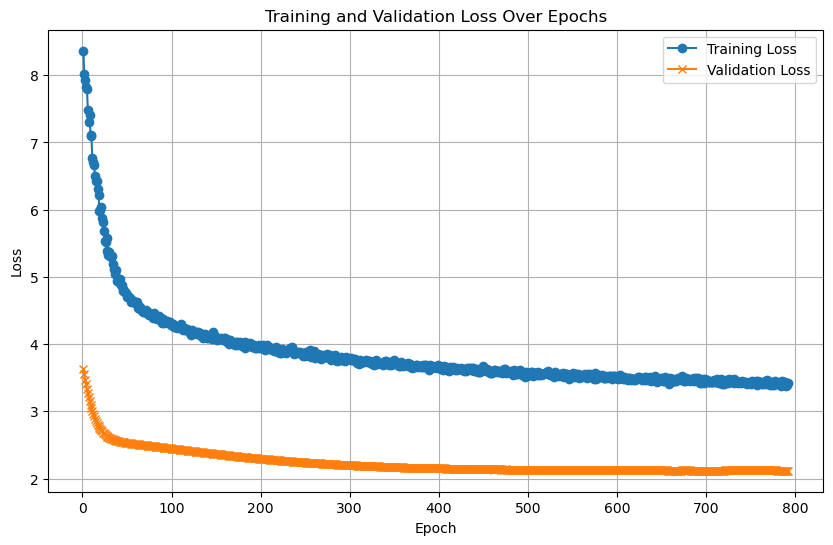

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/578], Loss: 4.8469
Test Batch [20/578], Loss: 4.7894
Test Batch [30/578], Loss: 4.7906


Test Batch [40/578], Loss: 4.5821
Test Batch [50/578], Loss: 4.6367
Test Batch [60/578], Loss: 4.5794
Test Batch [70/578], Loss: 4.5559
Test Batch [80/578], Loss: 4.5421
Test Batch [90/578], Loss: 4.6533
Test Batch [100/578], Loss: 4.4591
Test Batch [110/578], Loss: 4.5498
Test Batch [120/578], Loss: 4.5373
Test Batch [130/578], Loss: 4.5003
Test Batch [140/578], Loss: 4.5548
Test Batch [150/578], Loss: 4.7002


Test Batch [160/578], Loss: 4.7038
Test Batch [170/578], Loss: 4.7754
Test Batch [180/578], Loss: 4.6084
Test Batch [190/578], Loss: 4.5864
Test Batch [200/578], Loss: 4.5689


Test Batch [210/578], Loss: 4.6168
Test Batch [220/578], Loss: 4.7047
Test Batch [230/578], Loss: 4.5828
Test Batch [240/578], Loss: 4.4988
Test Batch [250/578], Loss: 4.5132
Test Batch [260/578], Loss: 4.5217
Test Batch [270/578], Loss: 4.5392
Test Batch [280/578], Loss: 4.5776
Test Batch [290/578], Loss: 4.6197
Test Batch [300/578], Loss: 4.6378


Test Batch [310/578], Loss: 4.6942
Test Batch [320/578], Loss: 4.9251
Test Batch [330/578], Loss: 5.0293
Test Batch [340/578], Loss: 5.1291
Test Batch [350/578], Loss: 5.1974
Test Batch [360/578], Loss: 5.2296


Test Batch [370/578], Loss: 5.0064
Test Batch [380/578], Loss: 4.4477
Test Batch [390/578], Loss: 4.8912
Test Batch [400/578], Loss: 4.8926
Test Batch [410/578], Loss: 4.9887
Test Batch [420/578], Loss: 4.9014
Test Batch [430/578], Loss: 4.9870
Test Batch [440/578], Loss: 5.0289
Test Batch [450/578], Loss: 4.9749
Test Batch [460/578], Loss: 5.2173


Test Batch [470/578], Loss: 4.8268
Test Batch [480/578], Loss: 4.5568
Test Batch [490/578], Loss: 5.0933
Test Batch [500/578], Loss: 5.1234
Test Batch [510/578], Loss: 5.3414


Test Batch [520/578], Loss: 5.1331
Test Batch [530/578], Loss: 5.0739
Test Batch [540/578], Loss: 4.7008
Test Batch [550/578], Loss: 4.6590
Test Batch [560/578], Loss: 4.4789
Test Batch [570/578], Loss: 4.7037

Test Loss: 4.7517


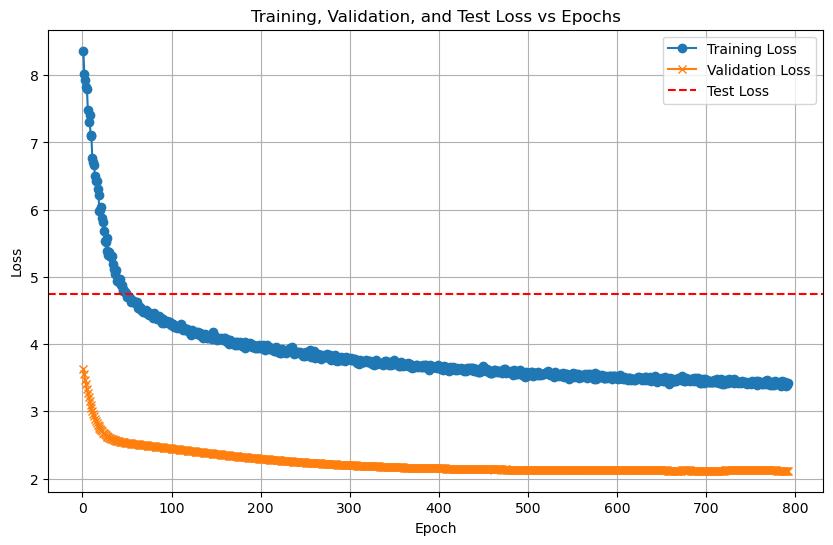

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.
  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.


  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.
  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.


  Processed batch 120/578 for test dataset.
  Processed batch 130/578 for test dataset.
  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.


  Processed batch 190/578 for test dataset.
  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.
  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.


  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.
  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.


  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.
  Processed batch 340/578 for test dataset.
  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.


  Processed batch 390/578 for test dataset.
  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.
  Processed batch 440/578 for test dataset.
  Processed batch 450/578 for test dataset.


  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.
  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.


  Processed batch 530/578 for test dataset.
  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.67      0.40      0.50         5
           4       0.62      1.00      0.77         5
           5       0.80      0.80      0.80         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.87        45
   macro avg       0.88      0.87      0.86        45
weighted avg       0.88      0.87      0.86        45


LOG: Evaluating on the test set...
Test Accuracy: 96.51%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65926
           1       0.91      0.89      0.90      7553
           2       0.73      0.77      0.75      3045
           3       0.80      0.65      0.72      2640
           4       0.82      0.96      0.88      6539
           5       0.91      0.93      0.92      9203
           6       0.93      0.91      0.92      7242
           7       0.99      0.98      0.99     42781
           8       0.92      0.99      0.95      2818

    accuracy                           0.97    147747
   macro avg       0.89      0.90      0.89    147747
weighted avg       0.97      0.97      0.97    147747

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2837  |  Val Loss: 2.2250
Validation loss improved from inf to 2.2250.
[Epoch 2/1000] Train Loss: 2.1986  |  Val Loss: 2.1459
Validation loss improved from 2.2250 to 2.1459.
[Epoch 3/1000] Train Loss: 2.1253  |  Val Loss: 2.0755
Validation loss improved from 2.1459 to 2.0755.
[Epoch 4/1000] Train Loss: 2.0604  |  Val Loss: 2.0130
Validation loss improved from 2.0755 to 2.0130.
[Epoch 5/1000] Train Loss: 2.0020  |  Val Loss: 1.9564
Validation loss improved from 2.0130 to 1.9564.
[Epoch 6/1000] Train Loss: 1.9449  |  Val Loss: 1.9038
Validation loss improved from 1.9564 to 1.9038.
[Epoch 7/1000] Train Loss: 1.8943  |  Val Loss: 1.8555
Validation loss improved from 1.9038 to 1.8555.
[Epoch 8/1000] Train Loss: 1.8479  |  Val Loss: 1.8091
Validation loss improved from 1.8555 to 1.8091.
[Epoch 9/1000] Train Loss: 1.8043  |  Val Loss: 1.7671
Validation loss improved from 1.8091 to 1.7671.
[Epoch 10/1000] Train Loss: 1.7641  |  Val Loss: 1.7275
Validation loss impr

[Epoch 15/1000] Train Loss: 1.5736  |  Val Loss: 1.5398
Validation loss improved from 1.5758 to 1.5398.
[Epoch 16/1000] Train Loss: 1.5379  |  Val Loss: 1.5046
Validation loss improved from 1.5398 to 1.5046.
[Epoch 17/1000] Train Loss: 1.5032  |  Val Loss: 1.4706
Validation loss improved from 1.5046 to 1.4706.
[Epoch 18/1000] Train Loss: 1.4693  |  Val Loss: 1.4376
Validation loss improved from 1.4706 to 1.4376.


[Epoch 19/1000] Train Loss: 1.4362  |  Val Loss: 1.4054
Validation loss improved from 1.4376 to 1.4054.
[Epoch 20/1000] Train Loss: 1.4042  |  Val Loss: 1.3738
Validation loss improved from 1.4054 to 1.3738.
[Epoch 21/1000] Train Loss: 1.3722  |  Val Loss: 1.3436
Validation loss improved from 1.3738 to 1.3436.
[Epoch 22/1000] Train Loss: 1.3414  |  Val Loss: 1.3144
Validation loss improved from 1.3436 to 1.3144.
[Epoch 23/1000] Train Loss: 1.3115  |  Val Loss: 1.2856
Validation loss improved from 1.3144 to 1.2856.
[Epoch 24/1000] Train Loss: 1.2820  |  Val Loss: 1.2573
Validation loss improved from 1.2856 to 1.2573.
[Epoch 25/1000] Train Loss: 1.2527  |  Val Loss: 1.2299
Validation loss improved from 1.2573 to 1.2299.
[Epoch 26/1000] Train Loss: 1.2244  |  Val Loss: 1.2028
Validation loss improved from 1.2299 to 1.2028.
[Epoch 27/1000] Train Loss: 1.1954  |  Val Loss: 1.1771
Validation loss improved from 1.2028 to 1.1771.
[Epoch 28/1000] Train Loss: 1.1680  |  Val Loss: 1.1510
Validati

[Epoch 32/1000] Train Loss: 1.0592  |  Val Loss: 1.0519
Validation loss improved from 1.0762 to 1.0519.
[Epoch 33/1000] Train Loss: 1.0327  |  Val Loss: 1.0280
Validation loss improved from 1.0519 to 1.0280.
[Epoch 34/1000] Train Loss: 1.0068  |  Val Loss: 1.0046
Validation loss improved from 1.0280 to 1.0046.
[Epoch 35/1000] Train Loss: 0.9820  |  Val Loss: 0.9813
Validation loss improved from 1.0046 to 0.9813.


[Epoch 36/1000] Train Loss: 0.9576  |  Val Loss: 0.9587
Validation loss improved from 0.9813 to 0.9587.
[Epoch 37/1000] Train Loss: 0.9333  |  Val Loss: 0.9365
Validation loss improved from 0.9587 to 0.9365.
[Epoch 38/1000] Train Loss: 0.9093  |  Val Loss: 0.9153
Validation loss improved from 0.9365 to 0.9153.
[Epoch 39/1000] Train Loss: 0.8863  |  Val Loss: 0.8945
Validation loss improved from 0.9153 to 0.8945.
[Epoch 40/1000] Train Loss: 0.8632  |  Val Loss: 0.8735
Validation loss improved from 0.8945 to 0.8735.
[Epoch 41/1000] Train Loss: 0.8415  |  Val Loss: 0.8530
Validation loss improved from 0.8735 to 0.8530.
[Epoch 42/1000] Train Loss: 0.8197  |  Val Loss: 0.8334
Validation loss improved from 0.8530 to 0.8334.
[Epoch 43/1000] Train Loss: 0.7987  |  Val Loss: 0.8149
Validation loss improved from 0.8334 to 0.8149.
[Epoch 44/1000] Train Loss: 0.7788  |  Val Loss: 0.7966
Validation loss improved from 0.8149 to 0.7966.
[Epoch 45/1000] Train Loss: 0.7585  |  Val Loss: 0.7784
Validati

[Epoch 49/1000] Train Loss: 0.6834  |  Val Loss: 0.7099
Validation loss improved from 0.7262 to 0.7099.
[Epoch 50/1000] Train Loss: 0.6661  |  Val Loss: 0.6943
Validation loss improved from 0.7099 to 0.6943.
[Epoch 51/1000] Train Loss: 0.6490  |  Val Loss: 0.6789
Validation loss improved from 0.6943 to 0.6789.


[Epoch 52/1000] Train Loss: 0.6324  |  Val Loss: 0.6639
Validation loss improved from 0.6789 to 0.6639.
[Epoch 53/1000] Train Loss: 0.6167  |  Val Loss: 0.6499
Validation loss improved from 0.6639 to 0.6499.
[Epoch 54/1000] Train Loss: 0.6016  |  Val Loss: 0.6359
Validation loss improved from 0.6499 to 0.6359.
[Epoch 55/1000] Train Loss: 0.5869  |  Val Loss: 0.6229
Validation loss improved from 0.6359 to 0.6229.
[Epoch 56/1000] Train Loss: 0.5731  |  Val Loss: 0.6111
Validation loss improved from 0.6229 to 0.6111.
[Epoch 57/1000] Train Loss: 0.5595  |  Val Loss: 0.5989
Validation loss improved from 0.6111 to 0.5989.
[Epoch 58/1000] Train Loss: 0.5465  |  Val Loss: 0.5874
Validation loss improved from 0.5989 to 0.5874.
[Epoch 59/1000] Train Loss: 0.5341  |  Val Loss: 0.5766
Validation loss improved from 0.5874 to 0.5766.
[Epoch 60/1000] Train Loss: 0.5220  |  Val Loss: 0.5661
Validation loss improved from 0.5766 to 0.5661.
[Epoch 61/1000] Train Loss: 0.5105  |  Val Loss: 0.5555
Validati

[Epoch 67/1000] Train Loss: 0.4475  |  Val Loss: 0.5007
Validation loss improved from 0.5097 to 0.5007.
[Epoch 68/1000] Train Loss: 0.4383  |  Val Loss: 0.4919
Validation loss improved from 0.5007 to 0.4919.
[Epoch 69/1000] Train Loss: 0.4285  |  Val Loss: 0.4846
Validation loss improved from 0.4919 to 0.4846.
[Epoch 70/1000] Train Loss: 0.4196  |  Val Loss: 0.4772
Validation loss improved from 0.4846 to 0.4772.
[Epoch 71/1000] Train Loss: 0.4106  |  Val Loss: 0.4693
Validation loss improved from 0.4772 to 0.4693.
[Epoch 72/1000] Train Loss: 0.4017  |  Val Loss: 0.4615
Validation loss improved from 0.4693 to 0.4615.
[Epoch 73/1000] Train Loss: 0.3934  |  Val Loss: 0.4544
Validation loss improved from 0.4615 to 0.4544.
[Epoch 74/1000] Train Loss: 0.3854  |  Val Loss: 0.4474
Validation loss improved from 0.4544 to 0.4474.
[Epoch 75/1000] Train Loss: 0.3771  |  Val Loss: 0.4415
Validation loss improved from 0.4474 to 0.4415.
[Epoch 76/1000] Train Loss: 0.3690  |  Val Loss: 0.4349
Validati

[Epoch 83/1000] Train Loss: 0.3182  |  Val Loss: 0.3944
Validation loss improved from 0.4000 to 0.3944.
[Epoch 84/1000] Train Loss: 0.3114  |  Val Loss: 0.3902
Validation loss improved from 0.3944 to 0.3902.
[Epoch 85/1000] Train Loss: 0.3053  |  Val Loss: 0.3857
Validation loss improved from 0.3902 to 0.3857.
[Epoch 86/1000] Train Loss: 0.2987  |  Val Loss: 0.3801
Validation loss improved from 0.3857 to 0.3801.
[Epoch 87/1000] Train Loss: 0.2920  |  Val Loss: 0.3731
Validation loss improved from 0.3801 to 0.3731.
[Epoch 88/1000] Train Loss: 0.2859  |  Val Loss: 0.3674
Validation loss improved from 0.3731 to 0.3674.
[Epoch 89/1000] Train Loss: 0.2798  |  Val Loss: 0.3638
Validation loss improved from 0.3674 to 0.3638.
[Epoch 90/1000] Train Loss: 0.2739  |  Val Loss: 0.3614
Validation loss improved from 0.3638 to 0.3614.
[Epoch 91/1000] Train Loss: 0.2680  |  Val Loss: 0.3564
Validation loss improved from 0.3614 to 0.3564.
[Epoch 92/1000] Train Loss: 0.2619  |  Val Loss: 0.3517
Validati

[Epoch 101/1000] Train Loss: 0.2159  |  Val Loss: 0.3173
Validation loss improved from 0.3215 to 0.3173.
[Epoch 102/1000] Train Loss: 0.2116  |  Val Loss: 0.3139
Validation loss improved from 0.3173 to 0.3139.
[Epoch 103/1000] Train Loss: 0.2077  |  Val Loss: 0.3109
Validation loss improved from 0.3139 to 0.3109.
[Epoch 104/1000] Train Loss: 0.2038  |  Val Loss: 0.3085
Validation loss improved from 0.3109 to 0.3085.
[Epoch 105/1000] Train Loss: 0.2000  |  Val Loss: 0.3071
Validation loss improved from 0.3085 to 0.3071.
[Epoch 106/1000] Train Loss: 0.1963  |  Val Loss: 0.3051
Validation loss improved from 0.3071 to 0.3051.
[Epoch 107/1000] Train Loss: 0.1929  |  Val Loss: 0.3041
Validation loss improved from 0.3051 to 0.3041.
[Epoch 108/1000] Train Loss: 0.1896  |  Val Loss: 0.3007
Validation loss improved from 0.3041 to 0.3007.
[Epoch 109/1000] Train Loss: 0.1869  |  Val Loss: 0.2993
Validation loss improved from 0.3007 to 0.2993.
[Epoch 110/1000] Train Loss: 0.1832  |  Val Loss: 0.296

[Epoch 117/1000] Train Loss: 0.1651  |  Val Loss: 0.2843
Validation loss improved from 0.2858 to 0.2843.
[Epoch 118/1000] Train Loss: 0.1628  |  Val Loss: 0.2836
Validation loss improved from 0.2843 to 0.2836.
[Epoch 119/1000] Train Loss: 0.1603  |  Val Loss: 0.2817
Validation loss improved from 0.2836 to 0.2817.
[Epoch 120/1000] Train Loss: 0.1582  |  Val Loss: 0.2822
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 121/1000] Train Loss: 0.1560  |  Val Loss: 0.2822
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 122/1000] Train Loss: 0.1539  |  Val Loss: 0.2804
Validation loss improved from 0.2817 to 0.2804.
[Epoch 123/1000] Train Loss: 0.1523  |  Val Loss: 0.2814
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 124/1000] Train Loss: 0.1504  |  Val Loss: 0.2781
Validation loss improved from 0.2804 to 0.2781.
[Epoch 125/1000] Train Loss: 0.1482  |  Val Loss: 0.2773
Validation loss improved from 0.2781 to 0.2773.
[Epoch 126/1000] Train Loss: 0.1467  

[Epoch 135/1000] Train Loss: 0.1330  |  Val Loss: 0.2712
Validation loss improved from 0.2720 to 0.2712.
[Epoch 136/1000] Train Loss: 0.1316  |  Val Loss: 0.2706
Validation loss improved from 0.2712 to 0.2706.
[Epoch 137/1000] Train Loss: 0.1302  |  Val Loss: 0.2704
Validation loss improved from 0.2706 to 0.2704.
[Epoch 138/1000] Train Loss: 0.1293  |  Val Loss: 0.2693
Validation loss improved from 0.2704 to 0.2693.
[Epoch 139/1000] Train Loss: 0.1277  |  Val Loss: 0.2684
Validation loss improved from 0.2693 to 0.2684.
[Epoch 140/1000] Train Loss: 0.1265  |  Val Loss: 0.2691
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 141/1000] Train Loss: 0.1258  |  Val Loss: 0.2690
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 142/1000] Train Loss: 0.1244  |  Val Loss: 0.2683
Validation loss improved from 0.2684 to 0.2683.
[Epoch 143/1000] Train Loss: 0.1233  |  Val Loss: 0.2676
Validation loss improved from 0.2683 to 0.2676.
[Epoch 144/1000] Train Loss: 0.1222  |  Val

[Epoch 152/1000] Train Loss: 0.1147  |  Val Loss: 0.2694
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 153/1000] Train Loss: 0.1139  |  Val Loss: 0.2695
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 154/1000] Train Loss: 0.1130  |  Val Loss: 0.2692
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 155/1000] Train Loss: 0.1122  |  Val Loss: 0.2682
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 156/1000] Train Loss: 0.1114  |  Val Loss: 0.2672
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 157/1000] Train Loss: 0.1108  |  Val Loss: 0.2663
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 158/1000] Train Loss: 0.1100  |  Val Loss: 0.2665
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 159/1000] Train Loss: 0.1093  |  Val Loss: 0.2656
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 160/1000] Train Loss: 0.1087  |  Val Loss: 0.2643
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 169/1000] Train Loss: 0.1026  |  Val Loss: 0.2640
Validation loss improved from 0.2641 to 0.2640.
[Epoch 170/1000] Train Loss: 0.1021  |  Val Loss: 0.2660
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 171/1000] Train Loss: 0.1015  |  Val Loss: 0.2658
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 172/1000] Train Loss: 0.1011  |  Val Loss: 0.2655
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 173/1000] Train Loss: 0.1004  |  Val Loss: 0.2678
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 174/1000] Train Loss: 0.0999  |  Val Loss: 0.2685
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 175/1000] Train Loss: 0.0992  |  Val Loss: 0.2689
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 176/1000] Train Loss: 0.0988  |  Val Loss: 0.2676
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 177/1000] Train Loss: 0.0982  |  Val Loss: 0.2659
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 187/1000] Train Loss: 0.0933  |  Val Loss: 0.2694
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 188/1000] Train Loss: 0.0930  |  Val Loss: 0.2705
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 189/1000] Train Loss: 0.0928  |  Val Loss: 0.2721
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 190/1000] Train Loss: 0.0922  |  Val Loss: 0.2716
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 191/1000] Train Loss: 0.0917  |  Val Loss: 0.2693
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 192/1000] Train Loss: 0.0913  |  Val Loss: 0.2680
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 193/1000] Train Loss: 0.0910  |  Val Loss: 0.2662
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 194/1000] Train Loss: 0.0906  |  Val Loss: 0.2680
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 195/1000] Train Loss: 0.0910  |  Val Loss: 0.2668
!! Validation loss did NOT improve !! Patience:

[Epoch 205/1000] Train Loss: 0.0866  |  Val Loss: 0.2690
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 206/1000] Train Loss: 0.0860  |  Val Loss: 0.2690
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 207/1000] Train Loss: 0.0867  |  Val Loss: 0.2690
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 208/1000] Train Loss: 0.0859  |  Val Loss: 0.2661
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 209/1000] Train Loss: 0.0853  |  Val Loss: 0.2678
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 210/1000] Train Loss: 0.0850  |  Val Loss: 0.2697
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 211/1000] Train Loss: 0.0847  |  Val Loss: 0.2676
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 212/1000] Train Loss: 0.0843  |  Val Loss: 0.2698
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 213/1000] Train Loss: 0.0837  |  Val Loss: 0.2717
!! Validation loss did NOT improve !! Patience:

[Epoch 223/1000] Train Loss: 0.0816  |  Val Loss: 0.2738
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 224/1000] Train Loss: 0.0807  |  Val Loss: 0.2728
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 225/1000] Train Loss: 0.0808  |  Val Loss: 0.2715
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 226/1000] Train Loss: 0.0804  |  Val Loss: 0.2691
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 227/1000] Train Loss: 0.0806  |  Val Loss: 0.2733
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 228/1000] Train Loss: 0.0801  |  Val Loss: 0.2729
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 229/1000] Train Loss: 0.0796  |  Val Loss: 0.2728
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 230/1000] Train Loss: 0.0791  |  Val Loss: 0.2722
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 231/1000] Train Loss: 0.0789  |  Val Loss: 0.2722
!! Validation loss did NOT improve !! Patience:

[Epoch 240/1000] Train Loss: 0.0770  |  Val Loss: 0.2778
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 241/1000] Train Loss: 0.0764  |  Val Loss: 0.2790
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 242/1000] Train Loss: 0.0764  |  Val Loss: 0.2793
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 243/1000] Train Loss: 0.0761  |  Val Loss: 0.2746
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 244/1000] Train Loss: 0.0755  |  Val Loss: 0.2739
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 245/1000] Train Loss: 0.0755  |  Val Loss: 0.2723
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 246/1000] Train Loss: 0.0753  |  Val Loss: 0.2709
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 247/1000] Train Loss: 0.0751  |  Val Loss: 0.2727
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 248/1000] Train Loss: 0.0748  |  Val Loss: 0.2731
!! Validation loss did NOT improve !! Patience:

[Epoch 256/1000] Train Loss: 0.0732  |  Val Loss: 0.2804
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 257/1000] Train Loss: 0.0729  |  Val Loss: 0.2789
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 258/1000] Train Loss: 0.0731  |  Val Loss: 0.2756
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 259/1000] Train Loss: 0.0728  |  Val Loss: 0.2778
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 260/1000] Train Loss: 0.0726  |  Val Loss: 0.2793
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 261/1000] Train Loss: 0.0723  |  Val Loss: 0.2784
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 262/1000] Train Loss: 0.0727  |  Val Loss: 0.2811
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 263/1000] Train Loss: 0.0718  |  Val Loss: 0.2788
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 264/1000] Train Loss: 0.0716  |  Val Loss: 0.2771
!! Validation loss did NOT improve !! Patience:

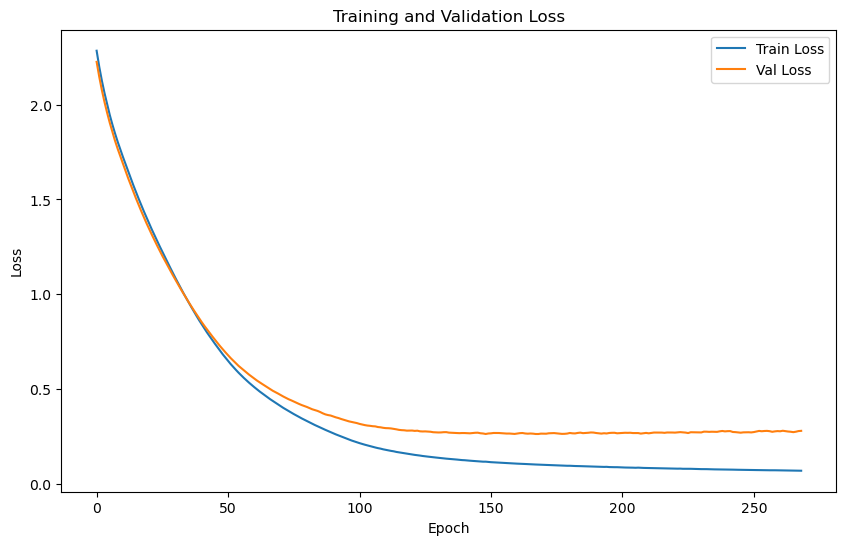

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.1385 | Test Accuracy: 96.33%


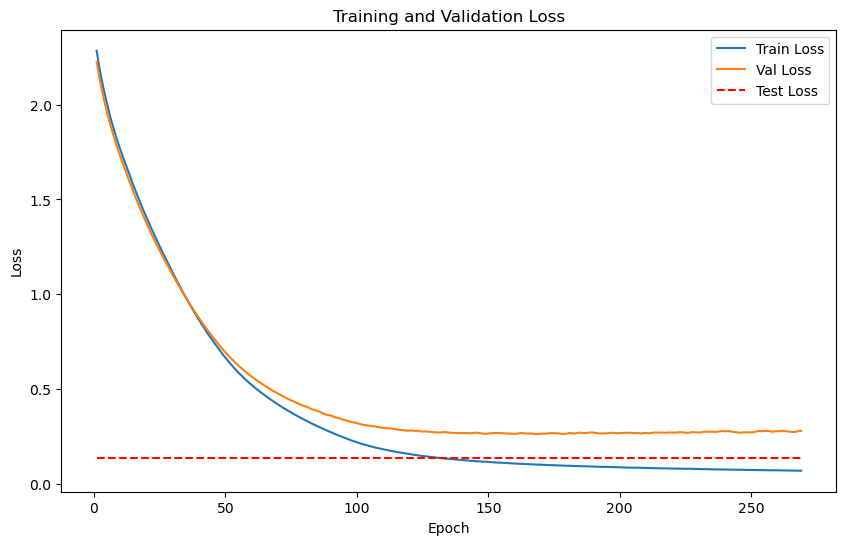

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147747, 64), 
Test labels shape: (147747,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4510
    Batch [2/2], Train Loss: 0.4374
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3687
Epoch [1/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.3687

Validation loss improved from inf to 0.3687. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.4333


    Batch [2/2], Train Loss: 0.4401
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3635
Epoch [2/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.3635

Validation loss improved from 0.3687 to 0.3635. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 0.4362
    Batch [2/2], Train Loss: 0.4356
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.3598
Epoch [3/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.3598

Validation loss improved from 0.3635 to 0.3598. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 0.4302
    Batch [2/2], Train Loss: 0.4342
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3582
Epoch [4/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.3582

Validation loss improved from 0.3598 to 0.3582. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.4353
    Batch [2/2], Train Loss: 0.4255
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.3569
Epoch [5/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.3569

Validation loss improved from 0.3582 to 0.3569. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 0.4253


    Batch [2/2], Train Loss: 0.4234
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.3553
Epoch [6/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.3553

Validation loss improved from 0.3569 to 0.3553. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 0.4276
    Batch [2/2], Train Loss: 0.4282
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.3534
Epoch [7/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.3534

Validation loss improved from 0.3553 to 0.3534. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.4224
    Batch [2/2], Train Loss: 0.4232
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3518
Epoch [8/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3518

Validation loss improved from 0.3534 to 0.3518. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.4267
    Batch [2/2], Train Loss: 0.4333
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.3504
Epoch [9/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.3504

Validation loss improved from 0.3518 to 0.3504. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 0.4245


    Batch [2/2], Train Loss: 0.4257
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3490
Epoch [10/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.3490

Validation loss improved from 0.3504 to 0.3490. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 0.4251
    Batch [2/2], Train Loss: 0.4170
LOG: Epoch [11/2000] - Validation


    Batch [1/1], Val Loss: 0.3477
Epoch [11/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.3477

Validation loss improved from 0.3490 to 0.3477. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 0.4168
    Batch [2/2], Train Loss: 0.4152
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3466
Epoch [12/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.3466

Validation loss improved from 0.3477 to 0.3466. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/2], Train Loss: 0.4102
    Batch [2/2], Train Loss: 0.4245
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3453
Epoch [13/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.3453

Validation loss improved from 0.3466 to 0.3453. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 0.4120


    Batch [2/2], Train Loss: 0.4181
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.3442
Epoch [14/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3442

Validation loss improved from 0.3453 to 0.3442. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.4100
    Batch [2/2], Train Loss: 0.4141
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.3430
Epoch [15/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.3430

Validation loss improved from 0.3442 to 0.3430. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/2], Train Loss: 0.4123
    Batch [2/2], Train Loss: 0.4050
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.3419
Epoch [16/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.3419

Validation loss improved from 0.3430 to 0.3419. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 0.4126


    Batch [2/2], Train Loss: 0.4164
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3408
Epoch [17/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.3408

Validation loss improved from 0.3419 to 0.3408. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 0.4059
    Batch [2/2], Train Loss: 0.4002
LOG: Epoch [18/2000] - Validation


    Batch [1/1], Val Loss: 0.3395
Epoch [18/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3395

Validation loss improved from 0.3408 to 0.3395. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.3990
    Batch [2/2], Train Loss: 0.4098
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [19/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.3383

Validation loss improved from 0.3395 to 0.3383. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.4122
    Batch [2/2], Train Loss: 0.4036
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3371
Epoch [20/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.3371

Validation loss improved from 0.3383 to 0.3371. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/2], Train Loss: 0.4055


    Batch [2/2], Train Loss: 0.4043
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3359
Epoch [21/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3359

Validation loss improved from 0.3371 to 0.3359. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 0.3987
    Batch [2/2], Train Loss: 0.4037
LOG: Epoch [22/2000] - Validation


    Batch [1/1], Val Loss: 0.3349
Epoch [22/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.3349

Validation loss improved from 0.3359 to 0.3349. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 0.3955
    Batch [2/2], Train Loss: 0.4010
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3339
Epoch [23/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3339

Validation loss improved from 0.3349 to 0.3339. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/2], Train Loss: 0.3964
    Batch [2/2], Train Loss: 0.4005
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [24/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.3328

Validation loss improved from 0.3339 to 0.3328. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 0.4060


    Batch [2/2], Train Loss: 0.3952
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [25/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.3318

Validation loss improved from 0.3328 to 0.3318. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 0.4058
    Batch [2/2], Train Loss: 0.3941
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3308
Epoch [26/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.3308

Validation loss improved from 0.3318 to 0.3308. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/2], Train Loss: 0.3991
    Batch [2/2], Train Loss: 0.3870
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3299
Epoch [27/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3299

Validation loss improved from 0.3308 to 0.3299. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 0.3958


    Batch [2/2], Train Loss: 0.3918
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3290
Epoch [28/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.3290

Validation loss improved from 0.3299 to 0.3290. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 0.3817
    Batch [2/2], Train Loss: 0.3897
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3280
Epoch [29/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.3280

Validation loss improved from 0.3290 to 0.3280. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/2], Train Loss: 0.3872
    Batch [2/2], Train Loss: 0.3861
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3271
Epoch [30/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.3271

Validation loss improved from 0.3280 to 0.3271. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 0.3915


    Batch [2/2], Train Loss: 0.3947
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3262
Epoch [31/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.3262

Validation loss improved from 0.3271 to 0.3262. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 0.3884
    Batch [2/2], Train Loss: 0.3858
LOG: Epoch [32/2000] - Validation


    Batch [1/1], Val Loss: 0.3253
Epoch [32/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.3253

Validation loss improved from 0.3262 to 0.3253. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 0.3836
    Batch [2/2], Train Loss: 0.3817
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3245
Epoch [33/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.3245

Validation loss improved from 0.3253 to 0.3245. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.3774
    Batch [2/2], Train Loss: 0.3853
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3236
Epoch [34/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.3236

Validation loss improved from 0.3245 to 0.3236. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 0.3886


    Batch [2/2], Train Loss: 0.3880
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3226
Epoch [35/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3226

Validation loss improved from 0.3236 to 0.3226. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 0.3746
    Batch [2/2], Train Loss: 0.3853
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3216
Epoch [36/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.3216

Validation loss improved from 0.3226 to 0.3216. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.3769
    Batch [2/2], Train Loss: 0.3878
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3205
Epoch [37/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.3205

Validation loss improved from 0.3216 to 0.3205. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.3782


    Batch [2/2], Train Loss: 0.3773
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3194
Epoch [38/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.3194

Validation loss improved from 0.3205 to 0.3194. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 0.3798
    Batch [2/2], Train Loss: 0.3823
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3185
Epoch [39/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.3185

Validation loss improved from 0.3194 to 0.3185. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/2], Train Loss: 0.3703
    Batch [2/2], Train Loss: 0.3784
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3175
Epoch [40/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.3175

Validation loss improved from 0.3185 to 0.3175. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 0.3728


    Batch [2/2], Train Loss: 0.3699
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3166
Epoch [41/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.3166

Validation loss improved from 0.3175 to 0.3166. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 0.3701
    Batch [2/2], Train Loss: 0.3775
LOG: Epoch [42/2000] - Validation


    Batch [1/1], Val Loss: 0.3156
Epoch [42/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.3156

Validation loss improved from 0.3166 to 0.3156. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 0.3727
    Batch [2/2], Train Loss: 0.3745
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [43/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.3148

Validation loss improved from 0.3156 to 0.3148. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/2], Train Loss: 0.3761
    Batch [2/2], Train Loss: 0.3653
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3139
Epoch [44/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.3139

Validation loss improved from 0.3148 to 0.3139. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 0.3640


    Batch [2/2], Train Loss: 0.3652
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3131
Epoch [45/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.3131

Validation loss improved from 0.3139 to 0.3131. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 0.3690
    Batch [2/2], Train Loss: 0.3718
LOG: Epoch [46/2000] - Validation


    Batch [1/1], Val Loss: 0.3122
Epoch [46/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.3122

Validation loss improved from 0.3131 to 0.3122. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 0.3697
    Batch [2/2], Train Loss: 0.3562
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [47/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.3114

Validation loss improved from 0.3122 to 0.3114. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/2], Train Loss: 0.3647
    Batch [2/2], Train Loss: 0.3684
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3107
Epoch [48/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.3107

Validation loss improved from 0.3114 to 0.3107. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 0.3642


    Batch [2/2], Train Loss: 0.3749
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [49/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3099

Validation loss improved from 0.3107 to 0.3099. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 0.3713
    Batch [2/2], Train Loss: 0.3613
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [50/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3089

Validation loss improved from 0.3099 to 0.3089. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/2], Train Loss: 0.3581
    Batch [2/2], Train Loss: 0.3600
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [51/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.3081

Validation loss improved from 0.3089 to 0.3081. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 0.3588


    Batch [2/2], Train Loss: 0.3612
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3072
Epoch [52/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.3072

Validation loss improved from 0.3081 to 0.3072. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 0.3618
    Batch [2/2], Train Loss: 0.3486
LOG: Epoch [53/2000] - Validation


    Batch [1/1], Val Loss: 0.3063
Epoch [53/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.3063

Validation loss improved from 0.3072 to 0.3063. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 0.3613
    Batch [2/2], Train Loss: 0.3556
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [54/2000], Avg Train Loss: 0.3585, Avg Val Loss: 0.3055

Validation loss improved from 0.3063 to 0.3055. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/2], Train Loss: 0.3567
    Batch [2/2], Train Loss: 0.3652
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [55/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.3046

Validation loss improved from 0.3055 to 0.3046. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 0.3439


    Batch [2/2], Train Loss: 0.3449
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3037
Epoch [56/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.3037

Validation loss improved from 0.3046 to 0.3037. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 0.3627
    Batch [2/2], Train Loss: 0.3497
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3029
Epoch [57/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.3029

Validation loss improved from 0.3037 to 0.3029. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.3546
    Batch [2/2], Train Loss: 0.3537
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3021
Epoch [58/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.3021

Validation loss improved from 0.3029 to 0.3021. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/2], Train Loss: 0.3520
    Batch [2/2], Train Loss: 0.3435
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [59/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.3011

Validation loss improved from 0.3021 to 0.3011. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.3410
    Batch [2/2], Train Loss: 0.3504
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [60/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.3003

Validation loss improved from 0.3011 to 0.3003. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 0.3561


    Batch [2/2], Train Loss: 0.3513
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.2993
Epoch [61/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.2993

Validation loss improved from 0.3003 to 0.2993. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 0.3580
    Batch [2/2], Train Loss: 0.3443
LOG: Epoch [62/2000] - Validation


    Batch [1/1], Val Loss: 0.2985
Epoch [62/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.2985

Validation loss improved from 0.2993 to 0.2985. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 0.3497
    Batch [2/2], Train Loss: 0.3443
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.2975
Epoch [63/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2975

Validation loss improved from 0.2985 to 0.2975. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/2], Train Loss: 0.3505
    Batch [2/2], Train Loss: 0.3392
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.2968
Epoch [64/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2968

Validation loss improved from 0.2975 to 0.2968. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 0.3472


    Batch [2/2], Train Loss: 0.3461
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.2962
Epoch [65/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2962

Validation loss improved from 0.2968 to 0.2962. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.3504
    Batch [2/2], Train Loss: 0.3371
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.2956
Epoch [66/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2956

Validation loss improved from 0.2962 to 0.2956. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.3429
    Batch [2/2], Train Loss: 0.3414
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.2949
Epoch [67/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2949

Validation loss improved from 0.2956 to 0.2949. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 0.3410


    Batch [2/2], Train Loss: 0.3415
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.2941
Epoch [68/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2941

Validation loss improved from 0.2949 to 0.2941. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 0.3431
    Batch [2/2], Train Loss: 0.3439
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.2934
Epoch [69/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.2934

Validation loss improved from 0.2941 to 0.2934. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.3369
    Batch [2/2], Train Loss: 0.3415
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.2928
Epoch [70/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.2928

Validation loss improved from 0.2934 to 0.2928. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 0.3317


    Batch [2/2], Train Loss: 0.3408
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.2920
Epoch [71/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.2920

Validation loss improved from 0.2928 to 0.2920. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 0.3397
    Batch [2/2], Train Loss: 0.3326
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.2914
Epoch [72/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.2914

Validation loss improved from 0.2920 to 0.2914. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/2], Train Loss: 0.3249
    Batch [2/2], Train Loss: 0.3327
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.2909
Epoch [73/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.2909

Validation loss improved from 0.2914 to 0.2909. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 0.3326


    Batch [2/2], Train Loss: 0.3354
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.2904
Epoch [74/2000], Avg Train Loss: 0.3340, Avg Val Loss: 0.2904

Validation loss improved from 0.2909 to 0.2904. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 0.3286


    Batch [2/2], Train Loss: 0.3305
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.2899
Epoch [75/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.2899

Validation loss improved from 0.2904 to 0.2899. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 0.3439
    Batch [2/2], Train Loss: 0.3208
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.2892
Epoch [76/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.2892

Validation loss improved from 0.2899 to 0.2892. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/2], Train Loss: 0.3396
    Batch [2/2], Train Loss: 0.3218
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [77/2000], Avg Train Loss: 0.3307, Avg Val Loss: 0.2886

Validation loss improved from 0.2892 to 0.2886. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 0.3376


    Batch [2/2], Train Loss: 0.3432
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.2880
Epoch [78/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.2880

Validation loss improved from 0.2886 to 0.2880. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 0.3113
    Batch [2/2], Train Loss: 0.3306
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.2874
Epoch [79/2000], Avg Train Loss: 0.3210, Avg Val Loss: 0.2874

Validation loss improved from 0.2880 to 0.2874. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.3295
    Batch [2/2], Train Loss: 0.3242
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.2866
Epoch [80/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.2866

Validation loss improved from 0.2874 to 0.2866. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 0.3177


    Batch [2/2], Train Loss: 0.3307
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.2860
Epoch [81/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.2860

Validation loss improved from 0.2866 to 0.2860. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 0.3179
    Batch [2/2], Train Loss: 0.3268
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.2854
Epoch [82/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.2854

Validation loss improved from 0.2860 to 0.2854. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.3252
    Batch [2/2], Train Loss: 0.3158
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.2847
Epoch [83/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.2847

Validation loss improved from 0.2854 to 0.2847. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.3279
    Batch [2/2], Train Loss: 0.3226
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.2841
Epoch [84/2000], Avg Train Loss: 0.3252, Avg Val Loss: 0.2841

Validation loss improved from 0.2847 to 0.2841. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.3222


    Batch [2/2], Train Loss: 0.3144
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.2835
Epoch [85/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.2835

Validation loss improved from 0.2841 to 0.2835. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/2], Train Loss: 0.3338
    Batch [2/2], Train Loss: 0.3186
LOG: Epoch [86/2000] - Validation


    Batch [1/1], Val Loss: 0.2828
Epoch [86/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.2828

Validation loss improved from 0.2835 to 0.2828. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 0.3200
    Batch [2/2], Train Loss: 0.3044
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.2821
Epoch [87/2000], Avg Train Loss: 0.3122, Avg Val Loss: 0.2821

Validation loss improved from 0.2828 to 0.2821. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/2], Train Loss: 0.3154
    Batch [2/2], Train Loss: 0.3136
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.2816
Epoch [88/2000], Avg Train Loss: 0.3145, Avg Val Loss: 0.2816

Validation loss improved from 0.2821 to 0.2816. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 0.3249


    Batch [2/2], Train Loss: 0.3170
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.2809
Epoch [89/2000], Avg Train Loss: 0.3210, Avg Val Loss: 0.2809

Validation loss improved from 0.2816 to 0.2809. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 0.3275
    Batch [2/2], Train Loss: 0.3221
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.2802
Epoch [90/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.2802

Validation loss improved from 0.2809 to 0.2802. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/2], Train Loss: 0.3134
    Batch [2/2], Train Loss: 0.3140
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.2796
Epoch [91/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.2796

Validation loss improved from 0.2802 to 0.2796. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 0.3196


    Batch [2/2], Train Loss: 0.3086
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.2789
Epoch [92/2000], Avg Train Loss: 0.3141, Avg Val Loss: 0.2789

Validation loss improved from 0.2796 to 0.2789. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 0.3180
    Batch [2/2], Train Loss: 0.3134
LOG: Epoch [93/2000] - Validation


    Batch [1/1], Val Loss: 0.2783
Epoch [93/2000], Avg Train Loss: 0.3157, Avg Val Loss: 0.2783

Validation loss improved from 0.2789 to 0.2783. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 0.3179
    Batch [2/2], Train Loss: 0.3131
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.2776
Epoch [94/2000], Avg Train Loss: 0.3155, Avg Val Loss: 0.2776

Validation loss improved from 0.2783 to 0.2776. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.3012
    Batch [2/2], Train Loss: 0.3086
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.2771
Epoch [95/2000], Avg Train Loss: 0.3049, Avg Val Loss: 0.2771

Validation loss improved from 0.2776 to 0.2771. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 0.3086


    Batch [2/2], Train Loss: 0.3153
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.2765
Epoch [96/2000], Avg Train Loss: 0.3119, Avg Val Loss: 0.2765

Validation loss improved from 0.2771 to 0.2765. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 0.3153
    Batch [2/2], Train Loss: 0.3228
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.2759
Epoch [97/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.2759

Validation loss improved from 0.2765 to 0.2759. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/2], Train Loss: 0.3083
    Batch [2/2], Train Loss: 0.3067
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.2755
Epoch [98/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.2755

Validation loss improved from 0.2759 to 0.2755. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 0.3071


    Batch [2/2], Train Loss: 0.3090
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.2750
Epoch [99/2000], Avg Train Loss: 0.3081, Avg Val Loss: 0.2750

Validation loss improved from 0.2755 to 0.2750. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.3114
    Batch [2/2], Train Loss: 0.3040
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.2745
Epoch [100/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.2745

Validation loss improved from 0.2750 to 0.2745. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/2], Train Loss: 0.3179
    Batch [2/2], Train Loss: 0.3099
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.2739
Epoch [101/2000], Avg Train Loss: 0.3139, Avg Val Loss: 0.2739

Validation loss improved from 0.2745 to 0.2739. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 0.3068


    Batch [2/2], Train Loss: 0.3090
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.2733
Epoch [102/2000], Avg Train Loss: 0.3079, Avg Val Loss: 0.2733

Validation loss improved from 0.2739 to 0.2733. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 0.3145
    Batch [2/2], Train Loss: 0.3128
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.2729
Epoch [103/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.2729

Validation loss improved from 0.2733 to 0.2729. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/2], Train Loss: 0.3140
    Batch [2/2], Train Loss: 0.3049
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.2725
Epoch [104/2000], Avg Train Loss: 0.3095, Avg Val Loss: 0.2725

Validation loss improved from 0.2729 to 0.2725. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 0.3062


    Batch [2/2], Train Loss: 0.3040
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.2718
Epoch [105/2000], Avg Train Loss: 0.3051, Avg Val Loss: 0.2718

Validation loss improved from 0.2725 to 0.2718. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/2], Train Loss: 0.3146
    Batch [2/2], Train Loss: 0.2987
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.2714
Epoch [106/2000], Avg Train Loss: 0.3066, Avg Val Loss: 0.2714

Validation loss improved from 0.2718 to 0.2714. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/2], Train Loss: 0.3163
    Batch [2/2], Train Loss: 0.2978
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.2710
Epoch [107/2000], Avg Train Loss: 0.3071, Avg Val Loss: 0.2710

Validation loss improved from 0.2714 to 0.2710. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 0.2914


    Batch [2/2], Train Loss: 0.3017
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.2706
Epoch [108/2000], Avg Train Loss: 0.2966, Avg Val Loss: 0.2706

Validation loss improved from 0.2710 to 0.2706. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 0.2984
    Batch [2/2], Train Loss: 0.2934
LOG: Epoch [109/2000] - Validation


    Batch [1/1], Val Loss: 0.2702
Epoch [109/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.2702

Validation loss improved from 0.2706 to 0.2702. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 0.3136
    Batch [2/2], Train Loss: 0.3071
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.2698
Epoch [110/2000], Avg Train Loss: 0.3104, Avg Val Loss: 0.2698

Validation loss improved from 0.2702 to 0.2698. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.2938
    Batch [2/2], Train Loss: 0.3027
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.2692
Epoch [111/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.2692

Validation loss improved from 0.2698 to 0.2692. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 0.2855


    Batch [2/2], Train Loss: 0.3035
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.2687
Epoch [112/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.2687

Validation loss improved from 0.2692 to 0.2687. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 0.2896
    Batch [2/2], Train Loss: 0.2937
LOG: Epoch [113/2000] - Validation


    Batch [1/1], Val Loss: 0.2683
Epoch [113/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.2683

Validation loss improved from 0.2687 to 0.2683. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.2984
    Batch [2/2], Train Loss: 0.3003
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.2678
Epoch [114/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.2678

Validation loss improved from 0.2683 to 0.2678. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/2], Train Loss: 0.2987
    Batch [2/2], Train Loss: 0.3042
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.2674
Epoch [115/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.2674

Validation loss improved from 0.2678 to 0.2674. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 0.3076


    Batch [2/2], Train Loss: 0.2917
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.2669
Epoch [116/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.2669

Validation loss improved from 0.2674 to 0.2669. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 0.2948
    Batch [2/2], Train Loss: 0.2951
LOG: Epoch [117/2000] - Validation


    Batch [1/1], Val Loss: 0.2663
Epoch [117/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.2663

Validation loss improved from 0.2669 to 0.2663. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 0.2867
    Batch [2/2], Train Loss: 0.2998
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.2656
Epoch [118/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.2656

Validation loss improved from 0.2663 to 0.2656. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.2991
    Batch [2/2], Train Loss: 0.3052
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.2651
Epoch [119/2000], Avg Train Loss: 0.3021, Avg Val Loss: 0.2651

Validation loss improved from 0.2656 to 0.2651. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 0.2885


    Batch [2/2], Train Loss: 0.2822
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.2646
Epoch [120/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.2646

Validation loss improved from 0.2651 to 0.2646. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.3041
    Batch [2/2], Train Loss: 0.2968
LOG: Epoch [121/2000] - Validation


    Batch [1/1], Val Loss: 0.2641
Epoch [121/2000], Avg Train Loss: 0.3004, Avg Val Loss: 0.2641

Validation loss improved from 0.2646 to 0.2641. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 0.2830
    Batch [2/2], Train Loss: 0.2916
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.2636
Epoch [122/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.2636

Validation loss improved from 0.2641 to 0.2636. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.2803
    Batch [2/2], Train Loss: 0.2823
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.2631
Epoch [123/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2631

Validation loss improved from 0.2636 to 0.2631. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.2962


    Batch [2/2], Train Loss: 0.2917
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.2627
Epoch [124/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.2627

Validation loss improved from 0.2631 to 0.2627. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 0.2859
    Batch [2/2], Train Loss: 0.2943
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.2623
Epoch [125/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.2623

Validation loss improved from 0.2627 to 0.2623. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/2], Train Loss: 0.2962
    Batch [2/2], Train Loss: 0.2856
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.2620
Epoch [126/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.2620

Validation loss improved from 0.2623 to 0.2620. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.2770


    Batch [2/2], Train Loss: 0.2728
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.2615
Epoch [127/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.2615

Validation loss improved from 0.2620 to 0.2615. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 0.2777
    Batch [2/2], Train Loss: 0.2991
LOG: Epoch [128/2000] - Validation


    Batch [1/1], Val Loss: 0.2611
Epoch [128/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.2611

Validation loss improved from 0.2615 to 0.2611. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 0.2870
    Batch [2/2], Train Loss: 0.2780
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.2606
Epoch [129/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.2606

Validation loss improved from 0.2611 to 0.2606. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.2807
    Batch [2/2], Train Loss: 0.2787
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.2601
Epoch [130/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2601

Validation loss improved from 0.2606 to 0.2601. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 0.2827


    Batch [2/2], Train Loss: 0.2730
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.2599
Epoch [131/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2599

Validation loss improved from 0.2601 to 0.2599. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 0.2772
    Batch [2/2], Train Loss: 0.2885
LOG: Epoch [132/2000] - Validation


    Batch [1/1], Val Loss: 0.2595
Epoch [132/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.2595

Validation loss improved from 0.2599 to 0.2595. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 0.2626
    Batch [2/2], Train Loss: 0.2844
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.2592
Epoch [133/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2592

Validation loss improved from 0.2595 to 0.2592. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.2623
    Batch [2/2], Train Loss: 0.2930
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.2589
Epoch [134/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2589

Validation loss improved from 0.2592 to 0.2589. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 0.2728


    Batch [2/2], Train Loss: 0.2920
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.2587
Epoch [135/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2587

Validation loss improved from 0.2589 to 0.2587. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 0.2731
    Batch [2/2], Train Loss: 0.2822
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.2584
Epoch [136/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2584

Validation loss improved from 0.2587 to 0.2584. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/2], Train Loss: 0.2784
    Batch [2/2], Train Loss: 0.2685
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.2581
Epoch [137/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2581

Validation loss improved from 0.2584 to 0.2581. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 0.2775


    Batch [2/2], Train Loss: 0.2698
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.2579
Epoch [138/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.2579

Validation loss improved from 0.2581 to 0.2579. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/2], Train Loss: 0.2781
    Batch [2/2], Train Loss: 0.2687
LOG: Epoch [139/2000] - Validation


    Batch [1/1], Val Loss: 0.2578
Epoch [139/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 0.2701
    Batch [2/2], Train Loss: 0.2834
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.2576
Epoch [140/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.2576

Validation loss improved from 0.2578 to 0.2576. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.2737
    Batch [2/2], Train Loss: 0.2819
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.2574
Epoch [141/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2574

Validation loss improved from 0.2576 to 0.2574. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 0.2747


    Batch [2/2], Train Loss: 0.2674
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.2572
Epoch [142/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2572

Validation loss improved from 0.2574 to 0.2572. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.2740
    Batch [2/2], Train Loss: 0.2780
LOG: Epoch [143/2000] - Validation


    Batch [1/1], Val Loss: 0.2568
Epoch [143/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.2568

Validation loss improved from 0.2572 to 0.2568. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 0.2803
    Batch [2/2], Train Loss: 0.2693
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.2565
Epoch [144/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.2565

Validation loss improved from 0.2568 to 0.2565. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.2674
    Batch [2/2], Train Loss: 0.2797
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.2563
Epoch [145/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2563

Validation loss improved from 0.2565 to 0.2563. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.2678


    Batch [2/2], Train Loss: 0.2794
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.2559
Epoch [146/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2559

Validation loss improved from 0.2563 to 0.2559. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 0.2729
    Batch [2/2], Train Loss: 0.2501
LOG: Epoch [147/2000] - Validation


    Batch [1/1], Val Loss: 0.2556
Epoch [147/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.2556

Validation loss improved from 0.2559 to 0.2556. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 0.2673
    Batch [2/2], Train Loss: 0.2661
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [148/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.2549

Validation loss improved from 0.2556 to 0.2549. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/2], Train Loss: 0.2596
    Batch [2/2], Train Loss: 0.2772
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.2545
Epoch [149/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2545

Validation loss improved from 0.2549 to 0.2545. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 0.2724


    Batch [2/2], Train Loss: 0.2741
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.2541
Epoch [150/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.2541

Validation loss improved from 0.2545 to 0.2541. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/2], Train Loss: 0.2667
    Batch [2/2], Train Loss: 0.2622
LOG: Epoch [151/2000] - Validation


    Batch [1/1], Val Loss: 0.2536
Epoch [151/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2536

Validation loss improved from 0.2541 to 0.2536. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.2733
    Batch [2/2], Train Loss: 0.2657
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.2531
Epoch [152/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.2531

Validation loss improved from 0.2536 to 0.2531. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.2802
    Batch [2/2], Train Loss: 0.2676
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.2527
Epoch [153/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2527

Validation loss improved from 0.2531 to 0.2527. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 0.2708


    Batch [2/2], Train Loss: 0.2613
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.2522
Epoch [154/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.2522

Validation loss improved from 0.2527 to 0.2522. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 0.2685
    Batch [2/2], Train Loss: 0.2700
LOG: Epoch [155/2000] - Validation


    Batch [1/1], Val Loss: 0.2519
Epoch [155/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2519

Validation loss improved from 0.2522 to 0.2519. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 0.2631
    Batch [2/2], Train Loss: 0.2640
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.2517
Epoch [156/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2517

Validation loss improved from 0.2519 to 0.2517. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/2], Train Loss: 0.2711
    Batch [2/2], Train Loss: 0.2630
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.2516
Epoch [157/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2516

Validation loss improved from 0.2517 to 0.2516. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 0.2688


    Batch [2/2], Train Loss: 0.2716
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.2516
Epoch [158/2000], Avg Train Loss: 0.2702, Avg Val Loss: 0.2516

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.2668
    Batch [2/2], Train Loss: 0.2552
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.2516
Epoch [159/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.2516

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.2589
    Batch [2/2], Train Loss: 0.2669
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.2514
Epoch [160/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2514

Validation loss improved from 0.2516 to 0.2514. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 0.2628


    Batch [2/2], Train Loss: 0.2753
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.2513
Epoch [161/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.2513

Validation loss improved from 0.2514 to 0.2513. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 0.2688
    Batch [2/2], Train Loss: 0.2488
LOG: Epoch [162/2000] - Validation


    Batch [1/1], Val Loss: 0.2512
Epoch [162/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.2512

Validation loss improved from 0.2513 to 0.2512. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 0.2556
    Batch [2/2], Train Loss: 0.2549
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.2513
Epoch [163/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.2513

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.2613
    Batch [2/2], Train Loss: 0.2745
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.2514
Epoch [164/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2514

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 0.2532


    Batch [2/2], Train Loss: 0.2617
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.2513
Epoch [165/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.2513

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 0.2499
    Batch [2/2], Train Loss: 0.2524
LOG: Epoch [166/2000] - Validation


    Batch [1/1], Val Loss: 0.2511
Epoch [166/2000], Avg Train Loss: 0.2512, Avg Val Loss: 0.2511

Validation loss improved from 0.2512 to 0.2511. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 0.2577
    Batch [2/2], Train Loss: 0.2540
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.2508
Epoch [167/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.2508

Validation loss improved from 0.2511 to 0.2508. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/2], Train Loss: 0.2531
    Batch [2/2], Train Loss: 0.2663
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [168/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.2503

Validation loss improved from 0.2508 to 0.2503. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 0.2701


    Batch [2/2], Train Loss: 0.2478
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.2497
Epoch [169/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.2497

Validation loss improved from 0.2503 to 0.2497. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/2], Train Loss: 0.2495
    Batch [2/2], Train Loss: 0.2606
LOG: Epoch [170/2000] - Validation


    Batch [1/1], Val Loss: 0.2492
Epoch [170/2000], Avg Train Loss: 0.2550, Avg Val Loss: 0.2492

Validation loss improved from 0.2497 to 0.2492. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/2], Train Loss: 0.2555
    Batch [2/2], Train Loss: 0.2553
LOG: Epoch [171/2000] - Validation


    Batch [1/1], Val Loss: 0.2488
Epoch [171/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.2488

Validation loss improved from 0.2492 to 0.2488. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/2], Train Loss: 0.2562
    Batch [2/2], Train Loss: 0.2519
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.2487
Epoch [172/2000], Avg Train Loss: 0.2540, Avg Val Loss: 0.2487

Validation loss improved from 0.2488 to 0.2487. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.2491
    Batch [2/2], Train Loss: 0.2592
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.2484
Epoch [173/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.2484

Validation loss improved from 0.2487 to 0.2484. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 0.2590


    Batch [2/2], Train Loss: 0.2566
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.2482
Epoch [174/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.2482

Validation loss improved from 0.2484 to 0.2482. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 0.2368
    Batch [2/2], Train Loss: 0.2553
LOG: Epoch [175/2000] - Validation


    Batch [1/1], Val Loss: 0.2480
Epoch [175/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.2480

Validation loss improved from 0.2482 to 0.2480. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.2600
    Batch [2/2], Train Loss: 0.2627
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.2478
Epoch [176/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.2478

Validation loss improved from 0.2480 to 0.2478. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.2549
    Batch [2/2], Train Loss: 0.2447
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.2473
Epoch [177/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.2473

Validation loss improved from 0.2478 to 0.2473. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/2], Train Loss: 0.2467
    Batch [2/2], Train Loss: 0.2482
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.2470
Epoch [178/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.2470

Validation loss improved from 0.2473 to 0.2470. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 0.2516


    Batch [2/2], Train Loss: 0.2428
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.2467
Epoch [179/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.2467

Validation loss improved from 0.2470 to 0.2467. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.2644


    Batch [2/2], Train Loss: 0.2425
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [180/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.2464

Validation loss improved from 0.2467 to 0.2464. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 0.2485
    Batch [2/2], Train Loss: 0.2449
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.2462
Epoch [181/2000], Avg Train Loss: 0.2467, Avg Val Loss: 0.2462

Validation loss improved from 0.2464 to 0.2462. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 0.2479
    Batch [2/2], Train Loss: 0.2511
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.2458
Epoch [182/2000], Avg Train Loss: 0.2495, Avg Val Loss: 0.2458

Validation loss improved from 0.2462 to 0.2458. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.2554
    Batch [2/2], Train Loss: 0.2456
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.2456
Epoch [183/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.2456

Validation loss improved from 0.2458 to 0.2456. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 0.2580


    Batch [2/2], Train Loss: 0.2553
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.2454
Epoch [184/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.2454

Validation loss improved from 0.2456 to 0.2454. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 0.2405


    Batch [2/2], Train Loss: 0.2466
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.2452
Epoch [185/2000], Avg Train Loss: 0.2435, Avg Val Loss: 0.2452

Validation loss improved from 0.2454 to 0.2452. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 0.2440
    Batch [2/2], Train Loss: 0.2462
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [186/2000], Avg Train Loss: 0.2451, Avg Val Loss: 0.2451

Validation loss improved from 0.2452 to 0.2451. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.2426
    Batch [2/2], Train Loss: 0.2492
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.2452
Epoch [187/2000], Avg Train Loss: 0.2459, Avg Val Loss: 0.2452

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 0.2359


    Batch [2/2], Train Loss: 0.2370
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [188/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 0.2471
    Batch [2/2], Train Loss: 0.2459
LOG: Epoch [189/2000] - Validation


    Batch [1/1], Val Loss: 0.2451
Epoch [189/2000], Avg Train Loss: 0.2465, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 0.2428
    Batch [2/2], Train Loss: 0.2546
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.2452
Epoch [190/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.2452

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.2471
    Batch [2/2], Train Loss: 0.2505
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [191/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.2451

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 0.2432


    Batch [2/2], Train Loss: 0.2301
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [192/2000], Avg Train Loss: 0.2366, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 0.2425
    Batch [2/2], Train Loss: 0.2457
LOG: Epoch [193/2000] - Validation


    Batch [1/1], Val Loss: 0.2448
Epoch [193/2000], Avg Train Loss: 0.2441, Avg Val Loss: 0.2448

Validation loss improved from 0.2451 to 0.2448. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 0.2303
    Batch [2/2], Train Loss: 0.2317
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.2447
Epoch [194/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.2447

Validation loss improved from 0.2448 to 0.2447. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 0.2458
    Batch [2/2], Train Loss: 0.2602
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.2443
Epoch [195/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.2443

Validation loss improved from 0.2447 to 0.2443. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 0.2442


    Batch [2/2], Train Loss: 0.2519
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.2441
Epoch [196/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.2441

Validation loss improved from 0.2443 to 0.2441. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/2], Train Loss: 0.2534
    Batch [2/2], Train Loss: 0.2321
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.2439
Epoch [197/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.2439

Validation loss improved from 0.2441 to 0.2439. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.2533
    Batch [2/2], Train Loss: 0.2417
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.2439
Epoch [198/2000], Avg Train Loss: 0.2475, Avg Val Loss: 0.2439

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 0.2444
    Batch [2/2], Train Loss: 0.2384
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.2438
Epoch [199/2000], Avg Train Loss: 0.2414, Avg Val Loss: 0.2438

Validation loss improved from 0.2439 to 0.2438. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 0.2401


    Batch [2/2], Train Loss: 0.2431
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.2436
Epoch [200/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.2436

Validation loss improved from 0.2438 to 0.2436. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 0.2453
    Batch [2/2], Train Loss: 0.2308
LOG: Epoch [201/2000] - Validation


    Batch [1/1], Val Loss: 0.2434
Epoch [201/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.2434

Validation loss improved from 0.2436 to 0.2434. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 0.2397
    Batch [2/2], Train Loss: 0.2410
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.2434
Epoch [202/2000], Avg Train Loss: 0.2404, Avg Val Loss: 0.2434

Validation loss improved from 0.2434 to 0.2434. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/2], Train Loss: 0.2399
    Batch [2/2], Train Loss: 0.2319
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.2431
Epoch [203/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.2431

Validation loss improved from 0.2434 to 0.2431. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 0.2469


    Batch [2/2], Train Loss: 0.2241
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.2428
Epoch [204/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.2428

Validation loss improved from 0.2431 to 0.2428. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 0.2438
    Batch [2/2], Train Loss: 0.2281
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.2424
Epoch [205/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.2424

Validation loss improved from 0.2428 to 0.2424. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/2], Train Loss: 0.2288
    Batch [2/2], Train Loss: 0.2316
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.2424
Epoch [206/2000], Avg Train Loss: 0.2302, Avg Val Loss: 0.2424

Validation loss improved from 0.2424 to 0.2424. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 0.2435


    Batch [2/2], Train Loss: 0.2381
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.2422
Epoch [207/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.2422

Validation loss improved from 0.2424 to 0.2422. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 0.2334


    Batch [2/2], Train Loss: 0.2276
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.2421
Epoch [208/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.2421

Validation loss improved from 0.2422 to 0.2421. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.2245
    Batch [2/2], Train Loss: 0.2434
LOG: Epoch [209/2000] - Validation


    Batch [1/1], Val Loss: 0.2418
Epoch [209/2000], Avg Train Loss: 0.2339, Avg Val Loss: 0.2418

Validation loss improved from 0.2421 to 0.2418. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 0.2383
    Batch [2/2], Train Loss: 0.2371
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.2417
Epoch [210/2000], Avg Train Loss: 0.2377, Avg Val Loss: 0.2417

Validation loss improved from 0.2418 to 0.2417. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/2], Train Loss: 0.2475
    Batch [2/2], Train Loss: 0.2147
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.2415
Epoch [211/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.2415

Validation loss improved from 0.2417 to 0.2415. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 0.2369


    Batch [2/2], Train Loss: 0.2321
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.2413
Epoch [212/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.2413

Validation loss improved from 0.2415 to 0.2413. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 0.2362
    Batch [2/2], Train Loss: 0.2293
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.2411
Epoch [213/2000], Avg Train Loss: 0.2327, Avg Val Loss: 0.2411

Validation loss improved from 0.2413 to 0.2411. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.2334
    Batch [2/2], Train Loss: 0.2149
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.2408
Epoch [214/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.2408

Validation loss improved from 0.2411 to 0.2408. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.2354


    Batch [2/2], Train Loss: 0.2362
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.2404
Epoch [215/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.2404

Validation loss improved from 0.2408 to 0.2404. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 0.2348
    Batch [2/2], Train Loss: 0.2379
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.2402
Epoch [216/2000], Avg Train Loss: 0.2363, Avg Val Loss: 0.2402

Validation loss improved from 0.2404 to 0.2402. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.2392
    Batch [2/2], Train Loss: 0.2389
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.2400
Epoch [217/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.2400

Validation loss improved from 0.2402 to 0.2400. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.2358
    Batch [2/2], Train Loss: 0.2307
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.2398
Epoch [218/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.2398

Validation loss improved from 0.2400 to 0.2398. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 0.2277


    Batch [2/2], Train Loss: 0.2326
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.2395
Epoch [219/2000], Avg Train Loss: 0.2302, Avg Val Loss: 0.2395

Validation loss improved from 0.2398 to 0.2395. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 0.2138
    Batch [2/2], Train Loss: 0.2194
LOG: Epoch [220/2000] - Validation


    Batch [1/1], Val Loss: 0.2391
Epoch [220/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.2391

Validation loss improved from 0.2395 to 0.2391. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 0.2300
    Batch [2/2], Train Loss: 0.2372
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.2389
Epoch [221/2000], Avg Train Loss: 0.2336, Avg Val Loss: 0.2389

Validation loss improved from 0.2391 to 0.2389. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/2], Train Loss: 0.2313
    Batch [2/2], Train Loss: 0.2151
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.2388
Epoch [222/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.2388

Validation loss improved from 0.2389 to 0.2388. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 0.2392


    Batch [2/2], Train Loss: 0.2257
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.2388
Epoch [223/2000], Avg Train Loss: 0.2325, Avg Val Loss: 0.2388

Validation loss improved from 0.2388 to 0.2388. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.2182
    Batch [2/2], Train Loss: 0.2326
LOG: Epoch [224/2000] - Validation


    Batch [1/1], Val Loss: 0.2387
Epoch [224/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.2387

Validation loss improved from 0.2388 to 0.2387. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/2], Train Loss: 0.2227
    Batch [2/2], Train Loss: 0.2293
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.2387
Epoch [225/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.2387

Validation loss improved from 0.2387 to 0.2387. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/2], Train Loss: 0.2233
    Batch [2/2], Train Loss: 0.2232
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.2384
Epoch [226/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.2384

Validation loss improved from 0.2387 to 0.2384. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 0.2242


    Batch [2/2], Train Loss: 0.2309
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.2382
Epoch [227/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.2382

Validation loss improved from 0.2384 to 0.2382. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 0.2278
    Batch [2/2], Train Loss: 0.2245
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.2378
Epoch [228/2000], Avg Train Loss: 0.2262, Avg Val Loss: 0.2378

Validation loss improved from 0.2382 to 0.2378. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.2273
    Batch [2/2], Train Loss: 0.2195
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.2377
Epoch [229/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.2377

Validation loss improved from 0.2378 to 0.2377. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 0.2241


    Batch [2/2], Train Loss: 0.2104
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.2375
Epoch [230/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.2375

Validation loss improved from 0.2377 to 0.2375. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 0.2278
    Batch [2/2], Train Loss: 0.2294
LOG: Epoch [231/2000] - Validation


    Batch [1/1], Val Loss: 0.2371
Epoch [231/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.2371

Validation loss improved from 0.2375 to 0.2371. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 0.2164
    Batch [2/2], Train Loss: 0.2398
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.2367
Epoch [232/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.2367

Validation loss improved from 0.2371 to 0.2367. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/2], Train Loss: 0.2276
    Batch [2/2], Train Loss: 0.2278
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.2363
Epoch [233/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.2363

Validation loss improved from 0.2367 to 0.2363. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/2], Train Loss: 0.2152
    Batch [2/2], Train Loss: 0.2213
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.2360
Epoch [234/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.2360

Validation loss improved from 0.2363 to 0.2360. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 0.2101


    Batch [2/2], Train Loss: 0.2161
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.2356
Epoch [235/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.2356

Validation loss improved from 0.2360 to 0.2356. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 0.2172
    Batch [2/2], Train Loss: 0.2200
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.2354
Epoch [236/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.2354

Validation loss improved from 0.2356 to 0.2354. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/2], Train Loss: 0.2126
    Batch [2/2], Train Loss: 0.2152
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.2354
Epoch [237/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.2354

Validation loss improved from 0.2354 to 0.2354. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 0.2125


    Batch [2/2], Train Loss: 0.2259
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.2355
Epoch [238/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.2355

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 0.2114
    Batch [2/2], Train Loss: 0.2231
LOG: Epoch [239/2000] - Validation


    Batch [1/1], Val Loss: 0.2357
Epoch [239/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 0.2203
    Batch [2/2], Train Loss: 0.2205
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.2359
Epoch [240/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.2359

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [241/2000] - Training


    Batch [1/2], Train Loss: 0.2278
    Batch [2/2], Train Loss: 0.2230
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.2360
Epoch [241/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 0.2289


    Batch [2/2], Train Loss: 0.2113
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.2359
Epoch [242/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.2359

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 0.2197
    Batch [2/2], Train Loss: 0.2193
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [243/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.2169
    Batch [2/2], Train Loss: 0.2228
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [244/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 0.2263


    Batch [2/2], Train Loss: 0.2195
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.2358
Epoch [245/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 0.2100
    Batch [2/2], Train Loss: 0.2289
LOG: Epoch [246/2000] - Validation


    Batch [1/1], Val Loss: 0.2356
Epoch [246/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.2356

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 0.2196
    Batch [2/2], Train Loss: 0.2223
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.2352
Epoch [247/2000], Avg Train Loss: 0.2210, Avg Val Loss: 0.2352

Validation loss improved from 0.2354 to 0.2352. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 0.2084
    Batch [2/2], Train Loss: 0.2069
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.2350
Epoch [248/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.2350

Validation loss improved from 0.2352 to 0.2350. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 0.2171


    Batch [2/2], Train Loss: 0.2209
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.2348
Epoch [249/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.2348

Validation loss improved from 0.2350 to 0.2348. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 0.2223
    Batch [2/2], Train Loss: 0.2182
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.2348
Epoch [250/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.2348

Validation loss improved from 0.2348 to 0.2348. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/2], Train Loss: 0.2147
    Batch [2/2], Train Loss: 0.2249
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.2346
Epoch [251/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.2346

Validation loss improved from 0.2348 to 0.2346. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 0.2098


    Batch [2/2], Train Loss: 0.2214
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.2344
Epoch [252/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.2344

Validation loss improved from 0.2346 to 0.2344. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 0.2325
    Batch [2/2], Train Loss: 0.2012
LOG: Epoch [253/2000] - Validation


    Batch [1/1], Val Loss: 0.2344
Epoch [253/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.2344

Validation loss improved from 0.2344 to 0.2344. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 0.2201
    Batch [2/2], Train Loss: 0.2156
LOG: Epoch [254/2000] - Validation


    Batch [1/1], Val Loss: 0.2345
Epoch [254/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.2345

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 0.2039
    Batch [2/2], Train Loss: 0.2127
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.2343
Epoch [255/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.2343

Validation loss improved from 0.2344 to 0.2343. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 0.2082
    Batch [2/2], Train Loss: 0.2061
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.2344
Epoch [256/2000], Avg Train Loss: 0.2071, Avg Val Loss: 0.2344

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 0.2283


    Batch [2/2], Train Loss: 0.2152
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.2343
Epoch [257/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.2343

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 0.2115
    Batch [2/2], Train Loss: 0.2356
LOG: Epoch [258/2000] - Validation


    Batch [1/1], Val Loss: 0.2341
Epoch [258/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.2341

Validation loss improved from 0.2343 to 0.2341. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 0.2066
    Batch [2/2], Train Loss: 0.2005
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.2340
Epoch [259/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.2340

Validation loss improved from 0.2341 to 0.2340. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.2092
    Batch [2/2], Train Loss: 0.1979
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.2341
Epoch [260/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.2341

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.2072


    Batch [2/2], Train Loss: 0.2122
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.2340
Epoch [261/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2340

Validation loss improved from 0.2340 to 0.2340. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 0.2116
    Batch [2/2], Train Loss: 0.2077
LOG: Epoch [262/2000] - Validation


    Batch [1/1], Val Loss: 0.2340
Epoch [262/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2340

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 0.2009
    Batch [2/2], Train Loss: 0.2087
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.2341
Epoch [263/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.2341

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.2246
    Batch [2/2], Train Loss: 0.2048
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.2342
Epoch [264/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.2342

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 0.1969


    Batch [2/2], Train Loss: 0.2097
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.2339
Epoch [265/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.2339

Validation loss improved from 0.2340 to 0.2339. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 0.2032
    Batch [2/2], Train Loss: 0.2020
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.2338
Epoch [266/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.2338

Validation loss improved from 0.2339 to 0.2338. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.2157
    Batch [2/2], Train Loss: 0.2093
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.2336
Epoch [267/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.2336

Validation loss improved from 0.2338 to 0.2336. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 0.2187


    Batch [2/2], Train Loss: 0.2135
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.2336
Epoch [268/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.2336

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.2178
    Batch [2/2], Train Loss: 0.2170
LOG: Epoch [269/2000] - Validation


    Batch [1/1], Val Loss: 0.2337
Epoch [269/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 0.2104
    Batch [2/2], Train Loss: 0.2159
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.2335
Epoch [270/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.2335

Validation loss improved from 0.2336 to 0.2335. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/2], Train Loss: 0.2032
    Batch [2/2], Train Loss: 0.1998
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.2334
Epoch [271/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.2334

Validation loss improved from 0.2335 to 0.2334. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 0.2064


    Batch [2/2], Train Loss: 0.1945
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.2334
Epoch [272/2000], Avg Train Loss: 0.2005, Avg Val Loss: 0.2334

Validation loss improved from 0.2334 to 0.2334. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.2000
    Batch [2/2], Train Loss: 0.1932
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.2334
Epoch [273/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 0.2153
    Batch [2/2], Train Loss: 0.2096
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.2333
Epoch [274/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.2333

Validation loss improved from 0.2334 to 0.2333. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 0.2026


    Batch [2/2], Train Loss: 0.1972
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.2331
Epoch [275/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.2331

Validation loss improved from 0.2333 to 0.2331. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 0.1966
    Batch [2/2], Train Loss: 0.2138
LOG: Epoch [276/2000] - Validation


    Batch [1/1], Val Loss: 0.2330
Epoch [276/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.2330

Validation loss improved from 0.2331 to 0.2330. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.1920
    Batch [2/2], Train Loss: 0.2193
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.2329
Epoch [277/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.2329

Validation loss improved from 0.2330 to 0.2329. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/2], Train Loss: 0.1922
    Batch [2/2], Train Loss: 0.2102
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.2326
Epoch [278/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.2326

Validation loss improved from 0.2329 to 0.2326. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 0.2177


    Batch [2/2], Train Loss: 0.2125
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.2324
Epoch [279/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.2324

Validation loss improved from 0.2326 to 0.2324. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 0.2102
    Batch [2/2], Train Loss: 0.2008
LOG: Epoch [280/2000] - Validation


    Batch [1/1], Val Loss: 0.2323
Epoch [280/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.2323

Validation loss improved from 0.2324 to 0.2323. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 0.2049
    Batch [2/2], Train Loss: 0.2062
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.2323
Epoch [281/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.2323

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.2081
    Batch [2/2], Train Loss: 0.1949
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.2322
Epoch [282/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.2322

Validation loss improved from 0.2323 to 0.2322. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 0.2122


    Batch [2/2], Train Loss: 0.2009
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.2322
Epoch [283/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.2322

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.1897
    Batch [2/2], Train Loss: 0.2038
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.2322
Epoch [284/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.2322

Validation loss improved from 0.2322 to 0.2322. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.2150
    Batch [2/2], Train Loss: 0.1944
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.2320
Epoch [285/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.2320

Validation loss improved from 0.2322 to 0.2320. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 0.2013


    Batch [2/2], Train Loss: 0.2109
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.2320
Epoch [286/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.2320

Validation loss improved from 0.2320 to 0.2320. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 0.1999
    Batch [2/2], Train Loss: 0.1972
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.2319
Epoch [287/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.2319

Validation loss improved from 0.2320 to 0.2319. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/2], Train Loss: 0.2006
    Batch [2/2], Train Loss: 0.1954
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.2319
Epoch [288/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 0.2005


    Batch [2/2], Train Loss: 0.1954
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.2318
Epoch [289/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.2318

Validation loss improved from 0.2319 to 0.2318. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 0.1944
    Batch [2/2], Train Loss: 0.2078
LOG: Epoch [290/2000] - Validation


    Batch [1/1], Val Loss: 0.2318
Epoch [290/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 0.2065
    Batch [2/2], Train Loss: 0.1953
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.2318
Epoch [291/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/2], Train Loss: 0.2091
    Batch [2/2], Train Loss: 0.2056
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.2318
Epoch [292/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 0.1986


    Batch [2/2], Train Loss: 0.1998
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.2315
Epoch [293/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.2315

Validation loss improved from 0.2318 to 0.2315. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 0.2167
    Batch [2/2], Train Loss: 0.1943
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.2314
Epoch [294/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.2314

Validation loss improved from 0.2315 to 0.2314. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.1901
    Batch [2/2], Train Loss: 0.1885
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.2312
Epoch [295/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.2312

Validation loss improved from 0.2314 to 0.2312. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.1833


    Batch [2/2], Train Loss: 0.1965
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.2310
Epoch [296/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.2310

Validation loss improved from 0.2312 to 0.2310. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/2], Train Loss: 0.1978
    Batch [2/2], Train Loss: 0.2035
LOG: Epoch [297/2000] - Validation


    Batch [1/1], Val Loss: 0.2307
Epoch [297/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.2307

Validation loss improved from 0.2310 to 0.2307. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 0.2018
    Batch [2/2], Train Loss: 0.1981
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.2307
Epoch [298/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.2307

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [299/2000] - Training


    Batch [1/2], Train Loss: 0.1854
    Batch [2/2], Train Loss: 0.2040
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.2306
Epoch [299/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.2306

Validation loss improved from 0.2307 to 0.2306. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 0.1958


    Batch [2/2], Train Loss: 0.1965
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.2307
Epoch [300/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.2307

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 0.2100
    Batch [2/2], Train Loss: 0.1888
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.2309
Epoch [301/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.2309

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 0.1735
    Batch [2/2], Train Loss: 0.1799
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.2307
Epoch [302/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.2307

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 0.1902


    Batch [2/2], Train Loss: 0.1918
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.2305
Epoch [303/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.2305

Validation loss improved from 0.2306 to 0.2305. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 0.1934
    Batch [2/2], Train Loss: 0.1908
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.2304
Epoch [304/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.2304

Validation loss improved from 0.2305 to 0.2304. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/2], Train Loss: 0.1900
    Batch [2/2], Train Loss: 0.2006
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.2303
Epoch [305/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.2303

Validation loss improved from 0.2304 to 0.2303. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 0.1814


    Batch [2/2], Train Loss: 0.1943
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.2302
Epoch [306/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2302

Validation loss improved from 0.2303 to 0.2302. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 0.1889
    Batch [2/2], Train Loss: 0.1911
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.2302
Epoch [307/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.2302

Validation loss improved from 0.2302 to 0.2302. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.2094
    Batch [2/2], Train Loss: 0.1834
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.2302
Epoch [308/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.2302

Validation loss improved from 0.2302 to 0.2302. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 0.1924


    Batch [2/2], Train Loss: 0.1771
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.2303
Epoch [309/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.2303

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 0.1916
    Batch [2/2], Train Loss: 0.1916
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.2303
Epoch [310/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2303

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [311/2000] - Training


    Batch [1/2], Train Loss: 0.1889
    Batch [2/2], Train Loss: 0.1838
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.2301
Epoch [311/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2301

Validation loss improved from 0.2302 to 0.2301. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 0.1975


    Batch [2/2], Train Loss: 0.1924
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.2302
Epoch [312/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.2302

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 0.1841
    Batch [2/2], Train Loss: 0.1891
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.2303
Epoch [313/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2303

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [314/2000] - Training


    Batch [1/2], Train Loss: 0.1832
    Batch [2/2], Train Loss: 0.1849
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.2303
Epoch [314/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.2303

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 0.1691


    Batch [2/2], Train Loss: 0.1873
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.2301
Epoch [315/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.2301

Validation loss improved from 0.2301 to 0.2301. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/2], Train Loss: 0.1930
    Batch [2/2], Train Loss: 0.1976
LOG: Epoch [316/2000] - Validation


    Batch [1/1], Val Loss: 0.2299
Epoch [316/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.2299

Validation loss improved from 0.2301 to 0.2299. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 0.1811
    Batch [2/2], Train Loss: 0.1926
LOG: Epoch [317/2000] - Validation


    Batch [1/1], Val Loss: 0.2299
Epoch [317/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.2299

Validation loss improved from 0.2299 to 0.2299. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.1899
    Batch [2/2], Train Loss: 0.1834
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.2297
Epoch [318/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.2297

Validation loss improved from 0.2299 to 0.2297. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.1863
    Batch [2/2], Train Loss: 0.1978
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.2295
Epoch [319/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.2295

Validation loss improved from 0.2297 to 0.2295. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 0.1818


    Batch [2/2], Train Loss: 0.1826
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.2294
Epoch [320/2000], Avg Train Loss: 0.1822, Avg Val Loss: 0.2294

Validation loss improved from 0.2295 to 0.2294. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 0.1922
    Batch [2/2], Train Loss: 0.2167
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.2292
Epoch [321/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.2292

Validation loss improved from 0.2294 to 0.2292. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/2], Train Loss: 0.1761
    Batch [2/2], Train Loss: 0.1924
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.2291
Epoch [322/2000], Avg Train Loss: 0.1842, Avg Val Loss: 0.2291

Validation loss improved from 0.2292 to 0.2291. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 0.1813


    Batch [2/2], Train Loss: 0.1840
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.2292
Epoch [323/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.2292

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 0.1814
    Batch [2/2], Train Loss: 0.1783
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.2294
Epoch [324/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [325/2000] - Training


    Batch [1/2], Train Loss: 0.1804
    Batch [2/2], Train Loss: 0.1897
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.2296
Epoch [325/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.2296

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 0.1851


    Batch [2/2], Train Loss: 0.1892
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.2297
Epoch [326/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.2297

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 0.1920
    Batch [2/2], Train Loss: 0.1919
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.2295
Epoch [327/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.2295

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.1827
    Batch [2/2], Train Loss: 0.1778
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.2292
Epoch [328/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.2292

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 0.1963


    Batch [2/2], Train Loss: 0.1725
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.2291
Epoch [329/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.2291

Validation loss improved from 0.2291 to 0.2291. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 0.1951
    Batch [2/2], Train Loss: 0.1865
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.2291
Epoch [330/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2291

Validation loss improved from 0.2291 to 0.2291. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.1836
    Batch [2/2], Train Loss: 0.1994
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.2289
Epoch [331/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.2289

Validation loss improved from 0.2291 to 0.2289. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 0.2031


    Batch [2/2], Train Loss: 0.1940
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.2288
Epoch [332/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.2288

Validation loss improved from 0.2289 to 0.2288. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/2], Train Loss: 0.1749
    Batch [2/2], Train Loss: 0.1825
LOG: Epoch [333/2000] - Validation


    Batch [1/1], Val Loss: 0.2288
Epoch [333/2000], Avg Train Loss: 0.1787, Avg Val Loss: 0.2288

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.1666
    Batch [2/2], Train Loss: 0.1856
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.2289
Epoch [334/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.2289

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [335/2000] - Training


    Batch [1/2], Train Loss: 0.1761
    Batch [2/2], Train Loss: 0.1816
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.2288
Epoch [335/2000], Avg Train Loss: 0.1789, Avg Val Loss: 0.2288

Validation loss improved from 0.2288 to 0.2288. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 0.1760


    Batch [2/2], Train Loss: 0.1894
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.2284
Epoch [336/2000], Avg Train Loss: 0.1827, Avg Val Loss: 0.2284

Validation loss improved from 0.2288 to 0.2284. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/2], Train Loss: 0.1767
    Batch [2/2], Train Loss: 0.1873
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.2281
Epoch [337/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.2281

Validation loss improved from 0.2284 to 0.2281. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/2], Train Loss: 0.1859
    Batch [2/2], Train Loss: 0.1869
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.2280
Epoch [338/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2280

Validation loss improved from 0.2281 to 0.2280. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 0.1925


    Batch [2/2], Train Loss: 0.1926
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.2276
Epoch [339/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.2276

Validation loss improved from 0.2280 to 0.2276. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/2], Train Loss: 0.1864
    Batch [2/2], Train Loss: 0.1706
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.2274
Epoch [340/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.2274

Validation loss improved from 0.2276 to 0.2274. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/2], Train Loss: 0.1834
    Batch [2/2], Train Loss: 0.1864
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.2275
Epoch [341/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.2275

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 0.1824


    Batch [2/2], Train Loss: 0.1804
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.2276
Epoch [342/2000], Avg Train Loss: 0.1814, Avg Val Loss: 0.2276

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 0.1762


    Batch [2/2], Train Loss: 0.1646
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.2279
Epoch [343/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.2279

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 0.1916


    Batch [2/2], Train Loss: 0.1827
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.2281
Epoch [344/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.2281

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.1810
    Batch [2/2], Train Loss: 0.1760
LOG: Epoch [345/2000] - Validation


    Batch [1/1], Val Loss: 0.2283
Epoch [345/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.2283

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 0.1847
    Batch [2/2], Train Loss: 0.1890
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.2284
Epoch [346/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.1770
    Batch [2/2], Train Loss: 0.1732
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.2285
Epoch [347/2000], Avg Train Loss: 0.1751, Avg Val Loss: 0.2285

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 0.1771


    Batch [2/2], Train Loss: 0.1782
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.2282
Epoch [348/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 0.1835
    Batch [2/2], Train Loss: 0.1694
LOG: Epoch [349/2000] - Validation


    Batch [1/1], Val Loss: 0.2283
Epoch [349/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.2283

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 0.1846
    Batch [2/2], Train Loss: 0.1755
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.2284
Epoch [350/2000], Avg Train Loss: 0.1800, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [351/2000] - Training


    Batch [1/2], Train Loss: 0.1889
    Batch [2/2], Train Loss: 0.1962
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.2284
Epoch [351/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 0.1904


    Batch [2/2], Train Loss: 0.1714
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.2284
Epoch [352/2000], Avg Train Loss: 0.1809, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.1773
    Batch [2/2], Train Loss: 0.1774
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.2283
Epoch [353/2000], Avg Train Loss: 0.1774, Avg Val Loss: 0.2283

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.1867
    Batch [2/2], Train Loss: 0.1855
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.2284
Epoch [354/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 0.1730


    Batch [2/2], Train Loss: 0.1643
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.2285
Epoch [355/2000], Avg Train Loss: 0.1686, Avg Val Loss: 0.2285

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 0.1712
    Batch [2/2], Train Loss: 0.1787
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.2284
Epoch [356/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.1849
    Batch [2/2], Train Loss: 0.1834
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.2283
Epoch [357/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.2283

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [358/2000] - Training
    Batch [1/2], Train Loss: 0.1656


    Batch [2/2], Train Loss: 0.1857
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.2281
Epoch [358/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.2281

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [359/2000] - Training
    Batch [1/2], Train Loss: 0.1834
    Batch [2/2], Train Loss: 0.1691
LOG: Epoch [359/2000] - Validation


    Batch [1/1], Val Loss: 0.2278
Epoch [359/2000], Avg Train Loss: 0.1763, Avg Val Loss: 0.2278

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [360/2000] - Training
    Batch [1/2], Train Loss: 0.1743
    Batch [2/2], Train Loss: 0.1862
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.2274
Epoch [360/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.2274

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [361/2000] - Training


    Batch [1/2], Train Loss: 0.1832
    Batch [2/2], Train Loss: 0.1735
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.2273
Epoch [361/2000], Avg Train Loss: 0.1783, Avg Val Loss: 0.2273

Validation loss improved from 0.2274 to 0.2273. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 0.1711


    Batch [2/2], Train Loss: 0.1783
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.2272
Epoch [362/2000], Avg Train Loss: 0.1747, Avg Val Loss: 0.2272

Validation loss improved from 0.2273 to 0.2272. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 0.1859
    Batch [2/2], Train Loss: 0.1760
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.2269
Epoch [363/2000], Avg Train Loss: 0.1810, Avg Val Loss: 0.2269

Validation loss improved from 0.2272 to 0.2269. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/2], Train Loss: 0.1720
    Batch [2/2], Train Loss: 0.1873
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.2265
Epoch [364/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.2265

Validation loss improved from 0.2269 to 0.2265. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 0.1740


    Batch [2/2], Train Loss: 0.1638
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.2266
Epoch [365/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.2266

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 0.1662
    Batch [2/2], Train Loss: 0.1829
LOG: Epoch [366/2000] - Validation


    Batch [1/1], Val Loss: 0.2267
Epoch [366/2000], Avg Train Loss: 0.1746, Avg Val Loss: 0.2267

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 0.1693
    Batch [2/2], Train Loss: 0.1741
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.2269
Epoch [367/2000], Avg Train Loss: 0.1717, Avg Val Loss: 0.2269

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [368/2000] - Training


    Batch [1/2], Train Loss: 0.1639
    Batch [2/2], Train Loss: 0.1694
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.2269
Epoch [368/2000], Avg Train Loss: 0.1667, Avg Val Loss: 0.2269

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.1682


    Batch [2/2], Train Loss: 0.1731
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.2267
Epoch [369/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.2267

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 0.1769
    Batch [2/2], Train Loss: 0.1697
LOG: Epoch [370/2000] - Validation


    Batch [1/1], Val Loss: 0.2266
Epoch [370/2000], Avg Train Loss: 0.1733, Avg Val Loss: 0.2266

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 0.1745
    Batch [2/2], Train Loss: 0.1721
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.2265
Epoch [371/2000], Avg Train Loss: 0.1733, Avg Val Loss: 0.2265

Validation loss improved from 0.2265 to 0.2265. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/2], Train Loss: 0.1650
    Batch [2/2], Train Loss: 0.1864
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.2265
Epoch [372/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.2265

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 0.1713


    Batch [2/2], Train Loss: 0.1855
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.2264
Epoch [373/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.2264

Validation loss improved from 0.2265 to 0.2264. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 0.1716
    Batch [2/2], Train Loss: 0.1716
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.2263
Epoch [374/2000], Avg Train Loss: 0.1716, Avg Val Loss: 0.2263

Validation loss improved from 0.2264 to 0.2263. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.1718
    Batch [2/2], Train Loss: 0.1907
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.2261
Epoch [375/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.2261

Validation loss improved from 0.2263 to 0.2261. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 0.1741


    Batch [2/2], Train Loss: 0.1538
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.2261
Epoch [376/2000], Avg Train Loss: 0.1639, Avg Val Loss: 0.2261

Validation loss improved from 0.2261 to 0.2261. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 0.1645
    Batch [2/2], Train Loss: 0.1898
LOG: Epoch [377/2000] - Validation


    Batch [1/1], Val Loss: 0.2259
Epoch [377/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.2259

Validation loss improved from 0.2261 to 0.2259. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/2], Train Loss: 0.1788
    Batch [2/2], Train Loss: 0.1739
LOG: Epoch [378/2000] - Validation


    Batch [1/1], Val Loss: 0.2260
Epoch [378/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.2260

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 0.1773
    Batch [2/2], Train Loss: 0.1691
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.2262
Epoch [379/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.2262

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [380/2000] - Training


    Batch [1/2], Train Loss: 0.1730
    Batch [2/2], Train Loss: 0.1539
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.2263
Epoch [380/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.2263

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 0.1650


    Batch [2/2], Train Loss: 0.1664
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.2262
Epoch [381/2000], Avg Train Loss: 0.1657, Avg Val Loss: 0.2262

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [382/2000] - Training
    Batch [1/2], Train Loss: 0.1848
    Batch [2/2], Train Loss: 0.1762
LOG: Epoch [382/2000] - Validation


    Batch [1/1], Val Loss: 0.2263
Epoch [382/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.2263

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 0.1767
    Batch [2/2], Train Loss: 0.1692
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.2261
Epoch [383/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.2261

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [384/2000] - Training


    Batch [1/2], Train Loss: 0.1691
    Batch [2/2], Train Loss: 0.1652
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.2258
Epoch [384/2000], Avg Train Loss: 0.1671, Avg Val Loss: 0.2258

Validation loss improved from 0.2259 to 0.2258. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/2], Train Loss: 0.1741


    Batch [2/2], Train Loss: 0.1652
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.2257
Epoch [385/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.2257

Validation loss improved from 0.2258 to 0.2257. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 0.1673
    Batch [2/2], Train Loss: 0.1668
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.2257
Epoch [386/2000], Avg Train Loss: 0.1671, Avg Val Loss: 0.2257

Validation loss improved from 0.2257 to 0.2257. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/2], Train Loss: 0.1682
    Batch [2/2], Train Loss: 0.1657
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.2256
Epoch [387/2000], Avg Train Loss: 0.1670, Avg Val Loss: 0.2256

Validation loss improved from 0.2257 to 0.2256. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/2], Train Loss: 0.1723
    Batch [2/2], Train Loss: 0.1774
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.2249
Epoch [388/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.2249

Validation loss improved from 0.2256 to 0.2249. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/2], Train Loss: 0.1608


    Batch [2/2], Train Loss: 0.1690
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.2247
Epoch [389/2000], Avg Train Loss: 0.1649, Avg Val Loss: 0.2247

Validation loss improved from 0.2249 to 0.2247. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 0.1713
    Batch [2/2], Train Loss: 0.1776
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.2241
Epoch [390/2000], Avg Train Loss: 0.1744, Avg Val Loss: 0.2241

Validation loss improved from 0.2247 to 0.2241. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/2], Train Loss: 0.1749
    Batch [2/2], Train Loss: 0.1529
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.2241
Epoch [391/2000], Avg Train Loss: 0.1639, Avg Val Loss: 0.2241

Validation loss improved from 0.2241 to 0.2241. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 0.1722


    Batch [2/2], Train Loss: 0.1653
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.2242
Epoch [392/2000], Avg Train Loss: 0.1688, Avg Val Loss: 0.2242

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 0.1778
    Batch [2/2], Train Loss: 0.1752
LOG: Epoch [393/2000] - Validation


    Batch [1/1], Val Loss: 0.2242
Epoch [393/2000], Avg Train Loss: 0.1765, Avg Val Loss: 0.2242

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [394/2000] - Training
    Batch [1/2], Train Loss: 0.1693
    Batch [2/2], Train Loss: 0.1628
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.2243
Epoch [394/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.2243

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [395/2000] - Training


    Batch [1/2], Train Loss: 0.1685
    Batch [2/2], Train Loss: 0.1626
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.2241
Epoch [395/2000], Avg Train Loss: 0.1656, Avg Val Loss: 0.2241

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 0.1589


    Batch [2/2], Train Loss: 0.1624
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.2241
Epoch [396/2000], Avg Train Loss: 0.1606, Avg Val Loss: 0.2241

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 0.1773
    Batch [2/2], Train Loss: 0.1621
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.2242
Epoch [397/2000], Avg Train Loss: 0.1697, Avg Val Loss: 0.2242

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.1677
    Batch [2/2], Train Loss: 0.1710
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.2246
Epoch [398/2000], Avg Train Loss: 0.1693, Avg Val Loss: 0.2246

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 0.1754


    Batch [2/2], Train Loss: 0.1626
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.2249
Epoch [399/2000], Avg Train Loss: 0.1690, Avg Val Loss: 0.2249

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [400/2000] - Training
    Batch [1/2], Train Loss: 0.1705
    Batch [2/2], Train Loss: 0.1603
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.2249
Epoch [400/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.2249

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [401/2000] - Training


    Batch [1/2], Train Loss: 0.1401
    Batch [2/2], Train Loss: 0.1626
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.2249
Epoch [401/2000], Avg Train Loss: 0.1514, Avg Val Loss: 0.2249

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [402/2000] - Training
    Batch [1/2], Train Loss: 0.1605


    Batch [2/2], Train Loss: 0.1649
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.2252
Epoch [402/2000], Avg Train Loss: 0.1627, Avg Val Loss: 0.2252

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [403/2000] - Training
    Batch [1/2], Train Loss: 0.1608
    Batch [2/2], Train Loss: 0.1515
LOG: Epoch [403/2000] - Validation


    Batch [1/1], Val Loss: 0.2250
Epoch [403/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.2250

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 0.1581
    Batch [2/2], Train Loss: 0.1692
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.2249
Epoch [404/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.2249

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [405/2000] - Training


    Batch [1/2], Train Loss: 0.1487
    Batch [2/2], Train Loss: 0.1644
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.2248
Epoch [405/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.2248

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 0.1646


    Batch [2/2], Train Loss: 0.1583
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.2248
Epoch [406/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.2248

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 0.1831
    Batch [2/2], Train Loss: 0.1561
LOG: Epoch [407/2000] - Validation


    Batch [1/1], Val Loss: 0.2245
Epoch [407/2000], Avg Train Loss: 0.1696, Avg Val Loss: 0.2245

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 0.1457
    Batch [2/2], Train Loss: 0.1545
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.2239
Epoch [408/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.2239

Validation loss improved from 0.2241 to 0.2239. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/2], Train Loss: 0.1610
    Batch [2/2], Train Loss: 0.1526
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.2233
Epoch [409/2000], Avg Train Loss: 0.1568, Avg Val Loss: 0.2233

Validation loss improved from 0.2239 to 0.2233. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 0.1643


    Batch [2/2], Train Loss: 0.1689
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.2229
Epoch [410/2000], Avg Train Loss: 0.1666, Avg Val Loss: 0.2229

Validation loss improved from 0.2233 to 0.2229. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 0.1575
    Batch [2/2], Train Loss: 0.1680
LOG: Epoch [411/2000] - Validation


    Batch [1/1], Val Loss: 0.2226
Epoch [411/2000], Avg Train Loss: 0.1627, Avg Val Loss: 0.2226

Validation loss improved from 0.2229 to 0.2226. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 0.1625
    Batch [2/2], Train Loss: 0.1835
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.2224
Epoch [412/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.2224

Validation loss improved from 0.2226 to 0.2224. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/2], Train Loss: 0.1738
    Batch [2/2], Train Loss: 0.1673
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.2224
Epoch [413/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.2224

Validation loss improved from 0.2224 to 0.2224. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 0.1637


    Batch [2/2], Train Loss: 0.1520
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.2225
Epoch [414/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.2225

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [415/2000] - Training
    Batch [1/2], Train Loss: 0.1698
    Batch [2/2], Train Loss: 0.1499
LOG: Epoch [415/2000] - Validation


    Batch [1/1], Val Loss: 0.2226
Epoch [415/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.2226

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 0.1511
    Batch [2/2], Train Loss: 0.1665
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.2226
Epoch [416/2000], Avg Train Loss: 0.1588, Avg Val Loss: 0.2226

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [417/2000] - Training


    Batch [1/2], Train Loss: 0.1665
    Batch [2/2], Train Loss: 0.1674
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.2226
Epoch [417/2000], Avg Train Loss: 0.1669, Avg Val Loss: 0.2226

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 0.1598


    Batch [2/2], Train Loss: 0.1664
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.2225
Epoch [418/2000], Avg Train Loss: 0.1631, Avg Val Loss: 0.2225

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 0.1622
    Batch [2/2], Train Loss: 0.1478
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.2224
Epoch [419/2000], Avg Train Loss: 0.1550, Avg Val Loss: 0.2224

Validation loss improved from 0.2224 to 0.2224. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/2], Train Loss: 0.1554
    Batch [2/2], Train Loss: 0.1564
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.2221
Epoch [420/2000], Avg Train Loss: 0.1559, Avg Val Loss: 0.2221

Validation loss improved from 0.2224 to 0.2221. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 0.1582


    Batch [2/2], Train Loss: 0.1570
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.2219
Epoch [421/2000], Avg Train Loss: 0.1576, Avg Val Loss: 0.2219

Validation loss improved from 0.2221 to 0.2219. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/2], Train Loss: 0.1701
    Batch [2/2], Train Loss: 0.1604
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.2217
Epoch [422/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.2217

Validation loss improved from 0.2219 to 0.2217. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/2], Train Loss: 0.1640
    Batch [2/2], Train Loss: 0.1492
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.2217
Epoch [423/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.2217

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 0.1564


    Batch [2/2], Train Loss: 0.1540
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.2216
Epoch [424/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.2216

Validation loss improved from 0.2217 to 0.2216. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 0.1707
    Batch [2/2], Train Loss: 0.1673
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.2218
Epoch [425/2000], Avg Train Loss: 0.1690, Avg Val Loss: 0.2218

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [426/2000] - Training


    Batch [1/2], Train Loss: 0.1513
    Batch [2/2], Train Loss: 0.1651
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.2219
Epoch [426/2000], Avg Train Loss: 0.1582, Avg Val Loss: 0.2219

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 0.1713


    Batch [2/2], Train Loss: 0.1571
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.2222
Epoch [427/2000], Avg Train Loss: 0.1642, Avg Val Loss: 0.2222

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [428/2000] - Training
    Batch [1/2], Train Loss: 0.1559
    Batch [2/2], Train Loss: 0.1540
LOG: Epoch [428/2000] - Validation


    Batch [1/1], Val Loss: 0.2225
Epoch [428/2000], Avg Train Loss: 0.1550, Avg Val Loss: 0.2225

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 0.1675
    Batch [2/2], Train Loss: 0.1501
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.2227
Epoch [429/2000], Avg Train Loss: 0.1588, Avg Val Loss: 0.2227

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.1739
    Batch [2/2], Train Loss: 0.1545
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.2224
Epoch [430/2000], Avg Train Loss: 0.1642, Avg Val Loss: 0.2224

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 0.1548


    Batch [2/2], Train Loss: 0.1475
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.2221
Epoch [431/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.2221

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 0.1596
    Batch [2/2], Train Loss: 0.1656
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.2218
Epoch [432/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.2218

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 0.1641
    Batch [2/2], Train Loss: 0.1649
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.2216
Epoch [433/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [434/2000] - Training
    Batch [1/2], Train Loss: 0.1632


    Batch [2/2], Train Loss: 0.1566
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.2216
Epoch [434/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 0.1579
    Batch [2/2], Train Loss: 0.1745
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.2216
Epoch [435/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [436/2000] - Training


    Batch [1/2], Train Loss: 0.1535
    Batch [2/2], Train Loss: 0.1548
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.2216
Epoch [436/2000], Avg Train Loss: 0.1542, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 0.1499


    Batch [2/2], Train Loss: 0.1494
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.2214
Epoch [437/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.2214

Validation loss improved from 0.2216 to 0.2214. Saving model...
LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 0.1547
    Batch [2/2], Train Loss: 0.1531
LOG: Epoch [438/2000] - Validation


    Batch [1/1], Val Loss: 0.2210
Epoch [438/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.2210

Validation loss improved from 0.2214 to 0.2210. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 0.1609
    Batch [2/2], Train Loss: 0.1511
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [439/2000], Avg Train Loss: 0.1560, Avg Val Loss: 0.2209

Validation loss improved from 0.2210 to 0.2209. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/2], Train Loss: 0.1545
    Batch [2/2], Train Loss: 0.1580
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.2204
Epoch [440/2000], Avg Train Loss: 0.1563, Avg Val Loss: 0.2204

Validation loss improved from 0.2209 to 0.2204. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 0.1449


    Batch [2/2], Train Loss: 0.1495
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.2200
Epoch [441/2000], Avg Train Loss: 0.1472, Avg Val Loss: 0.2200

Validation loss improved from 0.2204 to 0.2200. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/2], Train Loss: 0.1532
    Batch [2/2], Train Loss: 0.1512
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.2198
Epoch [442/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.2198

Validation loss improved from 0.2200 to 0.2198. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/2], Train Loss: 0.1514
    Batch [2/2], Train Loss: 0.1505
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.2198
Epoch [443/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2198

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 0.1509


    Batch [2/2], Train Loss: 0.1401
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.2199
Epoch [444/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.2199

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 0.1592
    Batch [2/2], Train Loss: 0.1420
LOG: Epoch [445/2000] - Validation


    Batch [1/1], Val Loss: 0.2201
Epoch [445/2000], Avg Train Loss: 0.1506, Avg Val Loss: 0.2201

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 0.1495
    Batch [2/2], Train Loss: 0.1477
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.2204
Epoch [446/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [447/2000] - Training


    Batch [1/2], Train Loss: 0.1642
    Batch [2/2], Train Loss: 0.1504
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [447/2000], Avg Train Loss: 0.1573, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 0.1619


    Batch [2/2], Train Loss: 0.1645
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [448/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 0.1706
    Batch [2/2], Train Loss: 0.1498
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.2212
Epoch [449/2000], Avg Train Loss: 0.1602, Avg Val Loss: 0.2212

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [450/2000] - Training


    Batch [1/2], Train Loss: 0.1528
    Batch [2/2], Train Loss: 0.1603
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.2215
Epoch [450/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [451/2000] - Training
    Batch [1/2], Train Loss: 0.1490


    Batch [2/2], Train Loss: 0.1529
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.2215
Epoch [451/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 0.1417
    Batch [2/2], Train Loss: 0.1580
LOG: Epoch [452/2000] - Validation


    Batch [1/1], Val Loss: 0.2217
Epoch [452/2000], Avg Train Loss: 0.1499, Avg Val Loss: 0.2217

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 0.1384
    Batch [2/2], Train Loss: 0.1551
LOG: Epoch [453/2000] - Validation


    Batch [1/1], Val Loss: 0.2216
Epoch [453/2000], Avg Train Loss: 0.1467, Avg Val Loss: 0.2216

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 0.1482
    Batch [2/2], Train Loss: 0.1449
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.2218
Epoch [454/2000], Avg Train Loss: 0.1466, Avg Val Loss: 0.2218

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [455/2000] - Training


    Batch [1/2], Train Loss: 0.1464
    Batch [2/2], Train Loss: 0.1352
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.2218
Epoch [455/2000], Avg Train Loss: 0.1408, Avg Val Loss: 0.2218

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [456/2000] - Training
    Batch [1/2], Train Loss: 0.1623


    Batch [2/2], Train Loss: 0.1504
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.2217
Epoch [456/2000], Avg Train Loss: 0.1564, Avg Val Loss: 0.2217

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 0.1594
    Batch [2/2], Train Loss: 0.1500
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.2215
Epoch [457/2000], Avg Train Loss: 0.1547, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [458/2000] - Training


    Batch [1/2], Train Loss: 0.1611
    Batch [2/2], Train Loss: 0.1511
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.2213
Epoch [458/2000], Avg Train Loss: 0.1561, Avg Val Loss: 0.2213

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 0.1489


    Batch [2/2], Train Loss: 0.1421
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.2214
Epoch [459/2000], Avg Train Loss: 0.1455, Avg Val Loss: 0.2214

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [460/2000] - Training
    Batch [1/2], Train Loss: 0.1564
    Batch [2/2], Train Loss: 0.1470
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.2215
Epoch [460/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [461/2000] - Training


    Batch [1/2], Train Loss: 0.1401
    Batch [2/2], Train Loss: 0.1392
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.2215
Epoch [461/2000], Avg Train Loss: 0.1396, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [462/2000] - Training
    Batch [1/2], Train Loss: 0.1676


    Batch [2/2], Train Loss: 0.1443
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.2215
Epoch [462/2000], Avg Train Loss: 0.1560, Avg Val Loss: 0.2215

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [463/2000] - Training
    Batch [1/2], Train Loss: 0.1619
    Batch [2/2], Train Loss: 0.1570
LOG: Epoch [463/2000] - Validation


    Batch [1/1], Val Loss: 0.2212
Epoch [463/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.2212

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 0.1445
    Batch [2/2], Train Loss: 0.1545
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.2212
Epoch [464/2000], Avg Train Loss: 0.1495, Avg Val Loss: 0.2212

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [465/2000] - Training


    Batch [1/2], Train Loss: 0.1573
    Batch [2/2], Train Loss: 0.1488
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.2211
Epoch [465/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.2211

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 0.1551


    Batch [2/2], Train Loss: 0.1462
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [466/2000], Avg Train Loss: 0.1507, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 0.1572
    Batch [2/2], Train Loss: 0.1561
LOG: Epoch [467/2000] - Validation


    Batch [1/1], Val Loss: 0.2209
Epoch [467/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 0.1527
    Batch [2/2], Train Loss: 0.1417
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [468/2000], Avg Train Loss: 0.1472, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [469/2000] - Training


    Batch [1/2], Train Loss: 0.1436
    Batch [2/2], Train Loss: 0.1426
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.2206
Epoch [469/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [470/2000] - Training
    Batch [1/2], Train Loss: 0.1504


    Batch [2/2], Train Loss: 0.1500
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.2206
Epoch [470/2000], Avg Train Loss: 0.1502, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [471/2000] - Training
    Batch [1/2], Train Loss: 0.1465


    Batch [2/2], Train Loss: 0.1529
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.2206
Epoch [471/2000], Avg Train Loss: 0.1497, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 0.1415
    Batch [2/2], Train Loss: 0.1423
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.2205
Epoch [472/2000], Avg Train Loss: 0.1419, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [473/2000] - Training


    Batch [1/2], Train Loss: 0.1574
    Batch [2/2], Train Loss: 0.1593
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.2204
Epoch [473/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [474/2000] - Training


    Batch [1/2], Train Loss: 0.1467
    Batch [2/2], Train Loss: 0.1525
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.2206
Epoch [474/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 0.1559


    Batch [2/2], Train Loss: 0.1435
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [475/2000], Avg Train Loss: 0.1497, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 0.1427
    Batch [2/2], Train Loss: 0.1446
LOG: Epoch [476/2000] - Validation


    Batch [1/1], Val Loss: 0.2207
Epoch [476/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 0.1595
    Batch [2/2], Train Loss: 0.1556
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [477/2000], Avg Train Loss: 0.1576, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [478/2000] - Training


    Batch [1/2], Train Loss: 0.1485
    Batch [2/2], Train Loss: 0.1410
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [478/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [479/2000] - Training
    Batch [1/2], Train Loss: 0.1542


    Batch [2/2], Train Loss: 0.1646
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [479/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 0.1522
    Batch [2/2], Train Loss: 0.1552
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [480/2000], Avg Train Loss: 0.1537, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [481/2000] - Training


    Batch [1/2], Train Loss: 0.1531
    Batch [2/2], Train Loss: 0.1409
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [481/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 0.1572


    Batch [2/2], Train Loss: 0.1460
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [482/2000], Avg Train Loss: 0.1516, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [483/2000] - Training
    Batch [1/2], Train Loss: 0.1419
    Batch [2/2], Train Loss: 0.1525
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.2210
Epoch [483/2000], Avg Train Loss: 0.1472, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [484/2000] - Training


    Batch [1/2], Train Loss: 0.1479
    Batch [2/2], Train Loss: 0.1590
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [484/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [485/2000] - Training


    Batch [1/2], Train Loss: 0.1554
    Batch [2/2], Train Loss: 0.1463
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.2206
Epoch [485/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [486/2000] - Training
    Batch [1/2], Train Loss: 0.1541


    Batch [2/2], Train Loss: 0.1529
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [486/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [487/2000] - Training
    Batch [1/2], Train Loss: 0.1568
    Batch [2/2], Train Loss: 0.1383
LOG: Epoch [487/2000] - Validation


    Batch [1/1], Val Loss: 0.2208
Epoch [487/2000], Avg Train Loss: 0.1475, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [488/2000] - Training
    Batch [1/2], Train Loss: 0.1600
    Batch [2/2], Train Loss: 0.1546
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.2211
Epoch [488/2000], Avg Train Loss: 0.1573, Avg Val Loss: 0.2211

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [489/2000] - Training


    Batch [1/2], Train Loss: 0.1458
    Batch [2/2], Train Loss: 0.1567
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.2211
Epoch [489/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.2211

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [490/2000] - Training
    Batch [1/2], Train Loss: 0.1500


    Batch [2/2], Train Loss: 0.1391
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.2211
Epoch [490/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.2211

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 0.1474
    Batch [2/2], Train Loss: 0.1693
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.2212
Epoch [491/2000], Avg Train Loss: 0.1583, Avg Val Loss: 0.2212

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [492/2000] - Training


    Batch [1/2], Train Loss: 0.1394
    Batch [2/2], Train Loss: 0.1571
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.2210
Epoch [492/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 0.1442


    Batch [2/2], Train Loss: 0.1459
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [493/2000], Avg Train Loss: 0.1450, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [494/2000] - Training
    Batch [1/2], Train Loss: 0.1541
    Batch [2/2], Train Loss: 0.1438
LOG: Epoch [494/2000] - Validation


    Batch [1/1], Val Loss: 0.2208
Epoch [494/2000], Avg Train Loss: 0.1490, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [495/2000] - Training
    Batch [1/2], Train Loss: 0.1494
    Batch [2/2], Train Loss: 0.1515
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [495/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [496/2000] - Training


    Batch [1/2], Train Loss: 0.1370
    Batch [2/2], Train Loss: 0.1579
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [496/2000], Avg Train Loss: 0.1475, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 0.1364


    Batch [2/2], Train Loss: 0.1526
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.2210
Epoch [497/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 0.1478
    Batch [2/2], Train Loss: 0.1489
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [498/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [499/2000] - Training


    Batch [1/2], Train Loss: 0.1471
    Batch [2/2], Train Loss: 0.1455
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [499/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 0.1367


    Batch [2/2], Train Loss: 0.1625
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [500/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 0.1383
    Batch [2/2], Train Loss: 0.1537
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [501/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [502/2000] - Training


    Batch [1/2], Train Loss: 0.1484
    Batch [2/2], Train Loss: 0.1409
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.2211
Epoch [502/2000], Avg Train Loss: 0.1446, Avg Val Loss: 0.2211

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [503/2000] - Training
    Batch [1/2], Train Loss: 0.1585


    Batch [2/2], Train Loss: 0.1442
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.2210
Epoch [503/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 0.1453
    Batch [2/2], Train Loss: 0.1465
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [504/2000], Avg Train Loss: 0.1459, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [505/2000] - Training


    Batch [1/2], Train Loss: 0.1558
    Batch [2/2], Train Loss: 0.1431
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [505/2000], Avg Train Loss: 0.1494, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [506/2000] - Training
    Batch [1/2], Train Loss: 0.1486


    Batch [2/2], Train Loss: 0.1369
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.2206
Epoch [506/2000], Avg Train Loss: 0.1428, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 0.1524
    Batch [2/2], Train Loss: 0.1493
LOG: Epoch [507/2000] - Validation


    Batch [1/1], Val Loss: 0.2207
Epoch [507/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [508/2000] - Training
    Batch [1/2], Train Loss: 0.1555
    Batch [2/2], Train Loss: 0.1469
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [508/2000], Avg Train Loss: 0.1512, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.1609
    Batch [2/2], Train Loss: 0.1573
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.2205
Epoch [509/2000], Avg Train Loss: 0.1591, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [510/2000] - Training
    Batch [1/2], Train Loss: 0.1560


    Batch [2/2], Train Loss: 0.1426
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.2206
Epoch [510/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [511/2000] - Training
    Batch [1/2], Train Loss: 0.1519
    Batch [2/2], Train Loss: 0.1593
LOG: Epoch [511/2000] - Validation


    Batch [1/1], Val Loss: 0.2206
Epoch [511/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [512/2000] - Training
    Batch [1/2], Train Loss: 0.1460
    Batch [2/2], Train Loss: 0.1543
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [512/2000], Avg Train Loss: 0.1502, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [513/2000] - Training


    Batch [1/2], Train Loss: 0.1482
    Batch [2/2], Train Loss: 0.1498
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.2206
Epoch [513/2000], Avg Train Loss: 0.1490, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [514/2000] - Training
    Batch [1/2], Train Loss: 0.1446


    Batch [2/2], Train Loss: 0.1469
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [514/2000], Avg Train Loss: 0.1458, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 0.1551
    Batch [2/2], Train Loss: 0.1490
LOG: Epoch [515/2000] - Validation


    Batch [1/1], Val Loss: 0.2210
Epoch [515/2000], Avg Train Loss: 0.1520, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 0.1455
    Batch [2/2], Train Loss: 0.1413
LOG: Epoch [516/2000] - Validation


    Batch [1/1], Val Loss: 0.2207
Epoch [516/2000], Avg Train Loss: 0.1434, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 0.1587
    Batch [2/2], Train Loss: 0.1398
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [517/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [518/2000] - Training


    Batch [1/2], Train Loss: 0.1370
    Batch [2/2], Train Loss: 0.1415
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [518/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 0.1572


    Batch [2/2], Train Loss: 0.1498
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [519/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [520/2000] - Training
    Batch [1/2], Train Loss: 0.1615
    Batch [2/2], Train Loss: 0.1346
LOG: Epoch [520/2000] - Validation


    Batch [1/1], Val Loss: 0.2207
Epoch [520/2000], Avg Train Loss: 0.1481, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 0.1415
    Batch [2/2], Train Loss: 0.1321
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [521/2000], Avg Train Loss: 0.1368, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [522/2000] - Training


    Batch [1/2], Train Loss: 0.1407
    Batch [2/2], Train Loss: 0.1452
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [522/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 0.1501


    Batch [2/2], Train Loss: 0.1467
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.2211
Epoch [523/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.2211

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 0.1598
    Batch [2/2], Train Loss: 0.1580
LOG: Epoch [524/2000] - Validation


    Batch [1/1], Val Loss: 0.2211
Epoch [524/2000], Avg Train Loss: 0.1589, Avg Val Loss: 0.2211

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 0.1528
    Batch [2/2], Train Loss: 0.1460
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.2210
Epoch [525/2000], Avg Train Loss: 0.1494, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [526/2000] - Training


    Batch [1/2], Train Loss: 0.1679
    Batch [2/2], Train Loss: 0.1427
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.2210
Epoch [526/2000], Avg Train Loss: 0.1553, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [527/2000] - Training
    Batch [1/2], Train Loss: 0.1475


    Batch [2/2], Train Loss: 0.1536
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.2210
Epoch [527/2000], Avg Train Loss: 0.1506, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [528/2000] - Training
    Batch [1/2], Train Loss: 0.1424
    Batch [2/2], Train Loss: 0.1470
LOG: Epoch [528/2000] - Validation


    Batch [1/1], Val Loss: 0.2210
Epoch [528/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [529/2000] - Training
    Batch [1/2], Train Loss: 0.1442
    Batch [2/2], Train Loss: 0.1402
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.2208
Epoch [529/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [530/2000] - Training


    Batch [1/2], Train Loss: 0.1454
    Batch [2/2], Train Loss: 0.1529
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.2206
Epoch [530/2000], Avg Train Loss: 0.1491, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [531/2000] - Training
    Batch [1/2], Train Loss: 0.1638


    Batch [2/2], Train Loss: 0.1491
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.2206
Epoch [531/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [532/2000] - Training
    Batch [1/2], Train Loss: 0.1431
    Batch [2/2], Train Loss: 0.1540
LOG: Epoch [532/2000] - Validation


    Batch [1/1], Val Loss: 0.2207
Epoch [532/2000], Avg Train Loss: 0.1485, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [533/2000] - Training
    Batch [1/2], Train Loss: 0.1400
    Batch [2/2], Train Loss: 0.1548
LOG: Epoch [533/2000] - Validation


    Batch [1/1], Val Loss: 0.2207
Epoch [533/2000], Avg Train Loss: 0.1474, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 0.1484
    Batch [2/2], Train Loss: 0.1407
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [534/2000], Avg Train Loss: 0.1446, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [535/2000] - Training


    Batch [1/2], Train Loss: 0.1477
    Batch [2/2], Train Loss: 0.1460
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.2205
Epoch [535/2000], Avg Train Loss: 0.1468, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 0.1514


    Batch [2/2], Train Loss: 0.1376
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.2204
Epoch [536/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 0.1414


    Batch [2/2], Train Loss: 0.1540
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.2207
Epoch [537/2000], Avg Train Loss: 0.1477, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [538/2000] - Training
    Batch [1/2], Train Loss: 0.1480
    Batch [2/2], Train Loss: 0.1339
LOG: Epoch [538/2000] - Validation


    Batch [1/1], Val Loss: 0.2209
Epoch [538/2000], Avg Train Loss: 0.1409, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [539/2000] - Training
    Batch [1/2], Train Loss: 0.1522
    Batch [2/2], Train Loss: 0.1516
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [539/2000], Avg Train Loss: 0.1519, Avg Val Loss: 0.2209

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [540/2000] - Training


    Batch [1/2], Train Loss: 0.1599
    Batch [2/2], Train Loss: 0.1526
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.2210
Epoch [540/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [541/2000] - Training


    Batch [1/2], Train Loss: 0.1585
    Batch [2/2], Train Loss: 0.1312
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.2210
Epoch [541/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.2210

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 0.1440


    Batch [2/2], Train Loss: 0.1578
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.2213
Epoch [542/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2213

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 542!!
No improvement for 100 epochs


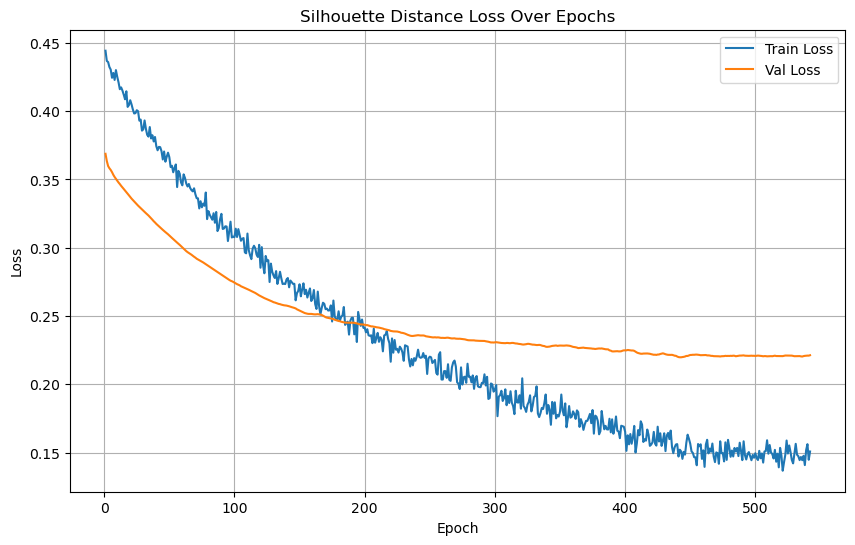

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2309], Loss: 0.0751


Test Batch [20/2309], Loss: 0.0743
Test Batch [30/2309], Loss: 0.5000
Test Batch [40/2309], Loss: 0.0277
Test Batch [50/2309], Loss: 0.5000
Test Batch [60/2309], Loss: 0.5000


Test Batch [70/2309], Loss: 0.5000


Test Batch [80/2309], Loss: 0.0480
Test Batch [90/2309], Loss: 0.5000
Test Batch [100/2309], Loss: 0.0262
Test Batch [110/2309], Loss: 0.5000
Test Batch [120/2309], Loss: 0.0397
Test Batch [130/2309], Loss: 0.0181


Test Batch [140/2309], Loss: 0.5000
Test Batch [150/2309], Loss: 0.5000
Test Batch [160/2309], Loss: 0.0141
Test Batch [170/2309], Loss: 0.0580
Test Batch [180/2309], Loss: 0.5000
Test Batch [190/2309], Loss: 0.5000
Test Batch [200/2309], Loss: 0.0311


Test Batch [210/2309], Loss: 0.0367
Test Batch [220/2309], Loss: 0.5000
Test Batch [230/2309], Loss: 0.0459
Test Batch [240/2309], Loss: 0.5000
Test Batch [250/2309], Loss: 0.0649
Test Batch [260/2309], Loss: 0.0518
Test Batch [270/2309], Loss: 0.5000


Test Batch [280/2309], Loss: 0.5000
Test Batch [290/2309], Loss: 0.5000
Test Batch [300/2309], Loss: 0.1038
Test Batch [310/2309], Loss: 0.0330
Test Batch [320/2309], Loss: 0.0953
Test Batch [330/2309], Loss: 0.5000
Test Batch [340/2309], Loss: 0.5000
Test Batch [350/2309], Loss: 0.5000


Test Batch [360/2309], Loss: 0.1246
Test Batch [370/2309], Loss: 0.0426
Test Batch [380/2309], Loss: 0.1118
Test Batch [390/2309], Loss: 0.0495
Test Batch [400/2309], Loss: 0.0387
Test Batch [410/2309], Loss: 0.0864
Test Batch [420/2309], Loss: 0.1510
Test Batch [430/2309], Loss: 0.0165


Test Batch [440/2309], Loss: 0.5000
Test Batch [450/2309], Loss: 0.0523
Test Batch [460/2309], Loss: 0.5000
Test Batch [470/2309], Loss: 0.5000
Test Batch [480/2309], Loss: 0.0790


Test Batch [490/2309], Loss: 0.5000
Test Batch [500/2309], Loss: 0.0303
Test Batch [510/2309], Loss: 0.5000
Test Batch [520/2309], Loss: 0.0614
Test Batch [530/2309], Loss: 0.0451
Test Batch [540/2309], Loss: 0.5000


Test Batch [550/2309], Loss: 0.0337
Test Batch [560/2309], Loss: 0.0616
Test Batch [570/2309], Loss: 0.0123
Test Batch [580/2309], Loss: 0.5000
Test Batch [590/2309], Loss: 0.0769
Test Batch [600/2309], Loss: 0.0496


Test Batch [610/2309], Loss: 0.5000
Test Batch [620/2309], Loss: 0.5000
Test Batch [630/2309], Loss: 0.5000
Test Batch [640/2309], Loss: 0.0146
Test Batch [650/2309], Loss: 0.0149
Test Batch [660/2309], Loss: 0.0977


Test Batch [670/2309], Loss: 0.5000
Test Batch [680/2309], Loss: 0.0738
Test Batch [690/2309], Loss: 0.0849
Test Batch [700/2309], Loss: 0.5000
Test Batch [710/2309], Loss: 0.0543
Test Batch [720/2309], Loss: 0.5000
Test Batch [730/2309], Loss: 0.1321


Test Batch [740/2309], Loss: 0.0140
Test Batch [750/2309], Loss: 0.5000
Test Batch [760/2309], Loss: 0.0727
Test Batch [770/2309], Loss: 0.0567
Test Batch [780/2309], Loss: 0.0258


Test Batch [790/2309], Loss: 0.5000
Test Batch [800/2309], Loss: 0.0149
Test Batch [810/2309], Loss: 0.0413
Test Batch [820/2309], Loss: 0.0390
Test Batch [830/2309], Loss: 0.5000


Test Batch [840/2309], Loss: 0.1119
Test Batch [850/2309], Loss: 0.1569
Test Batch [860/2309], Loss: 0.1183
Test Batch [870/2309], Loss: 0.0262
Test Batch [880/2309], Loss: 0.5000
Test Batch [890/2309], Loss: 0.0343
Test Batch [900/2309], Loss: 0.5000
Test Batch [910/2309], Loss: 0.5000


Test Batch [920/2309], Loss: 0.1180
Test Batch [930/2309], Loss: 0.0446
Test Batch [940/2309], Loss: 0.5000
Test Batch [950/2309], Loss: 0.5000
Test Batch [960/2309], Loss: 0.0113
Test Batch [970/2309], Loss: 0.0363
Test Batch [980/2309], Loss: 0.0870


Test Batch [990/2309], Loss: 0.5000
Test Batch [1000/2309], Loss: 0.1160
Test Batch [1010/2309], Loss: 0.5000
Test Batch [1020/2309], Loss: 0.0470
Test Batch [1030/2309], Loss: 0.5000
Test Batch [1040/2309], Loss: 0.5000


Test Batch [1050/2309], Loss: 0.0565
Test Batch [1060/2309], Loss: 0.0978
Test Batch [1070/2309], Loss: 0.0618
Test Batch [1080/2309], Loss: 0.1061
Test Batch [1090/2309], Loss: 0.0095
Test Batch [1100/2309], Loss: 0.5000


Test Batch [1110/2309], Loss: 0.5000
Test Batch [1120/2309], Loss: 0.0962
Test Batch [1130/2309], Loss: 0.0295
Test Batch [1140/2309], Loss: 0.0754
Test Batch [1150/2309], Loss: 0.1010


Test Batch [1160/2309], Loss: 0.0741
Test Batch [1170/2309], Loss: 0.1220
Test Batch [1180/2309], Loss: 0.5000
Test Batch [1190/2309], Loss: 0.1150
Test Batch [1200/2309], Loss: 0.1066


Test Batch [1210/2309], Loss: 0.0399
Test Batch [1220/2309], Loss: 0.0180
Test Batch [1230/2309], Loss: 0.0187
Test Batch [1240/2309], Loss: 0.2611


Test Batch [1250/2309], Loss: 0.5000
Test Batch [1260/2309], Loss: 0.1632
Test Batch [1270/2309], Loss: 0.1131
Test Batch [1280/2309], Loss: 0.0576


Test Batch [1290/2309], Loss: 0.0891
Test Batch [1300/2309], Loss: 0.1368
Test Batch [1310/2309], Loss: 0.0774


Test Batch [1320/2309], Loss: 0.1568
Test Batch [1330/2309], Loss: 0.1263
Test Batch [1340/2309], Loss: 0.0206
Test Batch [1350/2309], Loss: 0.1494


Test Batch [1360/2309], Loss: 0.1752
Test Batch [1370/2309], Loss: 0.0994
Test Batch [1380/2309], Loss: 0.1317


Test Batch [1390/2309], Loss: 0.0892
Test Batch [1400/2309], Loss: 0.1024
Test Batch [1410/2309], Loss: 0.0902


Test Batch [1420/2309], Loss: 0.1078
Test Batch [1430/2309], Loss: 0.5000
Test Batch [1440/2309], Loss: 0.0638
Test Batch [1450/2309], Loss: 0.1364


Test Batch [1460/2309], Loss: 0.1200
Test Batch [1470/2309], Loss: 0.5000
Test Batch [1480/2309], Loss: 0.0931
Test Batch [1490/2309], Loss: 0.1061
Test Batch [1500/2309], Loss: 0.0740


Test Batch [1510/2309], Loss: 0.1121
Test Batch [1520/2309], Loss: 0.0460
Test Batch [1530/2309], Loss: 0.0733
Test Batch [1540/2309], Loss: 0.1494


Test Batch [1550/2309], Loss: 0.1013
Test Batch [1560/2309], Loss: 0.0835
Test Batch [1570/2309], Loss: 0.1421
Test Batch [1580/2309], Loss: 0.1021


Test Batch [1590/2309], Loss: 0.0930
Test Batch [1600/2309], Loss: 0.0731
Test Batch [1610/2309], Loss: 0.0923
Test Batch [1620/2309], Loss: 0.1058


Test Batch [1630/2309], Loss: 0.1433
Test Batch [1640/2309], Loss: 0.0987
Test Batch [1650/2309], Loss: 0.5000
Test Batch [1660/2309], Loss: 0.1195
Test Batch [1670/2309], Loss: 0.1613


Test Batch [1680/2309], Loss: 0.1130
Test Batch [1690/2309], Loss: 0.0895
Test Batch [1700/2309], Loss: 0.1050
Test Batch [1710/2309], Loss: 0.0663
Test Batch [1720/2309], Loss: 0.5000


Test Batch [1730/2309], Loss: 0.0858
Test Batch [1740/2309], Loss: 0.5000
Test Batch [1750/2309], Loss: 0.0408
Test Batch [1760/2309], Loss: 0.0487
Test Batch [1770/2309], Loss: 0.0397
Test Batch [1780/2309], Loss: 0.0646


Test Batch [1790/2309], Loss: 0.0816
Test Batch [1800/2309], Loss: 0.0799
Test Batch [1810/2309], Loss: 0.1319
Test Batch [1820/2309], Loss: 0.1008
Test Batch [1830/2309], Loss: 0.0860
Test Batch [1840/2309], Loss: 0.1021


Test Batch [1850/2309], Loss: 0.1179
Test Batch [1860/2309], Loss: 0.0733
Test Batch [1870/2309], Loss: 0.0643
Test Batch [1880/2309], Loss: 0.0895
Test Batch [1890/2309], Loss: 0.0972


Test Batch [1900/2309], Loss: 0.1370
Test Batch [1910/2309], Loss: 0.1265
Test Batch [1920/2309], Loss: 0.0711
Test Batch [1930/2309], Loss: 0.1151


Test Batch [1940/2309], Loss: 0.1355
Test Batch [1950/2309], Loss: 0.1709
Test Batch [1960/2309], Loss: 0.1427
Test Batch [1970/2309], Loss: 0.0814
Test Batch [1980/2309], Loss: 0.0720
Test Batch [1990/2309], Loss: 0.0596


Test Batch [2000/2309], Loss: 0.0560
Test Batch [2010/2309], Loss: 0.0438
Test Batch [2020/2309], Loss: 0.0620
Test Batch [2030/2309], Loss: 0.0762
Test Batch [2040/2309], Loss: 0.0918
Test Batch [2050/2309], Loss: 0.0732


Test Batch [2060/2309], Loss: 0.1383
Test Batch [2070/2309], Loss: 0.1343
Test Batch [2080/2309], Loss: 0.2085
Test Batch [2090/2309], Loss: 0.5000
Test Batch [2100/2309], Loss: 0.1085
Test Batch [2110/2309], Loss: 0.1569
Test Batch [2120/2309], Loss: 0.1571
Test Batch [2130/2309], Loss: 0.5000


Test Batch [2140/2309], Loss: 0.5000
Test Batch [2150/2309], Loss: 0.5000
Test Batch [2160/2309], Loss: 0.5000
Test Batch [2170/2309], Loss: 0.5000
Test Batch [2180/2309], Loss: 0.0672
Test Batch [2190/2309], Loss: 0.0244
Test Batch [2200/2309], Loss: 0.1317


Test Batch [2210/2309], Loss: 0.0277
Test Batch [2220/2309], Loss: 0.5000
Test Batch [2230/2309], Loss: 0.5000
Test Batch [2240/2309], Loss: 0.5000
Test Batch [2250/2309], Loss: 0.5000
Test Batch [2260/2309], Loss: 0.5000


Test Batch [2270/2309], Loss: 0.5000
Test Batch [2280/2309], Loss: 0.1301
Test Batch [2290/2309], Loss: 0.5000
Test Batch [2300/2309], Loss: 0.5000

Test Loss: 0.2078


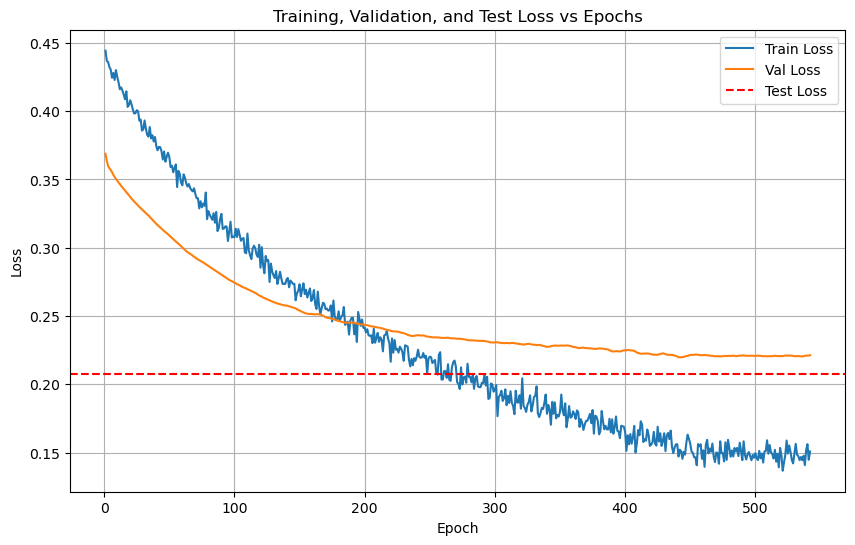

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2309 for test dataset.
  Processed batch 20/2309 for test dataset.


  Processed batch 30/2309 for test dataset.
  Processed batch 40/2309 for test dataset.
  Processed batch 50/2309 for test dataset.


  Processed batch 60/2309 for test dataset.
  Processed batch 70/2309 for test dataset.
  Processed batch 80/2309 for test dataset.
  Processed batch 90/2309 for test dataset.


  Processed batch 100/2309 for test dataset.
  Processed batch 110/2309 for test dataset.
  Processed batch 120/2309 for test dataset.
  Processed batch 130/2309 for test dataset.


  Processed batch 140/2309 for test dataset.
  Processed batch 150/2309 for test dataset.
  Processed batch 160/2309 for test dataset.


  Processed batch 170/2309 for test dataset.
  Processed batch 180/2309 for test dataset.
  Processed batch 190/2309 for test dataset.
  Processed batch 200/2309 for test dataset.


  Processed batch 210/2309 for test dataset.
  Processed batch 220/2309 for test dataset.


  Processed batch 230/2309 for test dataset.
  Processed batch 240/2309 for test dataset.
  Processed batch 250/2309 for test dataset.


  Processed batch 260/2309 for test dataset.
  Processed batch 270/2309 for test dataset.
  Processed batch 280/2309 for test dataset.


  Processed batch 290/2309 for test dataset.
  Processed batch 300/2309 for test dataset.
  Processed batch 310/2309 for test dataset.


  Processed batch 320/2309 for test dataset.
  Processed batch 330/2309 for test dataset.


  Processed batch 340/2309 for test dataset.
  Processed batch 350/2309 for test dataset.
  Processed batch 360/2309 for test dataset.


  Processed batch 370/2309 for test dataset.
  Processed batch 380/2309 for test dataset.
  Processed batch 390/2309 for test dataset.
  Processed batch 400/2309 for test dataset.


  Processed batch 410/2309 for test dataset.
  Processed batch 420/2309 for test dataset.
  Processed batch 430/2309 for test dataset.


  Processed batch 440/2309 for test dataset.
  Processed batch 450/2309 for test dataset.
  Processed batch 460/2309 for test dataset.


  Processed batch 470/2309 for test dataset.
  Processed batch 480/2309 for test dataset.
  Processed batch 490/2309 for test dataset.


  Processed batch 500/2309 for test dataset.
  Processed batch 510/2309 for test dataset.
  Processed batch 520/2309 for test dataset.


  Processed batch 530/2309 for test dataset.
  Processed batch 540/2309 for test dataset.
  Processed batch 550/2309 for test dataset.
  Processed batch 560/2309 for test dataset.


  Processed batch 570/2309 for test dataset.
  Processed batch 580/2309 for test dataset.
  Processed batch 590/2309 for test dataset.


  Processed batch 600/2309 for test dataset.
  Processed batch 610/2309 for test dataset.
  Processed batch 620/2309 for test dataset.
  Processed batch 630/2309 for test dataset.


  Processed batch 640/2309 for test dataset.
  Processed batch 650/2309 for test dataset.
  Processed batch 660/2309 for test dataset.
  Processed batch 670/2309 for test dataset.


  Processed batch 680/2309 for test dataset.
  Processed batch 690/2309 for test dataset.


  Processed batch 700/2309 for test dataset.
  Processed batch 710/2309 for test dataset.
  Processed batch 720/2309 for test dataset.


  Processed batch 730/2309 for test dataset.
  Processed batch 740/2309 for test dataset.
  Processed batch 750/2309 for test dataset.
  Processed batch 760/2309 for test dataset.


  Processed batch 770/2309 for test dataset.
  Processed batch 780/2309 for test dataset.
  Processed batch 790/2309 for test dataset.


  Processed batch 800/2309 for test dataset.
  Processed batch 810/2309 for test dataset.
  Processed batch 820/2309 for test dataset.


  Processed batch 830/2309 for test dataset.
  Processed batch 840/2309 for test dataset.
  Processed batch 850/2309 for test dataset.
  Processed batch 860/2309 for test dataset.


  Processed batch 870/2309 for test dataset.
  Processed batch 880/2309 for test dataset.
  Processed batch 890/2309 for test dataset.


  Processed batch 900/2309 for test dataset.
  Processed batch 910/2309 for test dataset.
  Processed batch 920/2309 for test dataset.
  Processed batch 930/2309 for test dataset.


  Processed batch 940/2309 for test dataset.
  Processed batch 950/2309 for test dataset.
  Processed batch 960/2309 for test dataset.


  Processed batch 970/2309 for test dataset.
  Processed batch 980/2309 for test dataset.
  Processed batch 990/2309 for test dataset.


  Processed batch 1000/2309 for test dataset.
  Processed batch 1010/2309 for test dataset.
  Processed batch 1020/2309 for test dataset.
  Processed batch 1030/2309 for test dataset.


  Processed batch 1040/2309 for test dataset.
  Processed batch 1050/2309 for test dataset.
  Processed batch 1060/2309 for test dataset.
  Processed batch 1070/2309 for test dataset.


  Processed batch 1080/2309 for test dataset.
  Processed batch 1090/2309 for test dataset.
  Processed batch 1100/2309 for test dataset.


  Processed batch 1110/2309 for test dataset.
  Processed batch 1120/2309 for test dataset.
  Processed batch 1130/2309 for test dataset.


  Processed batch 1140/2309 for test dataset.
  Processed batch 1150/2309 for test dataset.
  Processed batch 1160/2309 for test dataset.


  Processed batch 1170/2309 for test dataset.
  Processed batch 1180/2309 for test dataset.
  Processed batch 1190/2309 for test dataset.
  Processed batch 1200/2309 for test dataset.


  Processed batch 1210/2309 for test dataset.
  Processed batch 1220/2309 for test dataset.
  Processed batch 1230/2309 for test dataset.
  Processed batch 1240/2309 for test dataset.


  Processed batch 1250/2309 for test dataset.
  Processed batch 1260/2309 for test dataset.
  Processed batch 1270/2309 for test dataset.


  Processed batch 1280/2309 for test dataset.
  Processed batch 1290/2309 for test dataset.
  Processed batch 1300/2309 for test dataset.
  Processed batch 1310/2309 for test dataset.


  Processed batch 1320/2309 for test dataset.
  Processed batch 1330/2309 for test dataset.
  Processed batch 1340/2309 for test dataset.


  Processed batch 1350/2309 for test dataset.
  Processed batch 1360/2309 for test dataset.


  Processed batch 1370/2309 for test dataset.
  Processed batch 1380/2309 for test dataset.
  Processed batch 1390/2309 for test dataset.
  Processed batch 1400/2309 for test dataset.


  Processed batch 1410/2309 for test dataset.
  Processed batch 1420/2309 for test dataset.
  Processed batch 1430/2309 for test dataset.


  Processed batch 1440/2309 for test dataset.
  Processed batch 1450/2309 for test dataset.
  Processed batch 1460/2309 for test dataset.
  Processed batch 1470/2309 for test dataset.


  Processed batch 1480/2309 for test dataset.
  Processed batch 1490/2309 for test dataset.
  Processed batch 1500/2309 for test dataset.
  Processed batch 1510/2309 for test dataset.


  Processed batch 1520/2309 for test dataset.
  Processed batch 1530/2309 for test dataset.
  Processed batch 1540/2309 for test dataset.


  Processed batch 1550/2309 for test dataset.
  Processed batch 1560/2309 for test dataset.
  Processed batch 1570/2309 for test dataset.


  Processed batch 1580/2309 for test dataset.
  Processed batch 1590/2309 for test dataset.
  Processed batch 1600/2309 for test dataset.


  Processed batch 1610/2309 for test dataset.
  Processed batch 1620/2309 for test dataset.
  Processed batch 1630/2309 for test dataset.


  Processed batch 1640/2309 for test dataset.
  Processed batch 1650/2309 for test dataset.
  Processed batch 1660/2309 for test dataset.
  Processed batch 1670/2309 for test dataset.


  Processed batch 1680/2309 for test dataset.
  Processed batch 1690/2309 for test dataset.
  Processed batch 1700/2309 for test dataset.


  Processed batch 1710/2309 for test dataset.
  Processed batch 1720/2309 for test dataset.
  Processed batch 1730/2309 for test dataset.
  Processed batch 1740/2309 for test dataset.


  Processed batch 1750/2309 for test dataset.
  Processed batch 1760/2309 for test dataset.
  Processed batch 1770/2309 for test dataset.
  Processed batch 1780/2309 for test dataset.


  Processed batch 1790/2309 for test dataset.
  Processed batch 1800/2309 for test dataset.
  Processed batch 1810/2309 for test dataset.


  Processed batch 1820/2309 for test dataset.
  Processed batch 1830/2309 for test dataset.


  Processed batch 1840/2309 for test dataset.
  Processed batch 1850/2309 for test dataset.
  Processed batch 1860/2309 for test dataset.


  Processed batch 1870/2309 for test dataset.
  Processed batch 1880/2309 for test dataset.
  Processed batch 1890/2309 for test dataset.


  Processed batch 1900/2309 for test dataset.
  Processed batch 1910/2309 for test dataset.
  Processed batch 1920/2309 for test dataset.


  Processed batch 1930/2309 for test dataset.
  Processed batch 1940/2309 for test dataset.
  Processed batch 1950/2309 for test dataset.
  Processed batch 1960/2309 for test dataset.


  Processed batch 1970/2309 for test dataset.
  Processed batch 1980/2309 for test dataset.
  Processed batch 1990/2309 for test dataset.
  Processed batch 2000/2309 for test dataset.


  Processed batch 2010/2309 for test dataset.
  Processed batch 2020/2309 for test dataset.
  Processed batch 2030/2309 for test dataset.
  Processed batch 2040/2309 for test dataset.


  Processed batch 2050/2309 for test dataset.
  Processed batch 2060/2309 for test dataset.
  Processed batch 2070/2309 for test dataset.


  Processed batch 2080/2309 for test dataset.
  Processed batch 2090/2309 for test dataset.
  Processed batch 2100/2309 for test dataset.


  Processed batch 2110/2309 for test dataset.
  Processed batch 2120/2309 for test dataset.
  Processed batch 2130/2309 for test dataset.


  Processed batch 2140/2309 for test dataset.
  Processed batch 2150/2309 for test dataset.
  Processed batch 2160/2309 for test dataset.


  Processed batch 2170/2309 for test dataset.
  Processed batch 2180/2309 for test dataset.
  Processed batch 2190/2309 for test dataset.


  Processed batch 2200/2309 for test dataset.
  Processed batch 2210/2309 for test dataset.
  Processed batch 2220/2309 for test dataset.
  Processed batch 2230/2309 for test dataset.


  Processed batch 2240/2309 for test dataset.
  Processed batch 2250/2309 for test dataset.


  Processed batch 2260/2309 for test dataset.
  Processed batch 2270/2309 for test dataset.
  Processed batch 2280/2309 for test dataset.


  Processed batch 2290/2309 for test dataset.
  Processed batch 2300/2309 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.75      0.60      0.67         5
           4       0.71      1.00      0.83         5
           5       0.80      0.80      0.80         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45


LOG: Evaluating on the test set...
Test Accuracy: 96.68%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65926
           1       0.93      0.88      0.91      7553
           2       0.72      0.81      0.77      3045
           3       0.78      0.73      0.75      2640
           4       0.88      0.94      0.91      6539
           5       0.88      0.92      0.90      9203
           6       0.90      0.92      0.91      7242
           7       1.00      0.99      0.99     42781
           8       0.97      0.99      0.98      2818

    accuracy                           0.97    147747
   macro avg       0.90      0.91      0.90    147747
weighted avg       0.97      0.97      0.97    147747

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6736  |  Val Loss: 2.6061
Validation loss improved from inf to 2.6061.
[Epoch 2/1000] Train Loss: 2.4977  |  Val Loss: 2.4420
Validation loss improved from 2.6061 to 2.4420.
[Epoch 3/1000] Train Loss: 2.3430  |  Val Loss: 2.2926
Validation loss improved from 2.4420 to 2.2926.
[Epoch 4/1000] Train Loss: 2.1967  |  Val Loss: 2.1565
Validation loss improved from 2.2926 to 2.1565.
[Epoch 5/1000] Train Loss: 2.0673  |  Val Loss: 2.0340
Validation loss improved from 2.1565 to 2.0340.
[Epoch 6/1000] Train Loss: 1.9502  |  Val Loss: 1.9223
Validation loss improved from 2.0340 to 1.9223.
[Epoch 7/1000] Train Loss: 1.8426  |  Val Loss: 1.8161
Validation loss improved from 1.9223 to 1.8161.
[Epoch 8/1000] Train Loss: 1.7380  |  Val Loss: 1.7150
Validation loss improved from 1.8161 to 1.7150.
[Epoch 9/1000] Train Loss: 1.6401  |  Val Loss: 1.6183
Validation loss improved from 1.7150 to 1.6183.
[Epoch 10/1000] Train Loss: 1.5485  |  Val Loss: 1.5268
Validation loss impr

[Epoch 14/1000] Train Loss: 1.2355  |  Val Loss: 1.2270
Validation loss improved from 1.2911 to 1.2270.
[Epoch 15/1000] Train Loss: 1.1747  |  Val Loss: 1.1692
Validation loss improved from 1.2270 to 1.1692.
[Epoch 16/1000] Train Loss: 1.1184  |  Val Loss: 1.1170
Validation loss improved from 1.1692 to 1.1170.
[Epoch 17/1000] Train Loss: 1.0680  |  Val Loss: 1.0684
Validation loss improved from 1.1170 to 1.0684.


[Epoch 18/1000] Train Loss: 1.0189  |  Val Loss: 1.0230
Validation loss improved from 1.0684 to 1.0230.
[Epoch 19/1000] Train Loss: 0.9736  |  Val Loss: 0.9820
Validation loss improved from 1.0230 to 0.9820.
[Epoch 20/1000] Train Loss: 0.9307  |  Val Loss: 0.9444
Validation loss improved from 0.9820 to 0.9444.
[Epoch 21/1000] Train Loss: 0.8917  |  Val Loss: 0.9089
Validation loss improved from 0.9444 to 0.9089.
[Epoch 22/1000] Train Loss: 0.8543  |  Val Loss: 0.8764
Validation loss improved from 0.9089 to 0.8764.
[Epoch 23/1000] Train Loss: 0.8202  |  Val Loss: 0.8456
Validation loss improved from 0.8764 to 0.8456.
[Epoch 24/1000] Train Loss: 0.7879  |  Val Loss: 0.8167
Validation loss improved from 0.8456 to 0.8167.
[Epoch 25/1000] Train Loss: 0.7573  |  Val Loss: 0.7900
Validation loss improved from 0.8167 to 0.7900.
[Epoch 26/1000] Train Loss: 0.7284  |  Val Loss: 0.7645
Validation loss improved from 0.7900 to 0.7645.
[Epoch 27/1000] Train Loss: 0.7012  |  Val Loss: 0.7406
Validati

[Epoch 31/1000] Train Loss: 0.6055  |  Val Loss: 0.6552
Validation loss improved from 0.6749 to 0.6552.
[Epoch 32/1000] Train Loss: 0.5839  |  Val Loss: 0.6363
Validation loss improved from 0.6552 to 0.6363.
[Epoch 33/1000] Train Loss: 0.5640  |  Val Loss: 0.6179
Validation loss improved from 0.6363 to 0.6179.
[Epoch 34/1000] Train Loss: 0.5443  |  Val Loss: 0.6004
Validation loss improved from 0.6179 to 0.6004.


[Epoch 35/1000] Train Loss: 0.5255  |  Val Loss: 0.5836
Validation loss improved from 0.6004 to 0.5836.
[Epoch 36/1000] Train Loss: 0.5069  |  Val Loss: 0.5673
Validation loss improved from 0.5836 to 0.5673.
[Epoch 37/1000] Train Loss: 0.4893  |  Val Loss: 0.5516
Validation loss improved from 0.5673 to 0.5516.
[Epoch 38/1000] Train Loss: 0.4718  |  Val Loss: 0.5363
Validation loss improved from 0.5516 to 0.5363.
[Epoch 39/1000] Train Loss: 0.4551  |  Val Loss: 0.5216
Validation loss improved from 0.5363 to 0.5216.
[Epoch 40/1000] Train Loss: 0.4392  |  Val Loss: 0.5074
Validation loss improved from 0.5216 to 0.5074.
[Epoch 41/1000] Train Loss: 0.4239  |  Val Loss: 0.4941
Validation loss improved from 0.5074 to 0.4941.
[Epoch 42/1000] Train Loss: 0.4090  |  Val Loss: 0.4809
Validation loss improved from 0.4941 to 0.4809.
[Epoch 43/1000] Train Loss: 0.3947  |  Val Loss: 0.4683
Validation loss improved from 0.4809 to 0.4683.
[Epoch 44/1000] Train Loss: 0.3812  |  Val Loss: 0.4559
Validati

[Epoch 48/1000] Train Loss: 0.3327  |  Val Loss: 0.4130
Validation loss improved from 0.4229 to 0.4130.
[Epoch 49/1000] Train Loss: 0.3222  |  Val Loss: 0.4041
Validation loss improved from 0.4130 to 0.4041.
[Epoch 50/1000] Train Loss: 0.3118  |  Val Loss: 0.3956
Validation loss improved from 0.4041 to 0.3956.
[Epoch 51/1000] Train Loss: 0.3022  |  Val Loss: 0.3872
Validation loss improved from 0.3956 to 0.3872.


[Epoch 52/1000] Train Loss: 0.2929  |  Val Loss: 0.3786
Validation loss improved from 0.3872 to 0.3786.
[Epoch 53/1000] Train Loss: 0.2841  |  Val Loss: 0.3712
Validation loss improved from 0.3786 to 0.3712.
[Epoch 54/1000] Train Loss: 0.2752  |  Val Loss: 0.3636
Validation loss improved from 0.3712 to 0.3636.
[Epoch 55/1000] Train Loss: 0.2672  |  Val Loss: 0.3563
Validation loss improved from 0.3636 to 0.3563.
[Epoch 56/1000] Train Loss: 0.2592  |  Val Loss: 0.3496
Validation loss improved from 0.3563 to 0.3496.
[Epoch 57/1000] Train Loss: 0.2518  |  Val Loss: 0.3432
Validation loss improved from 0.3496 to 0.3432.
[Epoch 58/1000] Train Loss: 0.2445  |  Val Loss: 0.3374
Validation loss improved from 0.3432 to 0.3374.
[Epoch 59/1000] Train Loss: 0.2376  |  Val Loss: 0.3312
Validation loss improved from 0.3374 to 0.3312.
[Epoch 60/1000] Train Loss: 0.2308  |  Val Loss: 0.3261
Validation loss improved from 0.3312 to 0.3261.
[Epoch 61/1000] Train Loss: 0.2245  |  Val Loss: 0.3206
Validati

[Epoch 63/1000] Train Loss: 0.2122  |  Val Loss: 0.3110
Validation loss improved from 0.3152 to 0.3110.
[Epoch 64/1000] Train Loss: 0.2067  |  Val Loss: 0.3066
Validation loss improved from 0.3110 to 0.3066.
[Epoch 65/1000] Train Loss: 0.2012  |  Val Loss: 0.3026
Validation loss improved from 0.3066 to 0.3026.
[Epoch 66/1000] Train Loss: 0.1959  |  Val Loss: 0.2983
Validation loss improved from 0.3026 to 0.2983.
[Epoch 67/1000] Train Loss: 0.1909  |  Val Loss: 0.2946
Validation loss improved from 0.2983 to 0.2946.
[Epoch 68/1000] Train Loss: 0.1859  |  Val Loss: 0.2911
Validation loss improved from 0.2946 to 0.2911.


[Epoch 69/1000] Train Loss: 0.1815  |  Val Loss: 0.2874
Validation loss improved from 0.2911 to 0.2874.
[Epoch 70/1000] Train Loss: 0.1770  |  Val Loss: 0.2842
Validation loss improved from 0.2874 to 0.2842.
[Epoch 71/1000] Train Loss: 0.1728  |  Val Loss: 0.2811
Validation loss improved from 0.2842 to 0.2811.
[Epoch 72/1000] Train Loss: 0.1689  |  Val Loss: 0.2779
Validation loss improved from 0.2811 to 0.2779.
[Epoch 73/1000] Train Loss: 0.1649  |  Val Loss: 0.2753
Validation loss improved from 0.2779 to 0.2753.
[Epoch 74/1000] Train Loss: 0.1611  |  Val Loss: 0.2730
Validation loss improved from 0.2753 to 0.2730.
[Epoch 75/1000] Train Loss: 0.1576  |  Val Loss: 0.2695
Validation loss improved from 0.2730 to 0.2695.
[Epoch 76/1000] Train Loss: 0.1541  |  Val Loss: 0.2669
Validation loss improved from 0.2695 to 0.2669.
[Epoch 77/1000] Train Loss: 0.1508  |  Val Loss: 0.2643
Validation loss improved from 0.2669 to 0.2643.
[Epoch 78/1000] Train Loss: 0.1476  |  Val Loss: 0.2609
Validati

[Epoch 80/1000] Train Loss: 0.1419  |  Val Loss: 0.2567
Validation loss improved from 0.2587 to 0.2567.
[Epoch 81/1000] Train Loss: 0.1390  |  Val Loss: 0.2533
Validation loss improved from 0.2567 to 0.2533.
[Epoch 82/1000] Train Loss: 0.1361  |  Val Loss: 0.2513
Validation loss improved from 0.2533 to 0.2513.
[Epoch 83/1000] Train Loss: 0.1338  |  Val Loss: 0.2489
Validation loss improved from 0.2513 to 0.2489.
[Epoch 84/1000] Train Loss: 0.1311  |  Val Loss: 0.2478
Validation loss improved from 0.2489 to 0.2478.
[Epoch 85/1000] Train Loss: 0.1287  |  Val Loss: 0.2465
Validation loss improved from 0.2478 to 0.2465.


[Epoch 86/1000] Train Loss: 0.1262  |  Val Loss: 0.2452
Validation loss improved from 0.2465 to 0.2452.
[Epoch 87/1000] Train Loss: 0.1241  |  Val Loss: 0.2434
Validation loss improved from 0.2452 to 0.2434.
[Epoch 88/1000] Train Loss: 0.1218  |  Val Loss: 0.2415
Validation loss improved from 0.2434 to 0.2415.
[Epoch 89/1000] Train Loss: 0.1197  |  Val Loss: 0.2403
Validation loss improved from 0.2415 to 0.2403.
[Epoch 90/1000] Train Loss: 0.1177  |  Val Loss: 0.2390
Validation loss improved from 0.2403 to 0.2390.
[Epoch 91/1000] Train Loss: 0.1157  |  Val Loss: 0.2379
Validation loss improved from 0.2390 to 0.2379.
[Epoch 92/1000] Train Loss: 0.1137  |  Val Loss: 0.2370
Validation loss improved from 0.2379 to 0.2370.
[Epoch 93/1000] Train Loss: 0.1119  |  Val Loss: 0.2360
Validation loss improved from 0.2370 to 0.2360.
[Epoch 94/1000] Train Loss: 0.1103  |  Val Loss: 0.2345
Validation loss improved from 0.2360 to 0.2345.
[Epoch 95/1000] Train Loss: 0.1086  |  Val Loss: 0.2349
!! Valid

[Epoch 98/1000] Train Loss: 0.1037  |  Val Loss: 0.2307
Validation loss improved from 0.2321 to 0.2307.
[Epoch 99/1000] Train Loss: 0.1022  |  Val Loss: 0.2298
Validation loss improved from 0.2307 to 0.2298.
[Epoch 100/1000] Train Loss: 0.1007  |  Val Loss: 0.2294
Validation loss improved from 0.2298 to 0.2294.
[Epoch 101/1000] Train Loss: 0.0995  |  Val Loss: 0.2296
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 0.0980  |  Val Loss: 0.2286
Validation loss improved from 0.2294 to 0.2286.


[Epoch 103/1000] Train Loss: 0.0967  |  Val Loss: 0.2277
Validation loss improved from 0.2286 to 0.2277.
[Epoch 104/1000] Train Loss: 0.0954  |  Val Loss: 0.2265
Validation loss improved from 0.2277 to 0.2265.
[Epoch 105/1000] Train Loss: 0.0942  |  Val Loss: 0.2251
Validation loss improved from 0.2265 to 0.2251.
[Epoch 106/1000] Train Loss: 0.0929  |  Val Loss: 0.2243
Validation loss improved from 0.2251 to 0.2243.
[Epoch 107/1000] Train Loss: 0.0919  |  Val Loss: 0.2233
Validation loss improved from 0.2243 to 0.2233.
[Epoch 108/1000] Train Loss: 0.0907  |  Val Loss: 0.2241
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 109/1000] Train Loss: 0.0897  |  Val Loss: 0.2225
Validation loss improved from 0.2233 to 0.2225.
[Epoch 110/1000] Train Loss: 0.0885  |  Val Loss: 0.2224
Validation loss improved from 0.2225 to 0.2224.
[Epoch 111/1000] Train Loss: 0.0876  |  Val Loss: 0.2225
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 112/1000] Train Loss: 0.0865  |  Val

[Epoch 114/1000] Train Loss: 0.0848  |  Val Loss: 0.2175
Validation loss improved from 0.2194 to 0.2175.
[Epoch 115/1000] Train Loss: 0.0837  |  Val Loss: 0.2176
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 0.0828  |  Val Loss: 0.2183
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 117/1000] Train Loss: 0.0821  |  Val Loss: 0.2165
Validation loss improved from 0.2175 to 0.2165.
[Epoch 118/1000] Train Loss: 0.0809  |  Val Loss: 0.2167
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 119/1000] Train Loss: 0.0803  |  Val Loss: 0.2173
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 120/1000] Train Loss: 0.0793  |  Val Loss: 0.2167
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 121/1000] Train Loss: 0.0786  |  Val Loss: 0.2172
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 122/1000] Train Loss: 0.0780  |  Val Loss: 0.2157
Validation loss improved from 0.2165 to 0.2157.
[Epoch 123/1000] Train Loss: 0.0770  |  Val Loss: 0.2161
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 124/1000] Train Loss: 0.0763  |  Val Loss: 0.2161
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 125/1000] Train Loss: 0.0755  |  Val Loss: 0.2152
Validation loss improved from 0.2157 to 0.2152.
[Epoch 126/1000] Train Loss: 0.0749  |  Val Loss: 0.2149
Validation loss improved from 0.2152 to 0.2149.
[Epoch 127/1000] Train Loss: 0.0742  |  Val Loss: 0.2149
Validation loss improved from 0.2149 to 0.2149.
[Epoch 128/1000] Train Loss: 0.0736  |  Val Loss: 0.2147
Validation loss improved from 0.2149 to 0.2147.
[Epoch 129/1000] Train Loss: 0.

[Epoch 131/1000] Train Loss: 0.0716  |  Val Loss: 0.2134
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 132/1000] Train Loss: 0.0711  |  Val Loss: 0.2132
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 133/1000] Train Loss: 0.0705  |  Val Loss: 0.2139
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 134/1000] Train Loss: 0.0699  |  Val Loss: 0.2145
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 135/1000] Train Loss: 0.0693  |  Val Loss: 0.2139
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 136/1000] Train Loss: 0.0687  |  Val Loss: 0.2131
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 137/1000] Train Loss: 0.0680  |  Val Loss: 0.2129
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 138/1000] Train Loss: 0.0677  |  Val Loss: 0.2121
Validation loss improved from 0.2128 to 0.2121.
[Epoch 139/1000] Train Loss: 0.0670  |  Val Loss: 0.2119
Validation loss improved from 0.2121 to 0.2119.
[Epoch 140/1000] Train Loss: 0.0665  |  Val Loss: 0.2114
Validation loss improved from 0.2119 to 0.2114.
[Epoch 141/1000] Train Loss: 0.0660  |  Val Loss: 0.2127
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 142/1000] Train Loss: 0.0654  |  Val Loss: 0.2127
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 143/1000] Train Loss: 0.0650  |  Val Loss: 0.2125
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 144/1000] Train Loss: 0.0644  |  Val Loss: 0.2120
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 145/1000] Train Loss: 0.0639  |  Val Loss: 0.2116
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 146/1000] Train Loss: 0.0636  |  Val Loss: 0.2122
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 147/1000] Tr

[Epoch 148/1000] Train Loss: 0.0625  |  Val Loss: 0.2110
Validation loss improved from 0.2114 to 0.2110.
[Epoch 149/1000] Train Loss: 0.0621  |  Val Loss: 0.2117
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 150/1000] Train Loss: 0.0616  |  Val Loss: 0.2120
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 151/1000] Train Loss: 0.0611  |  Val Loss: 0.2115
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 152/1000] Train Loss: 0.0607  |  Val Loss: 0.2107
Validation loss improved from 0.2110 to 0.2107.
[Epoch 153/1000] Train Loss: 0.0604  |  Val Loss: 0.2111
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 154/1000] Train Loss: 0.0601  |  Val Loss: 0.2105
Validation loss improved from 0.2107 to 0.2105.


[Epoch 155/1000] Train Loss: 0.0594  |  Val Loss: 0.2114
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 156/1000] Train Loss: 0.0589  |  Val Loss: 0.2112
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 157/1000] Train Loss: 0.0585  |  Val Loss: 0.2114
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 158/1000] Train Loss: 0.0581  |  Val Loss: 0.2115
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 159/1000] Train Loss: 0.0577  |  Val Loss: 0.2104
Validation loss improved from 0.2105 to 0.2104.
[Epoch 160/1000] Train Loss: 0.0573  |  Val Loss: 0.2101
Validation loss improved from 0.2104 to 0.2101.
[Epoch 161/1000] Train Loss: 0.0569  |  Val Loss: 0.2089
Validation loss improved from 0.2101 to 0.2089.
[Epoch 162/1000] Train Loss: 0.0566  |  Val Loss: 0.2097
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 163/1000] Train Loss: 0.0562  |  Val Loss: 0.2108
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 164/1000] Tr

[Epoch 166/1000] Train Loss: 0.0551  |  Val Loss: 0.2102
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 167/1000] Train Loss: 0.0547  |  Val Loss: 0.2099
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 168/1000] Train Loss: 0.0543  |  Val Loss: 0.2091
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 169/1000] Train Loss: 0.0540  |  Val Loss: 0.2087
Validation loss improved from 0.2089 to 0.2087.
[Epoch 170/1000] Train Loss: 0.0538  |  Val Loss: 0.2086
Validation loss improved from 0.2087 to 0.2086.
[Epoch 171/1000] Train Loss: 0.0535  |  Val Loss: 0.2098
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 172/1000] Train Loss: 0.0532  |  Val Loss: 0.2082
Validation loss improved from 0.2086 to 0.2082.


[Epoch 173/1000] Train Loss: 0.0528  |  Val Loss: 0.2083
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 174/1000] Train Loss: 0.0523  |  Val Loss: 0.2087
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 175/1000] Train Loss: 0.0520  |  Val Loss: 0.2088
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 176/1000] Train Loss: 0.0518  |  Val Loss: 0.2103
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 177/1000] Train Loss: 0.0515  |  Val Loss: 0.2116
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 178/1000] Train Loss: 0.0513  |  Val Loss: 0.2098
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 179/1000] Train Loss: 0.0507  |  Val Loss: 0.2107
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 180/1000] Train Loss: 0.0504  |  Val Loss: 0.2112
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 181/1000] Train Loss: 0.0500  |  Val Loss: 0.2121
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 182/1000] Train Loss: 0.0498  |  Val Loss: 0.2115
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 183/1000] Train Loss: 0.0494  |  Val Loss: 0.2120
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 184/1000] Train Loss: 0.0490  |  Val Loss: 0.2112
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 185/1000] Train Loss: 0.0489  |  Val Loss: 0.2114
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 186/1000] Train Loss: 0.0484  |  Val Loss: 0.2100
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 187/1000] Train Loss: 0.0481  |  Val Loss: 0.2106
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 188/1000] Train Loss: 0.0478  |  Val Loss: 0.2108
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 189/1000] Train Loss: 0.0477  |  Val Loss: 0.2121
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 190/1000] Train Loss: 0.0473  |  Val Loss: 0.2108
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 191/1000] Train Loss: 0.0470  |  Val Loss: 0.2116
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 192/1000] Train Loss: 0.0466  |  Val Loss: 0.2132
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 193/1000] Train Loss: 0.0463  |  Val Loss: 0.2121
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 194/1000] Train Loss: 0.0462  |  Val Loss: 0.2130
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 195/1000] Train Loss: 0.0459  |  Val Loss: 0.2138
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 196/1000] Train Loss: 0.0456  |  Val Loss: 0.2147
!! Validation loss did NOT improve !! Patience:

[Epoch 200/1000] Train Loss: 0.0445  |  Val Loss: 0.2141
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 201/1000] Train Loss: 0.0442  |  Val Loss: 0.2137
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 202/1000] Train Loss: 0.0441  |  Val Loss: 0.2137
!! Validation loss did NOT improve !! Patience: 30/100


[Epoch 203/1000] Train Loss: 0.0437  |  Val Loss: 0.2136
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 204/1000] Train Loss: 0.0434  |  Val Loss: 0.2113
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 205/1000] Train Loss: 0.0432  |  Val Loss: 0.2110
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 206/1000] Train Loss: 0.0429  |  Val Loss: 0.2106
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 207/1000] Train Loss: 0.0428  |  Val Loss: 0.2102
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 208/1000] Train Loss: 0.0427  |  Val Loss: 0.2112
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 209/1000] Train Loss: 0.0424  |  Val Loss: 0.2112
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 210/1000] Train Loss: 0.0421  |  Val Loss: 0.2113
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 211/1000] Train Loss: 0.0418  |  Val Loss: 0.2113
!! Validation loss did NOT improve !! Patience:

[Epoch 216/1000] Train Loss: 0.0410  |  Val Loss: 0.2134
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 217/1000] Train Loss: 0.0406  |  Val Loss: 0.2138
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 218/1000] Train Loss: 0.0403  |  Val Loss: 0.2126
!! Validation loss did NOT improve !! Patience: 46/100


[Epoch 219/1000] Train Loss: 0.0401  |  Val Loss: 0.2126
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 220/1000] Train Loss: 0.0398  |  Val Loss: 0.2114
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 221/1000] Train Loss: 0.0396  |  Val Loss: 0.2111
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 222/1000] Train Loss: 0.0395  |  Val Loss: 0.2108
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 223/1000] Train Loss: 0.0392  |  Val Loss: 0.2111
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 224/1000] Train Loss: 0.0390  |  Val Loss: 0.2105
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 225/1000] Train Loss: 0.0388  |  Val Loss: 0.2109
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 226/1000] Train Loss: 0.0389  |  Val Loss: 0.2100
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 227/1000] Train Loss: 0.0384  |  Val Loss: 0.2108
!! Validation loss did NOT improve !! Patience:

[Epoch 233/1000] Train Loss: 0.0375  |  Val Loss: 0.2129
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 234/1000] Train Loss: 0.0375  |  Val Loss: 0.2133
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 235/1000] Train Loss: 0.0372  |  Val Loss: 0.2121
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 236/1000] Train Loss: 0.0368  |  Val Loss: 0.2111
!! Validation loss did NOT improve !! Patience: 64/100


[Epoch 237/1000] Train Loss: 0.0365  |  Val Loss: 0.2124
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 238/1000] Train Loss: 0.0364  |  Val Loss: 0.2129
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 239/1000] Train Loss: 0.0363  |  Val Loss: 0.2146
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 240/1000] Train Loss: 0.0361  |  Val Loss: 0.2154
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 241/1000] Train Loss: 0.0358  |  Val Loss: 0.2134
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 242/1000] Train Loss: 0.0356  |  Val Loss: 0.2117
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 243/1000] Train Loss: 0.0355  |  Val Loss: 0.2098
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 244/1000] Train Loss: 0.0353  |  Val Loss: 0.2102
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 245/1000] Train Loss: 0.0351  |  Val Loss: 0.2090
!! Validation loss did NOT improve !! Patience:

[Epoch 249/1000] Train Loss: 0.0345  |  Val Loss: 0.2110
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 250/1000] Train Loss: 0.0343  |  Val Loss: 0.2117
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 251/1000] Train Loss: 0.0342  |  Val Loss: 0.2119
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 252/1000] Train Loss: 0.0342  |  Val Loss: 0.2142
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 253/1000] Train Loss: 0.0341  |  Val Loss: 0.2118
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 254/1000] Train Loss: 0.0337  |  Val Loss: 0.2141
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 255/1000] Train Loss: 0.0335  |  Val Loss: 0.2118
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 256/1000] Train Loss: 0.0334  |  Val Loss: 0.2122
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 257/1000] Train Loss: 0.0333  |  Val Loss: 0.2114
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 258/1000] Train Loss: 0.0331  |  Val Loss: 0.2132
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 259/1000] Train Loss: 0.0333  |  Val Loss: 0.2132
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 260/1000] Train Loss: 0.0327  |  Val Loss: 0.2122
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 261/1000] Train Loss: 0.0325  |  Val Loss: 0.2125
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 262/1000] Train Loss: 0.0326  |  Val Loss: 0.2131
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 263/1000] Train Loss: 0.0323  |  Val Loss: 0.2130
!! Validation loss did NOT improve !! Patience: 

[Epoch 266/1000] Train Loss: 0.0318  |  Val Loss: 0.2130
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 267/1000] Train Loss: 0.0316  |  Val Loss: 0.2120
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 268/1000] Train Loss: 0.0315  |  Val Loss: 0.2101
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 269/1000] Train Loss: 0.0314  |  Val Loss: 0.2093
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 270/1000] Train Loss: 0.0313  |  Val Loss: 0.2090
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 271/1000] Train Loss: 0.0315  |  Val Loss: 0.2103
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 272/1000] Train Loss: 0.0309  |  Val Loss: 0.2124
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 273/1000] Train Loss: 0.0308  |  Val Loss: 0.2125
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 274/1000] Train Loss: 0.0308  |  Val Loss: 0.2134
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 275/1000] Train Loss: 0.0306  |  Val Loss: 0.2131
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 276/1000] Train Loss: 0.0303  |  Val Loss: 0.2110
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 277/1000] Train Loss: 0.0303  |  Val Loss: 0.2108
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 278/1000] Train Loss: 0.0301  |  Val Loss: 0.2097
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 279/1000] Train Loss: 0.0301  |  Val Loss: 0.2087
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 280/1000] Train Loss: 0.0298  |  Val Loss: 0.2093
!! Validation loss did NOT improve !! Patience:

[Epoch 283/1000] Train Loss: 0.0294  |  Val Loss: 0.2083
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 284/1000] Train Loss: 0.0295  |  Val Loss: 0.2067
Validation loss improved from 0.2071 to 0.2067.
[Epoch 285/1000] Train Loss: 0.0293  |  Val Loss: 0.2087
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 286/1000] Train Loss: 0.0291  |  Val Loss: 0.2079
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 287/1000] Train Loss: 0.0289  |  Val Loss: 0.2093
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 288/1000] Train Loss: 0.0289  |  Val Loss: 0.2115
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 289/1000] Train Loss: 0.0288  |  Val Loss: 0.2108
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 290/1000] Train Loss: 0.0291  |  Val Loss: 0.2093
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 291/1000] Train Loss: 0.0284  |  Val Loss: 0.2084
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 292/1000] Train Loss: 0.0284  |  Val Loss: 0.2087
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 293/1000] Train Loss: 0.0281  |  Val Loss: 0.2084
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 294/1000] Train Loss: 0.0280  |  Val Loss: 0.2086
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 295/1000] Train Loss: 0.0279  |  Val Loss: 0.2083
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 296/1000] Train Loss: 0.0278  |  Val Loss: 0.2083
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 297/1000] Train Loss: 0.0277  |  Val Loss: 0.2094
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 299/1000] Train Loss: 0.0275  |  Val Loss: 0.2111
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 300/1000] Train Loss: 0.0273  |  Val Loss: 0.2109
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 301/1000] Train Loss: 0.0272  |  Val Loss: 0.2100
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 302/1000] Train Loss: 0.0272  |  Val Loss: 0.2107
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 303/1000] Train Loss: 0.0268  |  Val Loss: 0.2111
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 304/1000] Train Loss: 0.0268  |  Val Loss: 0.2116
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 305/1000] Train Loss: 0.0268  |  Val Loss: 0.2109
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 306/1000] Train Loss: 0.0266  |  Val Loss: 0.2099
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 307/1000] Train Loss: 0.0268  |  Val Loss: 0.2074
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 308/1000] Train Loss: 0.0266  |  Val Loss: 0.2084
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 309/1000] Train Loss: 0.0268  |  Val Loss: 0.2059
Validation loss improved from 0.2067 to 0.2059.
[Epoch 310/1000] Train Loss: 0.0265  |  Val Loss: 0.2066
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 311/1000] Train Loss: 0.0261  |  Val Loss: 0.2086
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 312/1000] Train Loss: 0.0262  |  Val Loss: 0.2128
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 313/1000] Train Loss: 0.0258  |  Val Loss: 0.2097
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 317/1000] Train Loss: 0.0254  |  Val Loss: 0.2080
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 318/1000] Train Loss: 0.0253  |  Val Loss: 0.2075
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 319/1000] Train Loss: 0.0251  |  Val Loss: 0.2069
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 320/1000] Train Loss: 0.0250  |  Val Loss: 0.2057
Validation loss improved from 0.2059 to 0.2057.


[Epoch 321/1000] Train Loss: 0.0248  |  Val Loss: 0.2062
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 322/1000] Train Loss: 0.0248  |  Val Loss: 0.2070
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 323/1000] Train Loss: 0.0246  |  Val Loss: 0.2091
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 324/1000] Train Loss: 0.0245  |  Val Loss: 0.2094
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 325/1000] Train Loss: 0.0243  |  Val Loss: 0.2099
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 326/1000] Train Loss: 0.0243  |  Val Loss: 0.2106
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 327/1000] Train Loss: 0.0240  |  Val Loss: 0.2085
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 328/1000] Train Loss: 0.0239  |  Val Loss: 0.2072
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 329/1000] Train Loss: 0.0238  |  Val Loss: 0.2072
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 334/1000] Train Loss: 0.0232  |  Val Loss: 0.2062
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 335/1000] Train Loss: 0.0231  |  Val Loss: 0.2059
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 336/1000] Train Loss: 0.0230  |  Val Loss: 0.2064
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 337/1000] Train Loss: 0.0232  |  Val Loss: 0.2086
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 338/1000] Train Loss: 0.0229  |  Val Loss: 0.2084
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 339/1000] Train Loss: 0.0227  |  Val Loss: 0.2085
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 340/1000] Train Loss: 0.0226  |  Val Loss: 0.2087
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 341/1000] Train Loss: 0.0225  |  Val Loss: 0.2070
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 342/1000] Train Loss: 0.0224  |  Val Loss: 0.2068
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 343/1000] Train Loss: 0.0222  |  Val Loss: 0.2066
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 344/1000] Train Loss: 0.0223  |  Val Loss: 0.2047
Validation loss improved from 0.2057 to 0.2047.
[Epoch 345/1000] Train Loss: 0.0221  |  Val Loss: 0.2055
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 346/1000] Train Loss: 0.0220  |  Val Loss: 0.2063
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 347/1000] Train Loss: 0.0219  |  Val Loss: 0.2062
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 348/1000] Train Loss: 0.0218  |  Val Loss: 0.2076
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 349/1000] Train Loss: 0.0219  |  Val Loss: 0.2079
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 351/1000] Train Loss: 0.0218  |  Val Loss: 0.2072
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 352/1000] Train Loss: 0.0216  |  Val Loss: 0.2071
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 353/1000] Train Loss: 0.0213  |  Val Loss: 0.2084
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 354/1000] Train Loss: 0.0212  |  Val Loss: 0.2100
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 355/1000] Train Loss: 0.0213  |  Val Loss: 0.2085
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 356/1000] Train Loss: 0.0210  |  Val Loss: 0.2095
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 357/1000] Train Loss: 0.0212  |  Val Loss: 0.2082
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 358/1000] Train Loss: 0.0209  |  Val Loss: 0.2088
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 359/1000] Train Loss: 0.0206  |  Val Loss: 0.2076
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 360/1000] Train Loss: 0.0207  |  Val Loss: 0.2064
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 361/1000] Train Loss: 0.0205  |  Val Loss: 0.2080
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 362/1000] Train Loss: 0.0203  |  Val Loss: 0.2072
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 363/1000] Train Loss: 0.0204  |  Val Loss: 0.2087
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 364/1000] Train Loss: 0.0204  |  Val Loss: 0.2098
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 365/1000] Train Loss: 0.0200  |  Val Loss: 0.2072
!! Validation loss did NOT improve !! Patience:

[Epoch 368/1000] Train Loss: 0.0199  |  Val Loss: 0.2045
Validation loss improved from 0.2047 to 0.2045.
[Epoch 369/1000] Train Loss: 0.0198  |  Val Loss: 0.2044
Validation loss improved from 0.2045 to 0.2044.
[Epoch 370/1000] Train Loss: 0.0198  |  Val Loss: 0.2069
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 371/1000] Train Loss: 0.0196  |  Val Loss: 0.2066
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 372/1000] Train Loss: 0.0196  |  Val Loss: 0.2064
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 373/1000] Train Loss: 0.0194  |  Val Loss: 0.2064
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 374/1000] Train Loss: 0.0196  |  Val Loss: 0.2062
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 375/1000] Train Loss: 0.0193  |  Val Loss: 0.2077
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 376/1000] Train Loss: 0.0192  |  Val Loss: 0.2078
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 377/1000] Train Loss: 0.0192  |  Val Loss: 0.2085
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 378/1000] Train Loss: 0.0190  |  Val Loss: 0.2080
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 379/1000] Train Loss: 0.0190  |  Val Loss: 0.2100
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 380/1000] Train Loss: 0.0188  |  Val Loss: 0.2076
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 381/1000] Train Loss: 0.0187  |  Val Loss: 0.2077
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 384/1000] Train Loss: 0.0185  |  Val Loss: 0.2044
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 385/1000] Train Loss: 0.0184  |  Val Loss: 0.2051
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 386/1000] Train Loss: 0.0182  |  Val Loss: 0.2068
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 387/1000] Train Loss: 0.0183  |  Val Loss: 0.2055
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 388/1000] Train Loss: 0.0183  |  Val Loss: 0.2069
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 389/1000] Train Loss: 0.0181  |  Val Loss: 0.2075
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 390/1000] Train Loss: 0.0179  |  Val Loss: 0.2070
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 391/1000] Train Loss: 0.0179  |  Val Loss: 0.2062
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 392/1000] Train Loss: 0.0177  |  Val Loss: 0.2068
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 393/1000] Train Loss: 0.0177  |  Val Loss: 0.2061
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 394/1000] Train Loss: 0.0176  |  Val Loss: 0.2060
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 395/1000] Train Loss: 0.0175  |  Val Loss: 0.2055
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 396/1000] Train Loss: 0.0175  |  Val Loss: 0.2069
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 397/1000] Train Loss: 0.0175  |  Val Loss: 0.2073
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 398/1000] Train Loss: 0.0174  |  Val Loss: 0.2092
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 399/1000] Train Loss: 0.0173  |  Val Loss: 0.2064
!! Validation loss did NOT improve !! Patience: 1

[Epoch 401/1000] Train Loss: 0.0172  |  Val Loss: 0.2078
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 402/1000] Train Loss: 0.0170  |  Val Loss: 0.2073
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 403/1000] Train Loss: 0.0170  |  Val Loss: 0.2075
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 404/1000] Train Loss: 0.0172  |  Val Loss: 0.2069
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 405/1000] Train Loss: 0.0169  |  Val Loss: 0.2061
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 406/1000] Train Loss: 0.0167  |  Val Loss: 0.2073
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 407/1000] Train Loss: 0.0167  |  Val Loss: 0.2075
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 408/1000] Train Loss: 0.0166  |  Val Loss: 0.2086
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 409/1000] Train Loss: 0.0165  |  Val Loss: 0.2088
!! Validation loss did NOT improve !! Patience:

[Epoch 410/1000] Train Loss: 0.0168  |  Val Loss: 0.2073
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 411/1000] Train Loss: 0.0166  |  Val Loss: 0.2091
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 412/1000] Train Loss: 0.0163  |  Val Loss: 0.2083
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 413/1000] Train Loss: 0.0164  |  Val Loss: 0.2081
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 414/1000] Train Loss: 0.0161  |  Val Loss: 0.2073
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 415/1000] Train Loss: 0.0163  |  Val Loss: 0.2068
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 416/1000] Train Loss: 0.0161  |  Val Loss: 0.2082
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 417/1000] Train Loss: 0.0160  |  Val Loss: 0.2084
!! Validation loss did NOT improve !! Patience: 34/100


[Epoch 418/1000] Train Loss: 0.0158  |  Val Loss: 0.2081
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 419/1000] Train Loss: 0.0159  |  Val Loss: 0.2105
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 420/1000] Train Loss: 0.0157  |  Val Loss: 0.2108
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 421/1000] Train Loss: 0.0159  |  Val Loss: 0.2108
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 422/1000] Train Loss: 0.0155  |  Val Loss: 0.2104
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 423/1000] Train Loss: 0.0155  |  Val Loss: 0.2098
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 424/1000] Train Loss: 0.0156  |  Val Loss: 0.2093
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 425/1000] Train Loss: 0.0154  |  Val Loss: 0.2092
!! Validation loss did NOT improve !! Patience: 42/100


[Epoch 426/1000] Train Loss: 0.0153  |  Val Loss: 0.2089
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 427/1000] Train Loss: 0.0153  |  Val Loss: 0.2082
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 428/1000] Train Loss: 0.0155  |  Val Loss: 0.2096
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 429/1000] Train Loss: 0.0154  |  Val Loss: 0.2060
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 430/1000] Train Loss: 0.0152  |  Val Loss: 0.2059
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 431/1000] Train Loss: 0.0152  |  Val Loss: 0.2074
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 432/1000] Train Loss: 0.0151  |  Val Loss: 0.2072
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 433/1000] Train Loss: 0.0151  |  Val Loss: 0.2059
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 434/1000] Train Loss: 0.0149  |  Val Loss: 0.2061
!! Validation loss did NOT improve !! Patience:

[Epoch 435/1000] Train Loss: 0.0149  |  Val Loss: 0.2067
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 436/1000] Train Loss: 0.0146  |  Val Loss: 0.2079
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 437/1000] Train Loss: 0.0151  |  Val Loss: 0.2090
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 438/1000] Train Loss: 0.0147  |  Val Loss: 0.2072
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 439/1000] Train Loss: 0.0146  |  Val Loss: 0.2090
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 440/1000] Train Loss: 0.0144  |  Val Loss: 0.2094
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 441/1000] Train Loss: 0.0144  |  Val Loss: 0.2095
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 442/1000] Train Loss: 0.0143  |  Val Loss: 0.2083
!! Validation loss did NOT improve !! Patience: 59/100


[Epoch 443/1000] Train Loss: 0.0142  |  Val Loss: 0.2088
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 444/1000] Train Loss: 0.0142  |  Val Loss: 0.2085
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 445/1000] Train Loss: 0.0143  |  Val Loss: 0.2083
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 446/1000] Train Loss: 0.0140  |  Val Loss: 0.2063
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 447/1000] Train Loss: 0.0139  |  Val Loss: 0.2061
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 448/1000] Train Loss: 0.0140  |  Val Loss: 0.2060
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 449/1000] Train Loss: 0.0140  |  Val Loss: 0.2061
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 450/1000] Train Loss: 0.0138  |  Val Loss: 0.2065
!! Validation loss did NOT improve !! Patience: 67/100


[Epoch 451/1000] Train Loss: 0.0138  |  Val Loss: 0.2058
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 452/1000] Train Loss: 0.0138  |  Val Loss: 0.2059
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 453/1000] Train Loss: 0.0137  |  Val Loss: 0.2061
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 454/1000] Train Loss: 0.0136  |  Val Loss: 0.2080
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 455/1000] Train Loss: 0.0136  |  Val Loss: 0.2082
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 456/1000] Train Loss: 0.0135  |  Val Loss: 0.2105
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 457/1000] Train Loss: 0.0136  |  Val Loss: 0.2092
!! Validation loss did NOT improve !! Patience: 74/100


[Epoch 458/1000] Train Loss: 0.0136  |  Val Loss: 0.2109
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 459/1000] Train Loss: 0.0136  |  Val Loss: 0.2116
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 460/1000] Train Loss: 0.0133  |  Val Loss: 0.2108
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 461/1000] Train Loss: 0.0131  |  Val Loss: 0.2095
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 462/1000] Train Loss: 0.0132  |  Val Loss: 0.2098
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 463/1000] Train Loss: 0.0130  |  Val Loss: 0.2086
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 464/1000] Train Loss: 0.0129  |  Val Loss: 0.2066
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 465/1000] Train Loss: 0.0129  |  Val Loss: 0.2060
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 466/1000] Train Loss: 0.0128  |  Val Loss: 0.2071
!! Validation loss did NOT improve !! Patience:

[Epoch 468/1000] Train Loss: 0.0127  |  Val Loss: 0.2106
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 469/1000] Train Loss: 0.0127  |  Val Loss: 0.2105
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 470/1000] Train Loss: 0.0128  |  Val Loss: 0.2138
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 471/1000] Train Loss: 0.0126  |  Val Loss: 0.2140
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 472/1000] Train Loss: 0.0125  |  Val Loss: 0.2135
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 473/1000] Train Loss: 0.0125  |  Val Loss: 0.2118
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 474/1000] Train Loss: 0.0126  |  Val Loss: 0.2133
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 475/1000] Train Loss: 0.0122  |  Val Loss: 0.2116
!! Validation loss did NOT improve !! Patience: 92/100


[Epoch 476/1000] Train Loss: 0.0125  |  Val Loss: 0.2088
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 477/1000] Train Loss: 0.0126  |  Val Loss: 0.2097
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 478/1000] Train Loss: 0.0125  |  Val Loss: 0.2124
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 479/1000] Train Loss: 0.0122  |  Val Loss: 0.2117
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 480/1000] Train Loss: 0.0124  |  Val Loss: 0.2138
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 481/1000] Train Loss: 0.0122  |  Val Loss: 0.2127
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 482/1000] Train Loss: 0.0119  |  Val Loss: 0.2120
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 483/1000] Train Loss: 0.0119  |  Val Loss: 0.2107
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 483 !!
No improvement for 100 epochs.


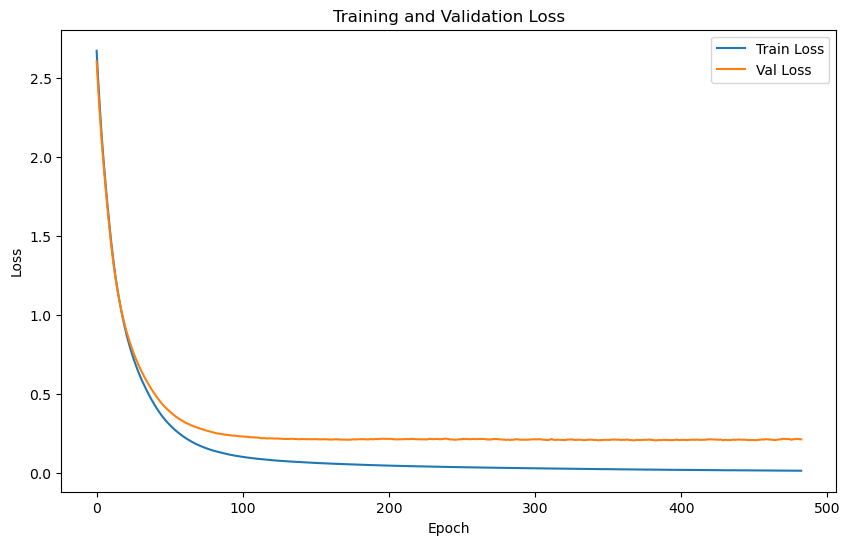

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.1484 | Test Accuracy: 96.65%


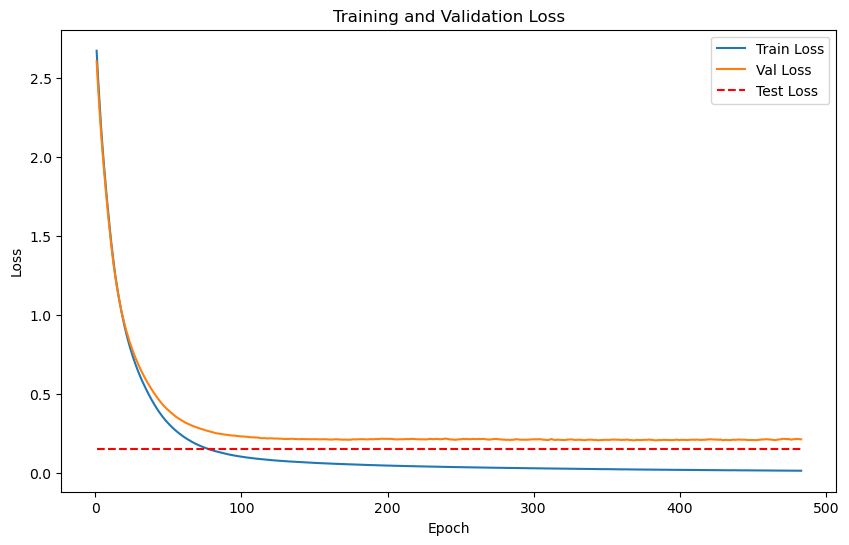

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


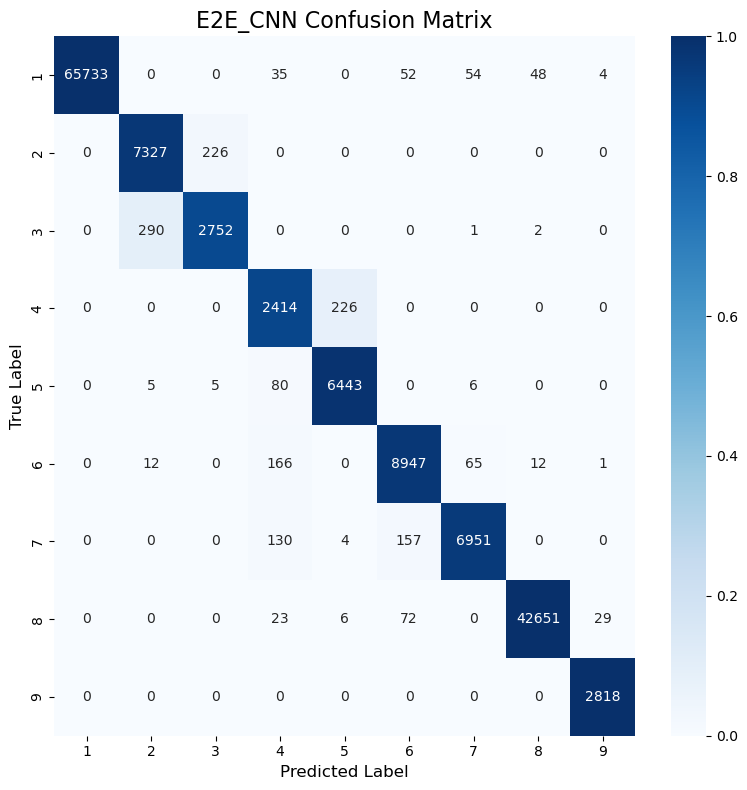

Classification Accuracy: 98.84%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


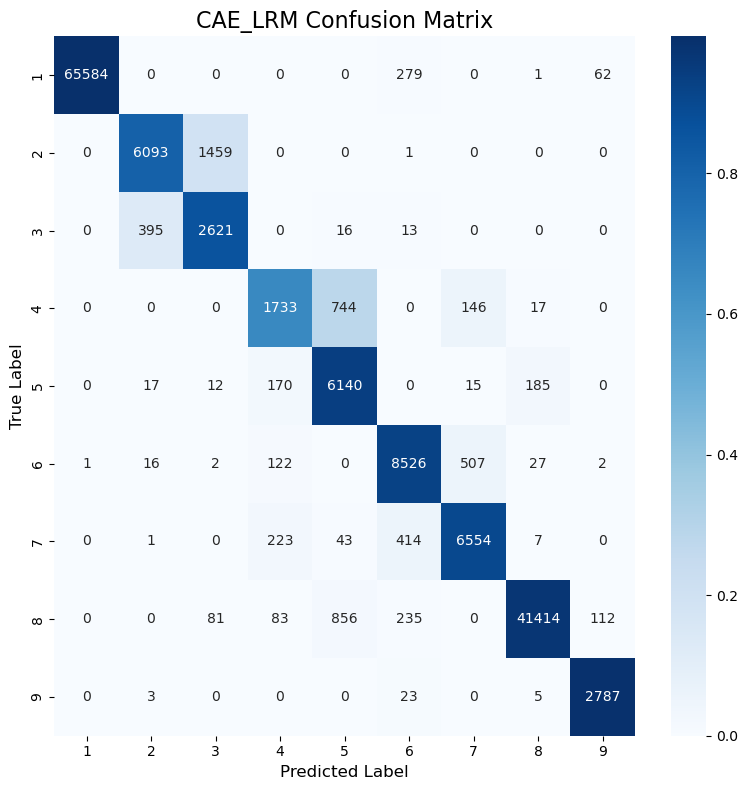

Classification Accuracy: 95.74%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


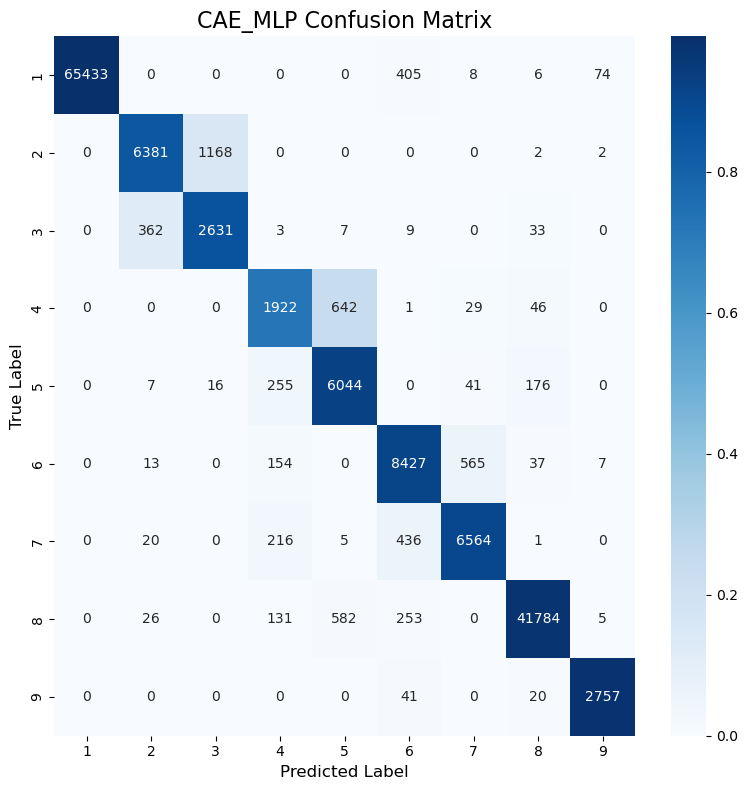

Classification Accuracy: 96.07%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


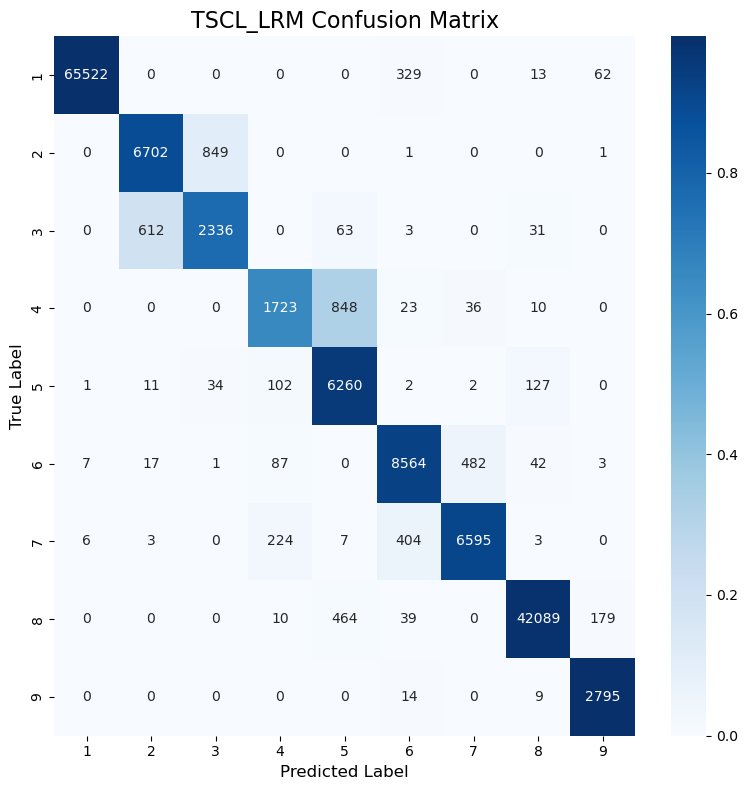

Classification Accuracy: 96.51%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


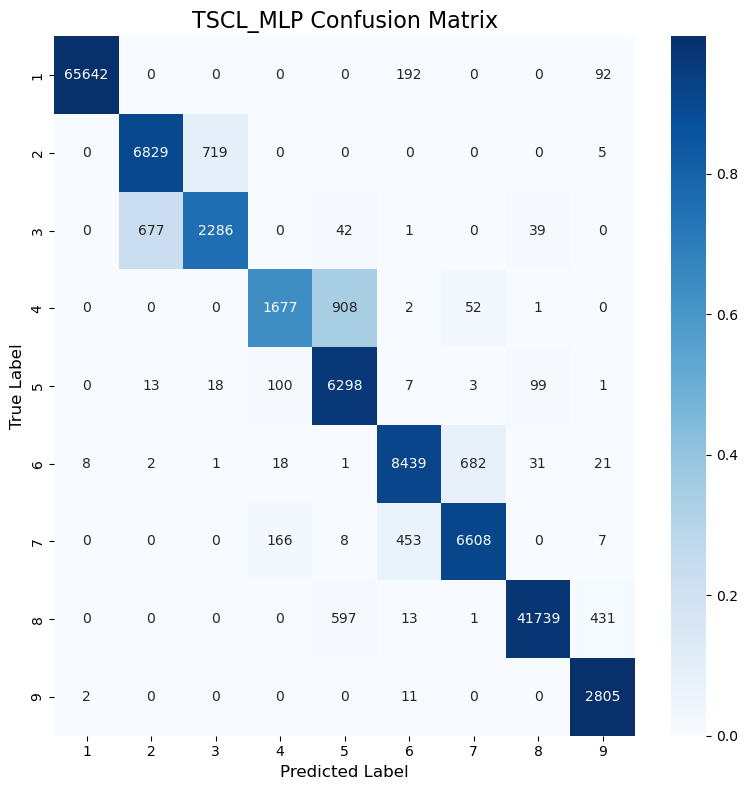

Classification Accuracy: 96.33%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


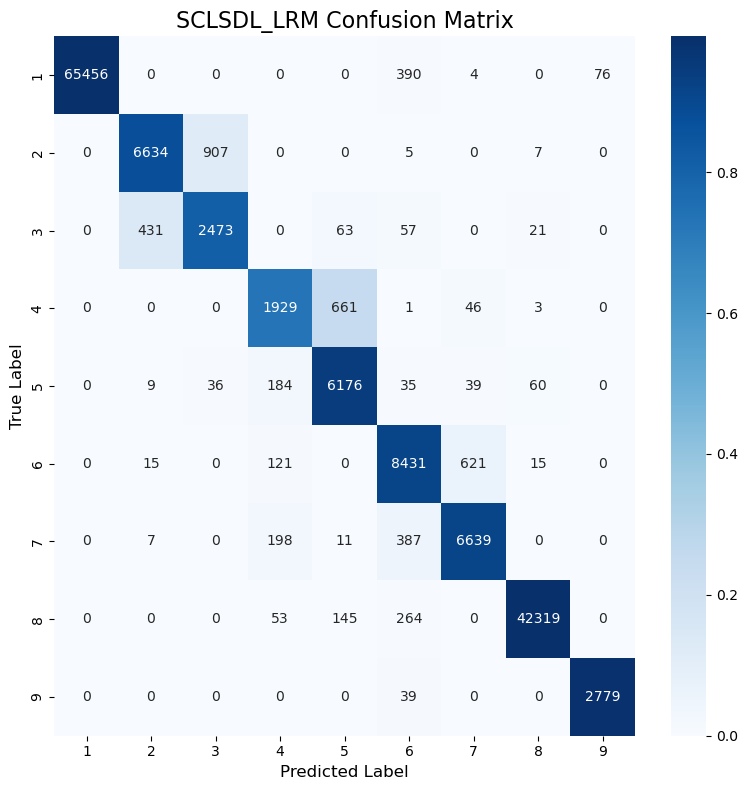

Classification Accuracy: 96.68%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


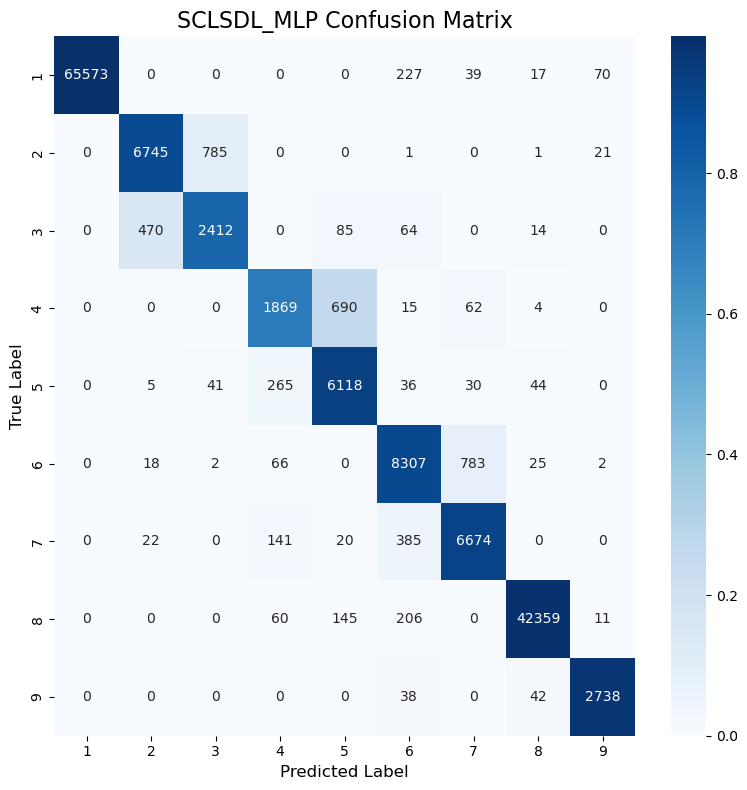

Classification Accuracy: 96.65%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          98.84
1    LRM (CAE)          95.74
2    MLP (CAE)          96.07
3     TSCL LRM          96.51
4     TSCL MLP          96.33
5  SCL_SDL LRM          96.68
6  SCL_SDL MLP          96.65

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          98.84
5  SCL_SDL LRM          96.68
6  SCL_SDL MLP          96.65
3     TSCL LRM          96.51
4     TSCL MLP          96.33
2    MLP (CAE)          96.07
1    LRM (CAE)          95.74
